## GRB230307A CARMA (2,1) Model using TinyGP and Numpyro

I'm going to do simulated data from scratch, and then see if I can sample that model using NUTS or Nested SAmpling in Numpyro:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import pickle
import numpy as np
import scipy.io

# Need both Jax and Tensorflow Probability 
import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

# TinyGP for Gaussian Processes, JaxNS for sampling
from tinygp import GaussianProcess, kernels
from tinygp.kernels.quasisep import CARMA

from jaxns.utils import resample

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.nested_sampling import NestedSampler

import arviz as az

INFO[2023-10-31 18:49:59,266]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1698774599.266094       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-10-31 18:49:59,268]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-31 18:49:59,285]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

In [2]:
def get_ar_roots(qpo_width, qpo_centroid):
    """
    Return the roots of the characteristic AR(p) polynomial of the CARMA(p,q) process, given the lorentzian widths and
    centroids.

    :rtype : The roots of the autoregressive polynomial, a numpy array.
    :param qpo_width: The widths of the lorentzian functions defining the PSD.
    :param qpo_centroid: The centroids of the lorentzian functions defining the PSD. For all values of qpo_centroid
         that are greater than zero, the complex conjugate of the root will also be added.
    """
    ar_roots = []
    for i in range(len(qpo_centroid)):
        ar_roots.append(qpo_width[i] + 1j * qpo_centroid[i])
        if qpo_centroid[i] > 1e-10:
            # lorentzian is centered at a frequency > 0, so add complex conjugate of this root
            ar_roots.append(np.conjugate(ar_roots[-1]))
    if len(qpo_width) - len(qpo_centroid) == 1:
        # odd number of lorentzian functions, so add in low-frequency component
        ar_roots.append(qpo_width[-1] + 1j * 0.0)
    ar_roots = np.array(ar_roots)

    return -2.0 * np.pi * ar_roots

def power_spectrum(freq, ar_coef, ma_coefs=[1.0]):
    """
    FROM CARMApack (Kelly et al, 2014)
    
    Return the power spectrum for a CARMA(p,q) process calculated at the input frequencies.

    :param freq: The frequencies at which to calculate the PSD.
    :param sigma: The standard deviation driving white noise.
    :param ar_coef: The CARMA model autoregressive coefficients.
    :param ma_coefs: Coefficients of the moving average polynomial

    :rtype : The power spectrum at the input frequencies, a numpy array.
    """
    try:
        len(ma_coefs) <= len(ar_coef)
    except ValueError:
        "Size of ma_coefs must be less or equal to size of ar_roots."

    ma_poly = np.polyval(ma_coefs[::-1], 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD numerator
    ar_poly = np.polyval(ar_coef, 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD denominator
    pspec = np.abs(ma_poly) ** 2 / np.abs(ar_poly) ** 2
    return pspec

def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y

In [3]:
from tinygp.kernels.quasisep import CARMA

def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive_carma(lc, res, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2']

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]

    mean_val = skewgaussian(lc.time, mean_params)
    kernel = CARMA.init(alpha=alpha, beta=beta)

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled


## Modeling the Real Data

To load the data, we'll have to read them from an IDL .sav file, which will return a dictionary with the relevant columns as keywords and the values in arrays:

In [4]:
#datadir = "/Users/danielahuppenkothen/work/repositories/grb230307a_qposearch/data/"
datadir = "/Users/daniela/work/data/grb230307A/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")

In [5]:
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

minind = barytime.searchsorted(0.0)
maxind = barytime.searchsorted(60.0)

barytime = barytime[minind:maxind]
counts = counts[minind:maxind]

# calculate background flux
mean_bkg = np.mean(counts[-100:])

# store in Lightcurve object, then truncate to 0-60s interval:
lc = Lightcurve(barytime, counts-mean_bkg)

# calculate periodogram for comparison:
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-31 18:50:21,020]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-31 18:50:21,220]: Checking if light curve is sorted.
INFO[2023-10-31 18:50:21,422]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


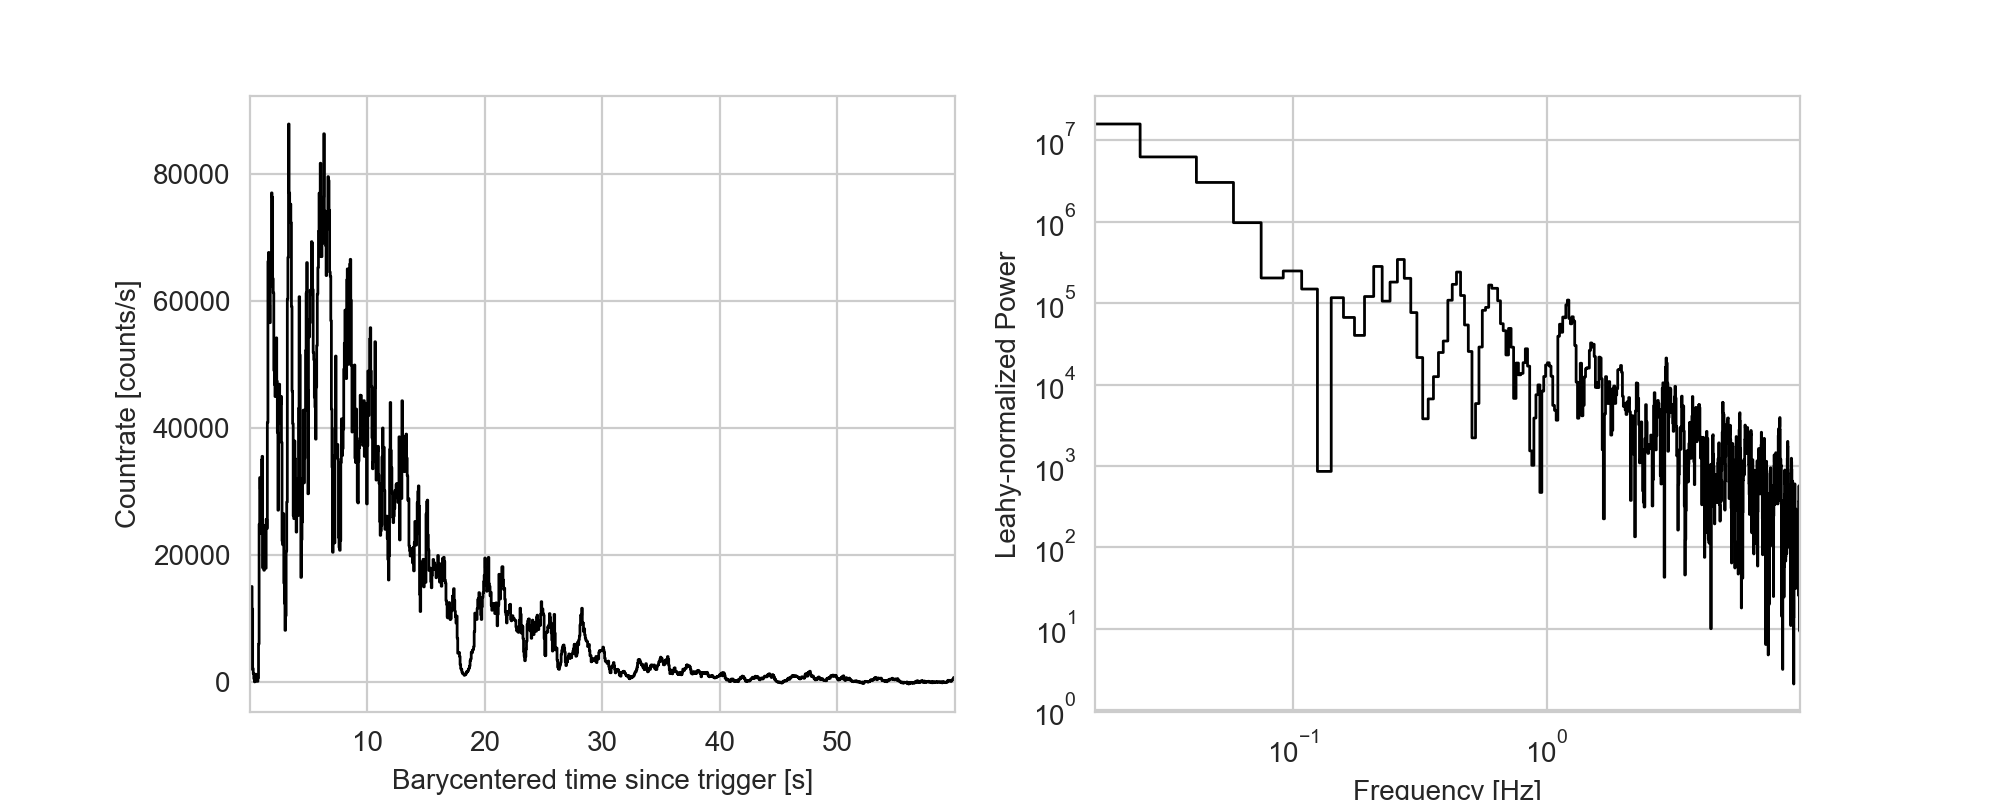

Text(0, 0.5, 'Leahy-normalized Power')

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [7]:
mean_bkg = np.log(np.mean(lc.counts[-100:]))

def carma21_integral(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(5, 15.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 20))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 40))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 40))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 40))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [8]:
ns = NestedSampler(carma21_integral, constructor_kwargs={"num_live_points":2000, 
                                                         "max_samples":1e6})
ns.run(random.PRNGKey(2441), lc.time, y=lc.counts)

In [9]:
import pickle
with open(datadir + "integral_carma21_ns.pkl", "wb") as f:
    pickle.dump(ns, f)

In [8]:
import pickle
with open(datadir + "integral_carma21_ns.pkl", "rb") as f:
    ns = pickle.load(f)

In [9]:
samples, weights = ns.get_weighted_samples()

ns.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 12193410
# samples: 76000
# slices: 1470000.0
# slices / acceptance: 21.0
# likelihood evals / sample: 160.4
# likelihood evals / slice: 8.3
--------
logZ=-11631.05 +- 0.12
H=12000.0
ESS=8500
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 5.58 +- 0.66 | 5.39 / 5.57 / 5.74 | 5.61 | 5.61
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 4.29 +- 0.67 | 4.09 / 4.26 / 4.46 | 4.24 | 4.24
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 10.867 +- 0.046 | 10.809 / 10.867 / 10.924 | 10.854 | 10.854
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 14.26 +- 0.66 | 14.1 / 14.23 / 14.4 | 14.21 | 14.21
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: -0.34 +- 0.52 | 

pred[91]: -8000.0 +- 2200.0 | -10800.0 / -8000.0 / -5100.0 | -7300.0 | -7300.0
pred[92]: -19300.0 +- 2200.0 | -22100.0 / -19300.0 / -16400.0 | -18700.0 | -18700.0
pred[93]: -15400.0 +- 2200.0 | -18200.0 / -15300.0 / -12500.0 | -14700.0 | -14700.0
pred[94]: -7700.0 +- 2200.0 | -10500.0 / -7700.0 / -4900.0 | -7100.0 | -7100.0
pred[95]: 1700.0 +- 2200.0 | -1100.0 / 1700.0 / 4500.0 | 2400.0 | 2400.0
pred[96]: 10900.0 +- 2200.0 | 8100.0 / 10900.0 / 13700.0 | 11500.0 | 11500.0
pred[97]: 15600.0 +- 2200.0 | 12800.0 / 15600.0 / 18400.0 | 16300.0 | 16300.0
pred[98]: -4300.0 +- 2200.0 | -7000.0 / -4200.0 / -1500.0 | -3600.0 | -3600.0
pred[99]: -20500.0 +- 2200.0 | -23300.0 / -20500.0 / -17700.0 | -19800.0 | -19800.0
pred[100]: 6800.0 +- 2200.0 | 4000.0 / 6800.0 / 9500.0 | 7400.0 | 7400.0
pred[101]: 4300.0 +- 2200.0 | 1500.0 / 4300.0 / 7000.0 | 5000.0 | 5000.0
pred[102]: 6600.0 +- 2200.0 | 3800.0 / 6600.0 / 9300.0 | 7200.0 | 7200.0
pred[103]: 11800.0 +- 2200.0 | 9000.0 / 11800.0 / 14500.0 | 12400

pred[213]: 17800.0 +- 1800.0 | 15600.0 / 18000.0 / 19900.0 | 17500.0 | 17500.0
pred[214]: 400.0 +- 1800.0 | -1700.0 / 600.0 / 2500.0 | 100.0 | 100.0
pred[215]: -3600.0 +- 1800.0 | -5700.0 / -3400.0 / -1500.0 | -3900.0 | -3900.0
pred[216]: -1000.0 +- 1800.0 | -3200.0 / -900.0 / 1000.0 | -1400.0 | -1400.0
pred[217]: 1200.0 +- 1800.0 | -1000.0 / 1300.0 / 3300.0 | 900.0 | 900.0
pred[218]: 2200.0 +- 1800.0 | 100.0 / 2400.0 / 4300.0 | 1900.0 | 1900.0
pred[219]: -2100.0 +- 1800.0 | -4200.0 / -1900.0 / -0.0 | -2400.0 | -2400.0
pred[220]: -3300.0 +- 1800.0 | -5500.0 / -3200.0 / -1200.0 | -3700.0 | -3700.0
pred[221]: -9100.0 +- 1800.0 | -11200.0 / -9000.0 / -7000.0 | -9500.0 | -9500.0
pred[222]: -11100.0 +- 1800.0 | -13300.0 / -11000.0 / -9100.0 | -11500.0 | -11500.0
pred[223]: -10200.0 +- 1800.0 | -12400.0 / -10100.0 / -8200.0 | -10700.0 | -10700.0
pred[224]: -9200.0 +- 1700.0 | -11300.0 / -9100.0 / -7100.0 | -9600.0 | -9600.0
pred[225]: 1700.0 +- 1700.0 | -400.0 / 1800.0 / 3800.0 | 1300.0 | 13

pred[331]: 1800.0 +- 1900.0 | -600.0 / 1700.0 / 4200.0 | 300.0 | 300.0
pred[332]: -1000.0 +- 1900.0 | -3400.0 / -1200.0 / 1400.0 | -2500.0 | -2500.0
pred[333]: -1400.0 +- 1900.0 | -3700.0 / -1500.0 / 1100.0 | -2800.0 | -2800.0
pred[334]: -4000.0 +- 1900.0 | -6400.0 / -4100.0 / -1600.0 | -5500.0 | -5500.0
pred[335]: -4500.0 +- 1900.0 | -6800.0 / -4600.0 / -2000.0 | -5900.0 | -5900.0
pred[336]: -6300.0 +- 1900.0 | -8700.0 / -6500.0 / -3900.0 | -7800.0 | -7800.0
pred[337]: -6300.0 +- 1900.0 | -8700.0 / -6500.0 / -3900.0 | -7800.0 | -7800.0
pred[338]: -5900.0 +- 1900.0 | -8200.0 / -6000.0 / -3400.0 | -7300.0 | -7300.0
pred[339]: -3600.0 +- 1900.0 | -6000.0 / -3800.0 / -1200.0 | -5100.0 | -5100.0
pred[340]: -4500.0 +- 1900.0 | -6800.0 / -4600.0 / -2000.0 | -5900.0 | -5900.0
pred[341]: -6100.0 +- 1900.0 | -8400.0 / -6200.0 / -3600.0 | -7500.0 | -7500.0
pred[342]: -5800.0 +- 1900.0 | -8200.0 / -5900.0 / -3300.0 | -7300.0 | -7300.0
pred[343]: -4500.0 +- 1900.0 | -6800.0 / -4600.0 / -2000.0 | -

pred[448]: 4100.0 +- 1500.0 | 2300.0 / 4000.0 / 5900.0 | 2900.0 | 2900.0
pred[449]: 4200.0 +- 1500.0 | 2400.0 / 4200.0 / 6000.0 | 3100.0 | 3100.0
pred[450]: 4000.0 +- 1500.0 | 2300.0 / 4000.0 / 5800.0 | 2900.0 | 2900.0
pred[451]: 4000.0 +- 1400.0 | 2200.0 / 4000.0 / 5800.0 | 2900.0 | 2900.0
pred[452]: 4100.0 +- 1400.0 | 2300.0 / 4000.0 / 5800.0 | 2900.0 | 2900.0
pred[453]: 3100.0 +- 1400.0 | 1300.0 / 3100.0 / 4800.0 | 2000.0 | 2000.0
pred[454]: 2600.0 +- 1400.0 | 900.0 / 2600.0 / 4400.0 | 1500.0 | 1500.0
pred[455]: 2500.0 +- 1400.0 | 800.0 / 2500.0 / 4300.0 | 1400.0 | 1400.0
pred[456]: 3300.0 +- 1400.0 | 1500.0 / 3300.0 / 5000.0 | 2200.0 | 2200.0
pred[457]: 2500.0 +- 1400.0 | 800.0 / 2500.0 / 4200.0 | 1400.0 | 1400.0
pred[458]: 3100.0 +- 1400.0 | 1400.0 / 3100.0 / 4800.0 | 2000.0 | 2000.0
pred[459]: 4600.0 +- 1400.0 | 2800.0 / 4500.0 / 6200.0 | 3500.0 | 3500.0
pred[460]: 6500.0 +- 1400.0 | 4800.0 / 6400.0 / 8100.0 | 5400.0 | 5400.0
pred[461]: 5600.0 +- 1400.0 | 3900.0 / 5500.0 / 7300.0

pred[583]: 2240.0 +- 510.0 | 1590.0 / 2270.0 / 2840.0 | 1850.0 | 1850.0
pred[584]: 2550.0 +- 500.0 | 1910.0 / 2580.0 / 3150.0 | 2170.0 | 2170.0
pred[585]: 2430.0 +- 490.0 | 1800.0 / 2470.0 / 3030.0 | 2060.0 | 2060.0
pred[586]: 2490.0 +- 490.0 | 1860.0 / 2530.0 / 3080.0 | 2120.0 | 2120.0
pred[587]: 2210.0 +- 480.0 | 1590.0 / 2250.0 / 2800.0 | 1850.0 | 1850.0
pred[588]: 2340.0 +- 480.0 | 1720.0 / 2370.0 / 2910.0 | 1970.0 | 1970.0
pred[589]: 2960.0 +- 470.0 | 2350.0 / 2990.0 / 3530.0 | 2600.0 | 2600.0
pred[590]: 2000.0 +- 470.0 | 1400.0 / 2040.0 / 2570.0 | 1650.0 | 1650.0
pred[591]: 2870.0 +- 460.0 | 2270.0 / 2900.0 / 3430.0 | 2520.0 | 2520.0
pred[592]: 2590.0 +- 460.0 | 2000.0 / 2630.0 / 3150.0 | 2250.0 | 2250.0
pred[593]: 2620.0 +- 460.0 | 2030.0 / 2650.0 / 3170.0 | 2280.0 | 2280.0
pred[594]: 3660.0 +- 450.0 | 3080.0 / 3700.0 / 4210.0 | 3320.0 | 3320.0
pred[595]: 3950.0 +- 450.0 | 3380.0 / 3990.0 / 4490.0 | 3620.0 | 3620.0
pred[596]: 3910.0 +- 440.0 | 3340.0 / 3950.0 / 4440.0 | 3580.0 |

pred[712]: 3380.0 +- 110.0 | 3240.0 / 3400.0 / 3500.0 | 3310.0 | 3310.0
pred[713]: 2440.0 +- 110.0 | 2300.0 / 2450.0 / 2550.0 | 2360.0 | 2360.0
pred[714]: 1770.0 +- 100.0 | 1640.0 / 1790.0 / 1890.0 | 1700.0 | 1700.0
pred[715]: 1130.0 +- 100.0 | 1000.0 / 1150.0 / 1250.0 | 1070.0 | 1070.0
pred[716]: 1150.0 +- 100.0 | 1020.0 / 1170.0 / 1260.0 | 1080.0 | 1080.0
pred[717]: 1690.0 +- 100.0 | 1560.0 / 1710.0 / 1800.0 | 1620.0 | 1620.0
pred[718]: 1524.0 +- 99.0 | 1395.0 / 1542.0 / 1632.0 | 1458.0 | 1458.0
pred[719]: 1110.0 +- 98.0 | 983.0 / 1129.0 / 1216.0 | 1045.0 | 1045.0
pred[720]: 1431.0 +- 96.0 | 1305.0 / 1449.0 / 1535.0 | 1367.0 | 1367.0
pred[721]: 1673.0 +- 95.0 | 1549.0 / 1691.0 / 1776.0 | 1610.0 | 1610.0
pred[722]: 2007.0 +- 94.0 | 1885.0 / 2025.0 / 2109.0 | 1945.0 | 1945.0
pred[723]: 2067.0 +- 92.0 | 1947.0 / 2085.0 / 2167.0 | 2006.0 | 2006.0
pred[724]: 1566.0 +- 91.0 | 1447.0 / 1583.0 / 1664.0 | 1505.0 | 1505.0
pred[725]: 1432.0 +- 90.0 | 1315.0 / 1449.0 / 1529.0 | 1372.0 | 1372.0
p

pred[838]: 886.0 +- 16.0 | 866.0 / 891.0 / 901.0 | 878.0 | 878.0
pred[839]: 773.0 +- 16.0 | 753.0 / 777.0 / 787.0 | 764.0 | 764.0
pred[840]: 827.0 +- 16.0 | 807.0 / 831.0 / 841.0 | 819.0 | 819.0
pred[841]: 515.0 +- 15.0 | 496.0 / 520.0 / 529.0 | 507.0 | 507.0
pred[842]: 520.0 +- 15.0 | 501.0 / 524.0 / 533.0 | 512.0 | 512.0
pred[843]: 254.0 +- 15.0 | 235.0 / 258.0 / 267.0 | 246.0 | 246.0
pred[844]: 54.0 +- 15.0 | 36.0 / 58.0 / 67.0 | 47.0 | 47.0
pred[845]: 140.0 +- 14.0 | 123.0 / 144.0 / 153.0 | 133.0 | 133.0
pred[846]: 35.0 +- 14.0 | 17.0 / 39.0 / 47.0 | 27.0 | 27.0
pred[847]: 135.0 +- 14.0 | 118.0 / 139.0 / 147.0 | 128.0 | 128.0
pred[848]: 179.0 +- 14.0 | 162.0 / 183.0 / 191.0 | 172.0 | 172.0
pred[849]: 156.0 +- 13.0 | 139.0 / 159.0 / 168.0 | 149.0 | 149.0
pred[850]: 100.0 +- 13.0 | 83.0 / 104.0 / 112.0 | 93.0 | 93.0
pred[851]: 192.0 +- 13.0 | 176.0 / 196.0 / 204.0 | 185.0 | 185.0
pred[852]: 328.0 +- 13.0 | 312.0 / 332.0 / 340.0 | 322.0 | 322.0
pred[853]: 467.0 +- 13.0 | 451.0 / 470.0

pred[974]: 490.0 +- 1.4 | 488.5 / 490.5 / 491.0 | 489.5 | 489.5
pred[975]: 360.0 +- 1.4 | 358.5 / 360.5 / 361.0 | 359.5 | 359.5
pred[976]: 256.0 +- 1.4 | 254.6 / 256.5 / 257.0 | 255.6 | 255.6
pred[977]: 218.0 +- 1.3 | 216.6 / 218.5 / 219.0 | 217.6 | 217.6
pred[978]: 218.1 +- 1.3 | 216.7 / 218.5 / 219.0 | 217.6 | 217.6
pred[979]: 262.1 +- 1.3 | 260.7 / 262.5 / 263.0 | 261.7 | 261.7
pred[980]: 154.1 +- 1.3 | 152.8 / 154.5 / 155.0 | 153.7 | 153.7
pred[981]: 198.1 +- 1.2 | 196.8 / 198.6 / 199.0 | 197.7 | 197.7
pred[982]: 500.1 +- 1.2 | 498.9 / 500.6 / 501.0 | 499.8 | 499.8
pred[983]: 574.2 +- 1.2 | 572.9 / 574.6 / 575.0 | 573.8 | 573.8
pred[984]: 552.2 +- 1.2 | 550.9 / 552.6 / 553.0 | 551.8 | 551.8
pred[985]: 584.2 +- 1.2 | 583.0 / 584.6 / 585.0 | 583.8 | 583.8
pred[986]: 694.2 +- 1.1 | 693.0 / 694.6 / 695.0 | 693.9 | 693.9
pred[987]: 546.3 +- 1.1 | 545.1 / 546.6 / 547.0 | 545.9 | 545.9
pred[988]: 792.3 +- 1.1 | 791.1 / 792.6 / 793.0 | 791.9 | 791.9
pred[989]: 990.3 +- 1.1 | 989.1 / 990.6 

pred[1113]: -59.021 +- 0.084 | -59.088 / -58.993 / -58.979 | -59.033 | -59.033
pred[1114]: -123.023 +- 0.082 | -123.087 / -122.995 / -122.981 | -123.033 | -123.033
pred[1115]: -107.021 +- 0.08 | -107.083 / -106.994 / -106.98 | -107.031 | -107.031
pred[1116]: -97.019 +- 0.078 | -97.08 / -96.992 / -96.98 | -97.029 | -97.029
pred[1117]: -181.022 +- 0.077 | -181.082 / -180.997 / -180.984 | -181.032 | -181.032
pred[1118]: -27.017 +- 0.075 | -27.075 / -26.992 / -26.98 | -27.026 | -27.026
pred[1119]: -275.024 +- 0.073 | -275.081 / -274.999 / -274.988 | -275.034 | -275.034
pred[1120]: -223.011 +- 0.072 | -223.067 / -222.987 / -222.976 | -223.02 | -223.02
pred[1121]: -349.025 +- 0.07 | -349.08 / -349.002 / -348.991 | -349.034 | -349.034
pred[1122]: -113.011 +- 0.069 | -113.064 / -112.988 / -112.977 | -113.019 | -113.019
pred[1123]: -251.018 +- 0.067 | -251.07 / -250.996 / -250.985 | -251.027 | -251.027
pred[1124]: -153.012 +- 0.066 | -153.063 / -152.99 / -152.98 | -153.02 | -153.02
pred[1125]: 

<IPython.core.display.Javascript object>


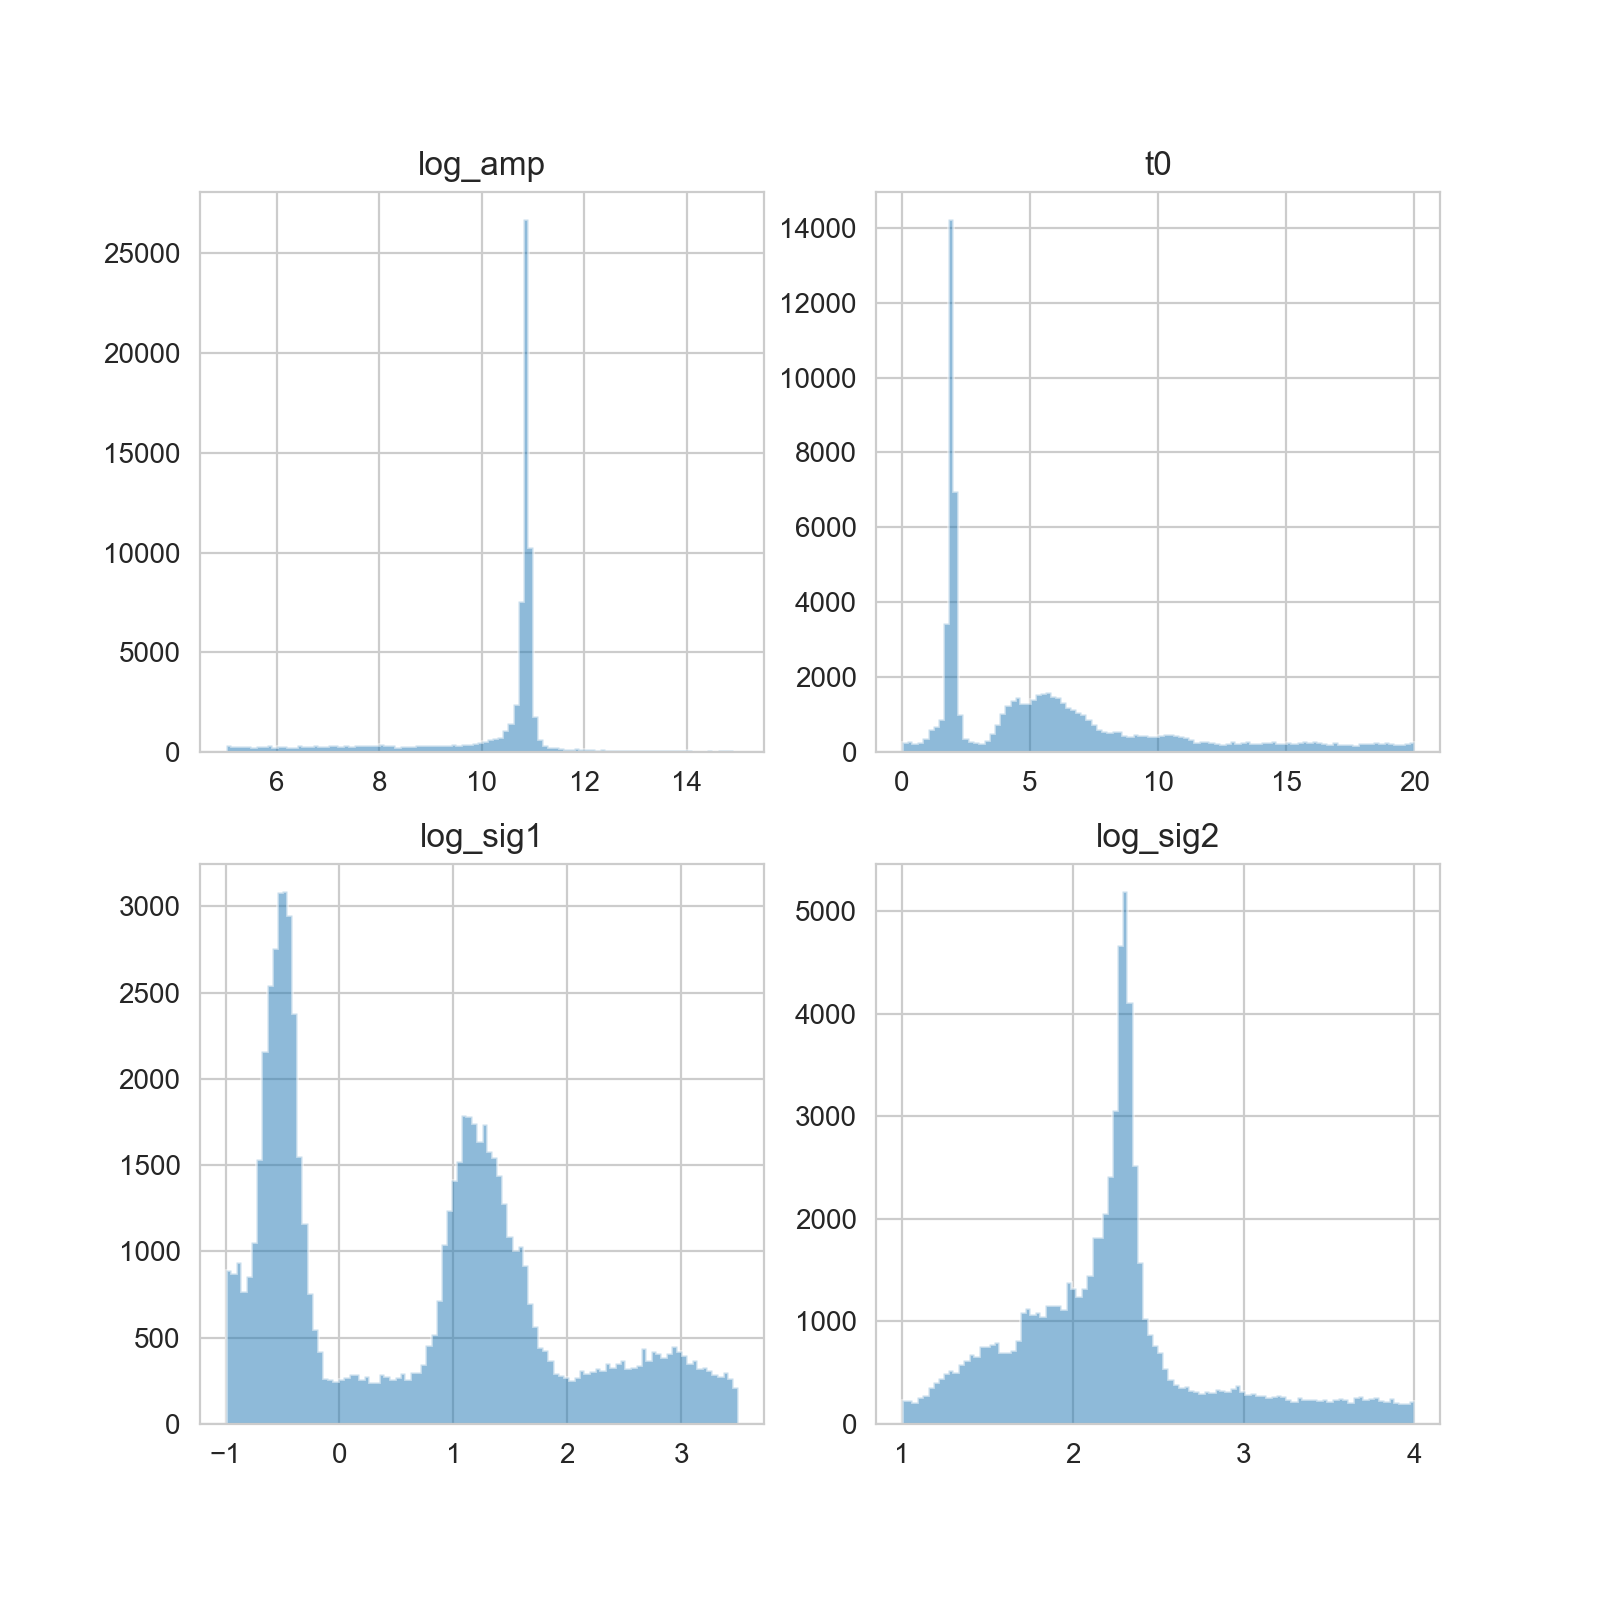

In [10]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2']

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


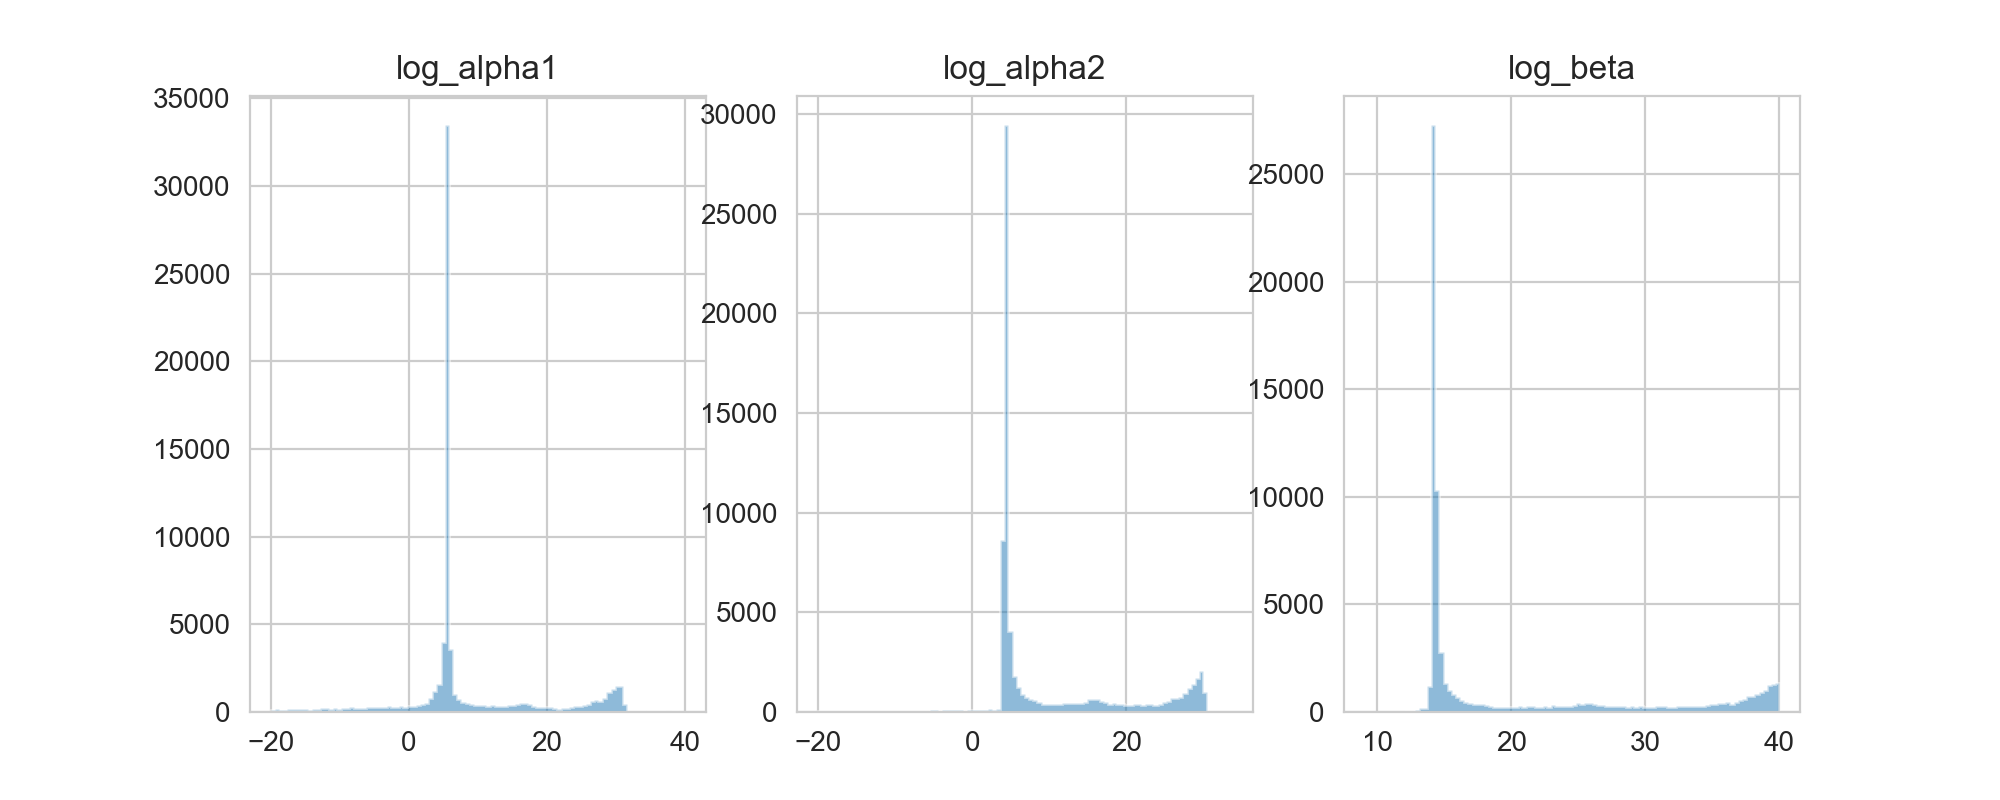

In [11]:
kernel_var_names = ["log_alpha1", "log_alpha2", "log_beta"]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

Let's include a function to compute the PSD:

<IPython.core.display.Javascript object>


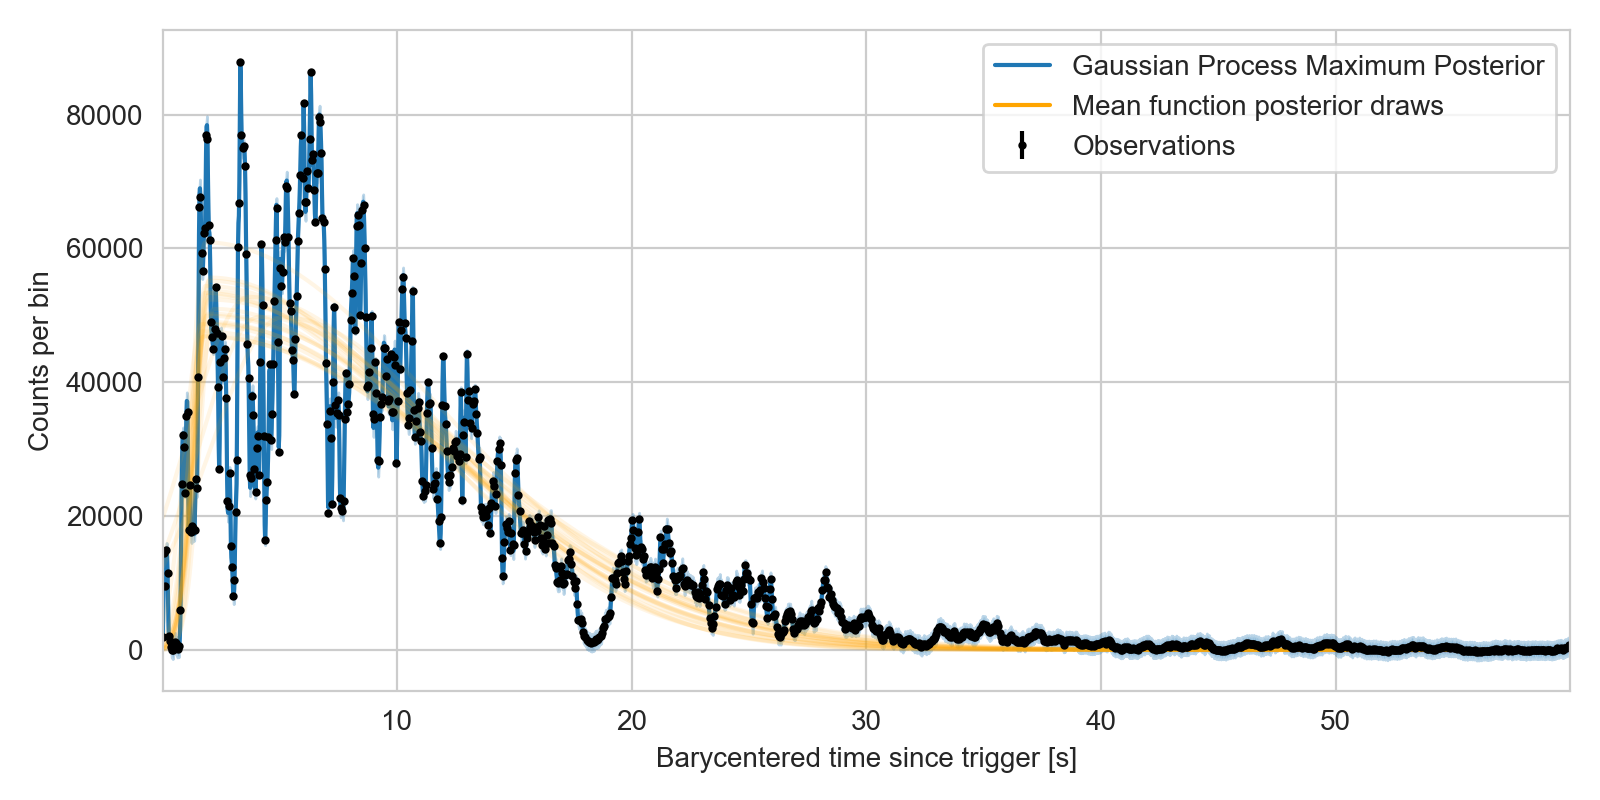

Resampling done, calculating maximum posterior model ...
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive_carma(lc, ns._results,
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

fig.tight_layout()



## A model with a QPO

Let's now add a model with a QPO:

In [53]:
def carma21_integral_with_qpo(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(5, 11.5))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 20))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3.5))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 20))
        
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])

    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(1, 15))
    log_quality = numpyro.sample("log_quality", dist.Uniform(jnp.log(2.0), jnp.log(50.0)))
    log_omega = numpyro.sample("log_omega", dist.Uniform(np.log(2.*np.pi*0.1), np.log(2.*np.pi*5)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.SHO(
            sigma=jnp.exp(log_aqpo),
            omega=jnp.exp(log_omega),
            quality = jnp.exp(log_quality)
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

Let's sample this model, too:

In [70]:
ns_qpo = NestedSampler(carma21_integral_with_qpo, constructor_kwargs={"num_live_points":1500, 
                                                         "max_samples":1e6})
ns_qpo.run(random.PRNGKey(2444), lc.time, y=lc.counts)

In [71]:
#import pickle
#with open(datadir + "integral_carma21_qpo_ns_quickrun.pkl", "wb") as f:
#    pickle.dump(ns_qpo, f)

with open(datadir + "integral_carma21_qpo_ns_slowrun.pkl", "wb") as f:
    pickle.dump(ns_qpo, f)

In [79]:
#with open(datadir + "integral_carma21_qpo_ns.pkl", "rb") as f:
#    ns_qpo = pickle.load(f)

In [72]:
samples_qpo, weights_qpo = ns_qpo.get_weighted_samples()

ns_qpo.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 12660772
# samples: 66000
# slices: 1800000.0
# slices / acceptance: 30.0
# likelihood evals / sample: 191.8
# likelihood evals / slice: 7.0
--------
logZ=-11626.04 +- 0.15
H=12000.0
ESS=9749
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 5.76 +- 0.25 | 5.52 / 5.73 / 6.0 | 5.78 | 5.78
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 4.5 +- 0.28 | 4.24 / 4.45 / 4.78 | 4.43 | 4.43
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 10.831 +- 0.045 | 10.775 / 10.832 / 10.888 | 10.85 | 10.85
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 7.5 +- 1.2 | 7.4 / 7.8 / 8.1 | 7.7 | 7.7
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 14.42 +- 0.25 | 14.2 / 14.37 / 

pred[99]: -19400.0 +- 2100.0 | -22200.0 / -19400.0 / -16800.0 | -19600.0 | -19600.0
pred[100]: 7800.0 +- 2100.0 | 5100.0 / 7800.0 / 10400.0 | 7600.0 | 7600.0
pred[101]: 5300.0 +- 2100.0 | 2600.0 / 5400.0 / 8000.0 | 5200.0 | 5200.0
pred[102]: 7600.0 +- 2100.0 | 4900.0 / 7600.0 / 10200.0 | 7400.0 | 7400.0
pred[103]: 12800.0 +- 2100.0 | 10100.0 / 12800.0 / 15400.0 | 12600.0 | 12600.0
pred[104]: 12200.0 +- 2100.0 | 9500.0 / 12200.0 / 14800.0 | 12100.0 | 12100.0
pred[105]: 20500.0 +- 2100.0 | 17800.0 / 20500.0 / 23100.0 | 20400.0 | 20400.0
pred[106]: 20300.0 +- 2100.0 | 17600.0 / 20400.0 / 22900.0 | 20200.0 | 20200.0
pred[107]: 13100.0 +- 2100.0 | 10400.0 / 13200.0 / 15700.0 | 13000.0 | 13000.0
pred[108]: 3300.0 +- 2100.0 | 600.0 / 3300.0 / 5900.0 | 3200.0 | 3200.0
pred[109]: 2200.0 +- 2100.0 | -500.0 / 2200.0 / 4800.0 | 2100.0 | 2100.0
pred[110]: -3600.0 +- 2100.0 | -6300.0 / -3600.0 / -1000.0 | -3600.0 | -3600.0
pred[111]: -5100.0 +- 2100.0 | -7800.0 / -5100.0 / -2500.0 | -5100.0 | -5100.

pred[210]: -2000.0 +- 1600.0 | -3900.0 / -2000.0 / -100.0 | -1400.0 | -1400.0
pred[211]: 2400.0 +- 1600.0 | 500.0 / 2400.0 / 4300.0 | 3000.0 | 3000.0
pred[212]: 9800.0 +- 1600.0 | 7900.0 / 9900.0 / 11700.0 | 10500.0 | 10500.0
pred[213]: 17300.0 +- 1500.0 | 15400.0 / 17300.0 / 19200.0 | 17900.0 | 17900.0
pred[214]: -100.0 +- 1500.0 | -2000.0 / -0.0 / 1800.0 | 500.0 | 500.0
pred[215]: -4100.0 +- 1500.0 | -6000.0 / -4100.0 / -2200.0 | -3500.0 | -3500.0
pred[216]: -1600.0 +- 1500.0 | -3500.0 / -1500.0 / 300.0 | -1000.0 | -1000.0
pred[217]: 600.0 +- 1500.0 | -1300.0 / 700.0 / 2500.0 | 1300.0 | 1300.0
pred[218]: 1700.0 +- 1500.0 | -300.0 / 1700.0 / 3600.0 | 2300.0 | 2300.0
pred[219]: -2700.0 +- 1500.0 | -4600.0 / -2600.0 / -800.0 | -2000.0 | -2000.0
pred[220]: -3900.0 +- 1500.0 | -5800.0 / -3900.0 / -2000.0 | -3300.0 | -3300.0
pred[221]: -9700.0 +- 1500.0 | -11600.0 / -9700.0 / -7800.0 | -9100.0 | -9100.0
pred[222]: -11700.0 +- 1500.0 | -13700.0 / -11700.0 / -9800.0 | -11100.0 | -11100.0
pre

pred[342]: -7100.0 +- 1700.0 | -9300.0 / -7100.0 / -5000.0 | -6700.0 | -6700.0
pred[343]: -5800.0 +- 1700.0 | -7900.0 / -5800.0 / -3700.0 | -5400.0 | -5400.0
pred[344]: -5400.0 +- 1700.0 | -7500.0 / -5400.0 / -3300.0 | -5000.0 | -5000.0
pred[345]: -3200.0 +- 1700.0 | -5300.0 / -3200.0 / -1100.0 | -2800.0 | -2800.0
pred[346]: -3000.0 +- 1700.0 | -5100.0 / -3000.0 / -900.0 | -2600.0 | -2600.0
pred[347]: -1800.0 +- 1700.0 | -3900.0 / -1800.0 / 300.0 | -1400.0 | -1400.0
pred[348]: -3500.0 +- 1700.0 | -5600.0 / -3400.0 / -1300.0 | -3100.0 | -3100.0
pred[349]: -5100.0 +- 1700.0 | -7200.0 / -5100.0 / -3000.0 | -4700.0 | -4700.0
pred[350]: -5800.0 +- 1700.0 | -8000.0 / -5800.0 / -3700.0 | -5500.0 | -5500.0
pred[351]: -6700.0 +- 1700.0 | -8800.0 / -6700.0 / -4600.0 | -6400.0 | -6400.0
pred[352]: -5500.0 +- 1700.0 | -7600.0 / -5500.0 / -3300.0 | -5100.0 | -5100.0
pred[353]: -8800.0 +- 1700.0 | -11000.0 / -8800.0 / -6700.0 | -8500.0 | -8500.0
pred[354]: -11100.0 +- 1700.0 | -13200.0 / -11100.0 / 

pred[469]: -1500.0 +- 1300.0 | -3100.0 / -1400.0 / 0.0 | -1400.0 | -1400.0
pred[470]: -200.0 +- 1300.0 | -1800.0 / -200.0 / 1300.0 | -100.0 | -100.0
pred[471]: 1100.0 +- 1200.0 | -500.0 / 1100.0 / 2600.0 | 1200.0 | 1200.0
pred[472]: 3800.0 +- 1200.0 | 2200.0 / 3900.0 / 5300.0 | 3900.0 | 3900.0
pred[473]: 4300.0 +- 1200.0 | 2800.0 / 4400.0 / 5800.0 | 4500.0 | 4500.0
pred[474]: 4700.0 +- 1200.0 | 3200.0 / 4800.0 / 6200.0 | 4800.0 | 4800.0
pred[475]: 4800.0 +- 1200.0 | 3300.0 / 4900.0 / 6300.0 | 4900.0 | 4900.0
pred[476]: 3200.0 +- 1200.0 | 1700.0 / 3300.0 / 4700.0 | 3300.0 | 3300.0
pred[477]: 3000.0 +- 1200.0 | 1500.0 / 3100.0 / 4500.0 | 3100.0 | 3100.0
pred[478]: 3300.0 +- 1200.0 | 1800.0 / 3300.0 / 4700.0 | 3400.0 | 3400.0
pred[479]: 2000.0 +- 1200.0 | 500.0 / 2000.0 / 3400.0 | 2100.0 | 2100.0
pred[480]: 4100.0 +- 1200.0 | 2600.0 / 4200.0 / 5500.0 | 4200.0 | 4200.0
pred[481]: 4900.0 +- 1200.0 | 3500.0 / 5000.0 / 6400.0 | 5000.0 | 5000.0
pred[482]: 4300.0 +- 1200.0 | 2800.0 / 4300.0 / 5

pred[609]: 2150.0 +- 440.0 | 1610.0 / 2210.0 / 2640.0 | 2190.0 | 2190.0
pred[610]: 2280.0 +- 430.0 | 1750.0 / 2340.0 / 2770.0 | 2320.0 | 2320.0
pred[611]: 1430.0 +- 430.0 | 900.0 / 1490.0 / 1910.0 | 1470.0 | 1470.0
pred[612]: 1060.0 +- 420.0 | 530.0 / 1110.0 / 1530.0 | 1100.0 | 1100.0
pred[613]: 540.0 +- 420.0 | 20.0 / 590.0 / 1010.0 | 580.0 | 580.0
pred[614]: 490.0 +- 410.0 | -20.0 / 550.0 / 960.0 | 530.0 | 530.0
pred[615]: 1280.0 +- 410.0 | 770.0 / 1330.0 / 1740.0 | 1320.0 | 1320.0
pred[616]: 1550.0 +- 410.0 | 1050.0 / 1600.0 / 2000.0 | 1590.0 | 1590.0
pred[617]: 1500.0 +- 400.0 | 1010.0 / 1560.0 / 1950.0 | 1540.0 | 1540.0
pred[618]: 1830.0 +- 400.0 | 1330.0 / 1880.0 / 2270.0 | 1870.0 | 1870.0
pred[619]: 2170.0 +- 390.0 | 1680.0 / 2230.0 / 2610.0 | 2210.0 | 2210.0
pred[620]: 1670.0 +- 390.0 | 1180.0 / 1720.0 / 2100.0 | 1710.0 | 1710.0
pred[621]: 1120.0 +- 390.0 | 640.0 / 1170.0 / 1550.0 | 1160.0 | 1160.0
pred[622]: 570.0 +- 380.0 | 100.0 / 630.0 / 1000.0 | 610.0 | 610.0
pred[623]: 89

pred[749]: 2189.0 +- 87.0 | 2089.0 / 2208.0 / 2272.0 | 2202.0 | 2202.0
pred[750]: 1843.0 +- 86.0 | 1744.0 / 1862.0 / 1924.0 | 1856.0 | 1856.0
pred[751]: 1285.0 +- 85.0 | 1188.0 / 1304.0 / 1365.0 | 1298.0 | 1298.0
pred[752]: 1171.0 +- 84.0 | 1075.0 / 1190.0 / 1250.0 | 1183.0 | 1183.0
pred[753]: 1104.0 +- 83.0 | 1010.0 / 1123.0 / 1183.0 | 1117.0 | 1117.0
pred[754]: 1224.0 +- 82.0 | 1131.0 / 1243.0 / 1301.0 | 1237.0 | 1237.0
pred[755]: 1502.0 +- 81.0 | 1410.0 / 1520.0 / 1578.0 | 1515.0 | 1515.0
pred[756]: 1270.0 +- 80.0 | 1180.0 / 1288.0 / 1345.0 | 1282.0 | 1282.0
pred[757]: 1202.0 +- 79.0 | 1113.0 / 1220.0 / 1275.0 | 1214.0 | 1214.0
pred[758]: 1233.0 +- 78.0 | 1146.0 / 1251.0 / 1306.0 | 1245.0 | 1245.0
pred[759]: 1481.0 +- 77.0 | 1394.0 / 1499.0 / 1552.0 | 1493.0 | 1493.0
pred[760]: 1237.0 +- 76.0 | 1151.0 / 1254.0 / 1307.0 | 1249.0 | 1249.0
pred[761]: 1572.0 +- 75.0 | 1488.0 / 1590.0 / 1642.0 | 1584.0 | 1584.0
pred[762]: 1682.0 +- 74.0 | 1599.0 / 1699.0 / 1750.0 | 1694.0 | 1694.0
pred[7

pred[887]: 741.0 +- 13.0 | 730.0 / 744.0 / 750.0 | 744.0 | 744.0
pred[888]: 675.0 +- 12.0 | 664.0 / 679.0 / 684.0 | 678.0 | 678.0
pred[889]: 1115.0 +- 12.0 | 1105.0 / 1119.0 / 1124.0 | 1118.0 | 1118.0
pred[890]: 1062.0 +- 12.0 | 1051.0 / 1065.0 / 1070.0 | 1064.0 | 1064.0
pred[891]: 962.0 +- 12.0 | 951.0 / 965.0 / 970.0 | 964.0 | 964.0
pred[892]: 722.0 +- 12.0 | 712.0 / 725.0 / 730.0 | 724.0 | 724.0
pred[893]: 366.0 +- 12.0 | 356.0 / 369.0 / 374.0 | 368.0 | 368.0
pred[894]: 424.0 +- 11.0 | 415.0 / 427.0 / 432.0 | 427.0 | 427.0
pred[895]: 166.0 +- 11.0 | 157.0 / 169.0 / 174.0 | 169.0 | 169.0
pred[896]: 85.0 +- 11.0 | 75.0 / 88.0 / 92.0 | 87.0 | 87.0
pred[897]: 25.0 +- 11.0 | 16.0 / 28.0 / 32.0 | 27.0 | 27.0
pred[898]: -45.0 +- 11.0 | -54.0 / -42.0 / -38.0 | -43.0 | -43.0
pred[899]: -75.0 +- 11.0 | -84.0 / -72.0 / -68.0 | -73.0 | -73.0
pred[900]: -81.0 +- 10.0 | -89.0 / -78.0 / -74.0 | -79.0 | -79.0
pred[901]: -31.0 +- 10.0 | -39.0 / -28.0 / -24.0 | -29.0 | -29.0
pred[902]: -154.0 +- 10.0

pred[1020]: 580.3 +- 1.7 | 579.5 / 580.7 / 581.0 | 580.6 | 580.6
pred[1021]: 292.4 +- 1.7 | 291.6 / 292.7 / 293.0 | 292.7 | 292.7
pred[1022]: 386.4 +- 1.7 | 385.6 / 386.7 / 387.0 | 386.7 | 386.7
pred[1023]: 210.4 +- 1.7 | 209.6 / 210.7 / 211.0 | 210.7 | 210.7
pred[1024]: 134.4 +- 1.6 | 133.7 / 134.7 / 135.0 | 134.7 | 134.7
pred[1025]: 50.4 +- 1.6 | 49.7 / 50.8 / 51.0 | 50.7 | 50.7
pred[1026]: 50.4 +- 1.6 | 49.7 / 50.8 / 51.0 | 50.7 | 50.7
pred[1027]: 12.4 +- 1.6 | 11.8 / 12.8 / 13.0 | 12.7 | 12.7
pred[1028]: 114.5 +- 1.5 | 113.8 / 114.8 / 115.0 | 114.7 | 114.7
pred[1029]: 42.5 +- 1.5 | 41.8 / 42.8 / 43.0 | 42.7 | 42.7
pred[1030]: 18.5 +- 1.5 | 17.8 / 18.8 / 19.0 | 18.7 | 18.7
pred[1031]: 164.5 +- 1.5 | 163.9 / 164.8 / 165.0 | 164.7 | 164.7
pred[1032]: -5.5 +- 1.5 | -6.1 / -5.2 / -5.0 | -5.3 | -5.3
pred[1033]: 108.5 +- 1.4 | 107.9 / 108.8 / 109.0 | 108.7 | 108.7
pred[1034]: 30.5 +- 1.4 | 29.9 / 30.8 / 31.0 | 30.8 | 30.8
pred[1035]: -57.5 +- 1.4 | -58.0 / -57.2 / -57.0 | -57.2 | -57.2
pr

pred[1162]: -143.01 +- 0.21 | -143.04 / -142.99 / -142.98 | -142.99 | -142.99
pred[1163]: 36.99 +- 0.2 | 36.96 / 37.01 / 37.02 | 37.01 | 37.01
pred[1164]: -139.01 +- 0.2 | -139.04 / -138.99 / -138.98 | -138.99 | -138.99
pred[1165]: -113.01 +- 0.2 | -113.03 / -112.99 / -112.98 | -112.99 | -112.99
pred[1166]: -15.01 +- 0.19 | -15.03 / -14.99 / -14.98 | -14.99 | -14.99
pred[1167]: 0.99 +- 0.19 | 0.97 / 1.01 / 1.02 | 1.01 | 1.01
pred[1168]: -81.01 +- 0.19 | -81.03 / -80.99 / -80.98 | -80.99 | -80.99
pred[1169]: 10.99 +- 0.18 | 10.97 / 11.01 / 11.02 | 11.01 | 11.01
pred[1170]: -27.0 +- 0.18 | -27.03 / -26.99 / -26.98 | -26.99 | -26.99
pred[1171]: -73.0 +- 0.18 | -73.03 / -72.99 / -72.98 | -72.99 | -72.99
pred[1172]: -45.0 +- 0.18 | -45.02 / -44.99 / -44.98 | -44.99 | -44.99
pred[1173]: -19.0 +- 0.17 | -19.02 / -18.99 / -18.98 | -18.99 | -18.99
pred[1174]: -47.0 +- 0.17 | -47.02 / -46.99 / -46.98 | -46.99 | -46.99
pred[1175]: -9.0 +- 0.17 | -9.02 / -8.98 / -8.98 | -8.99 | -8.99
pred[1176]: -

In [73]:
logZ_carma = ns._results.log_Z_mean
print(logZ_carma)

-11631.05341206435


In [74]:
logZ_qpo = ns_qpo._results.log_Z_mean
print(logZ_qpo)

-11626.040480887303


In [75]:
logZ_carma - logZ_qpo

Array(-5.01293118, dtype=float64)

In [76]:
import corner

In [77]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2']

kernel_var_names = ["log_alpha1", "log_alpha2",
                    "log_beta", "log_aqpo", 
                    "log_omega", "log_quality"]

var_names = np.hstack([mean_var_names, kernel_var_names])

post_samples = samples_qpo["log_amp"]

for v in var_names[1:]:
    post_samples = np.vstack([post_samples, samples_qpo[v]])


<IPython.core.display.Javascript object>


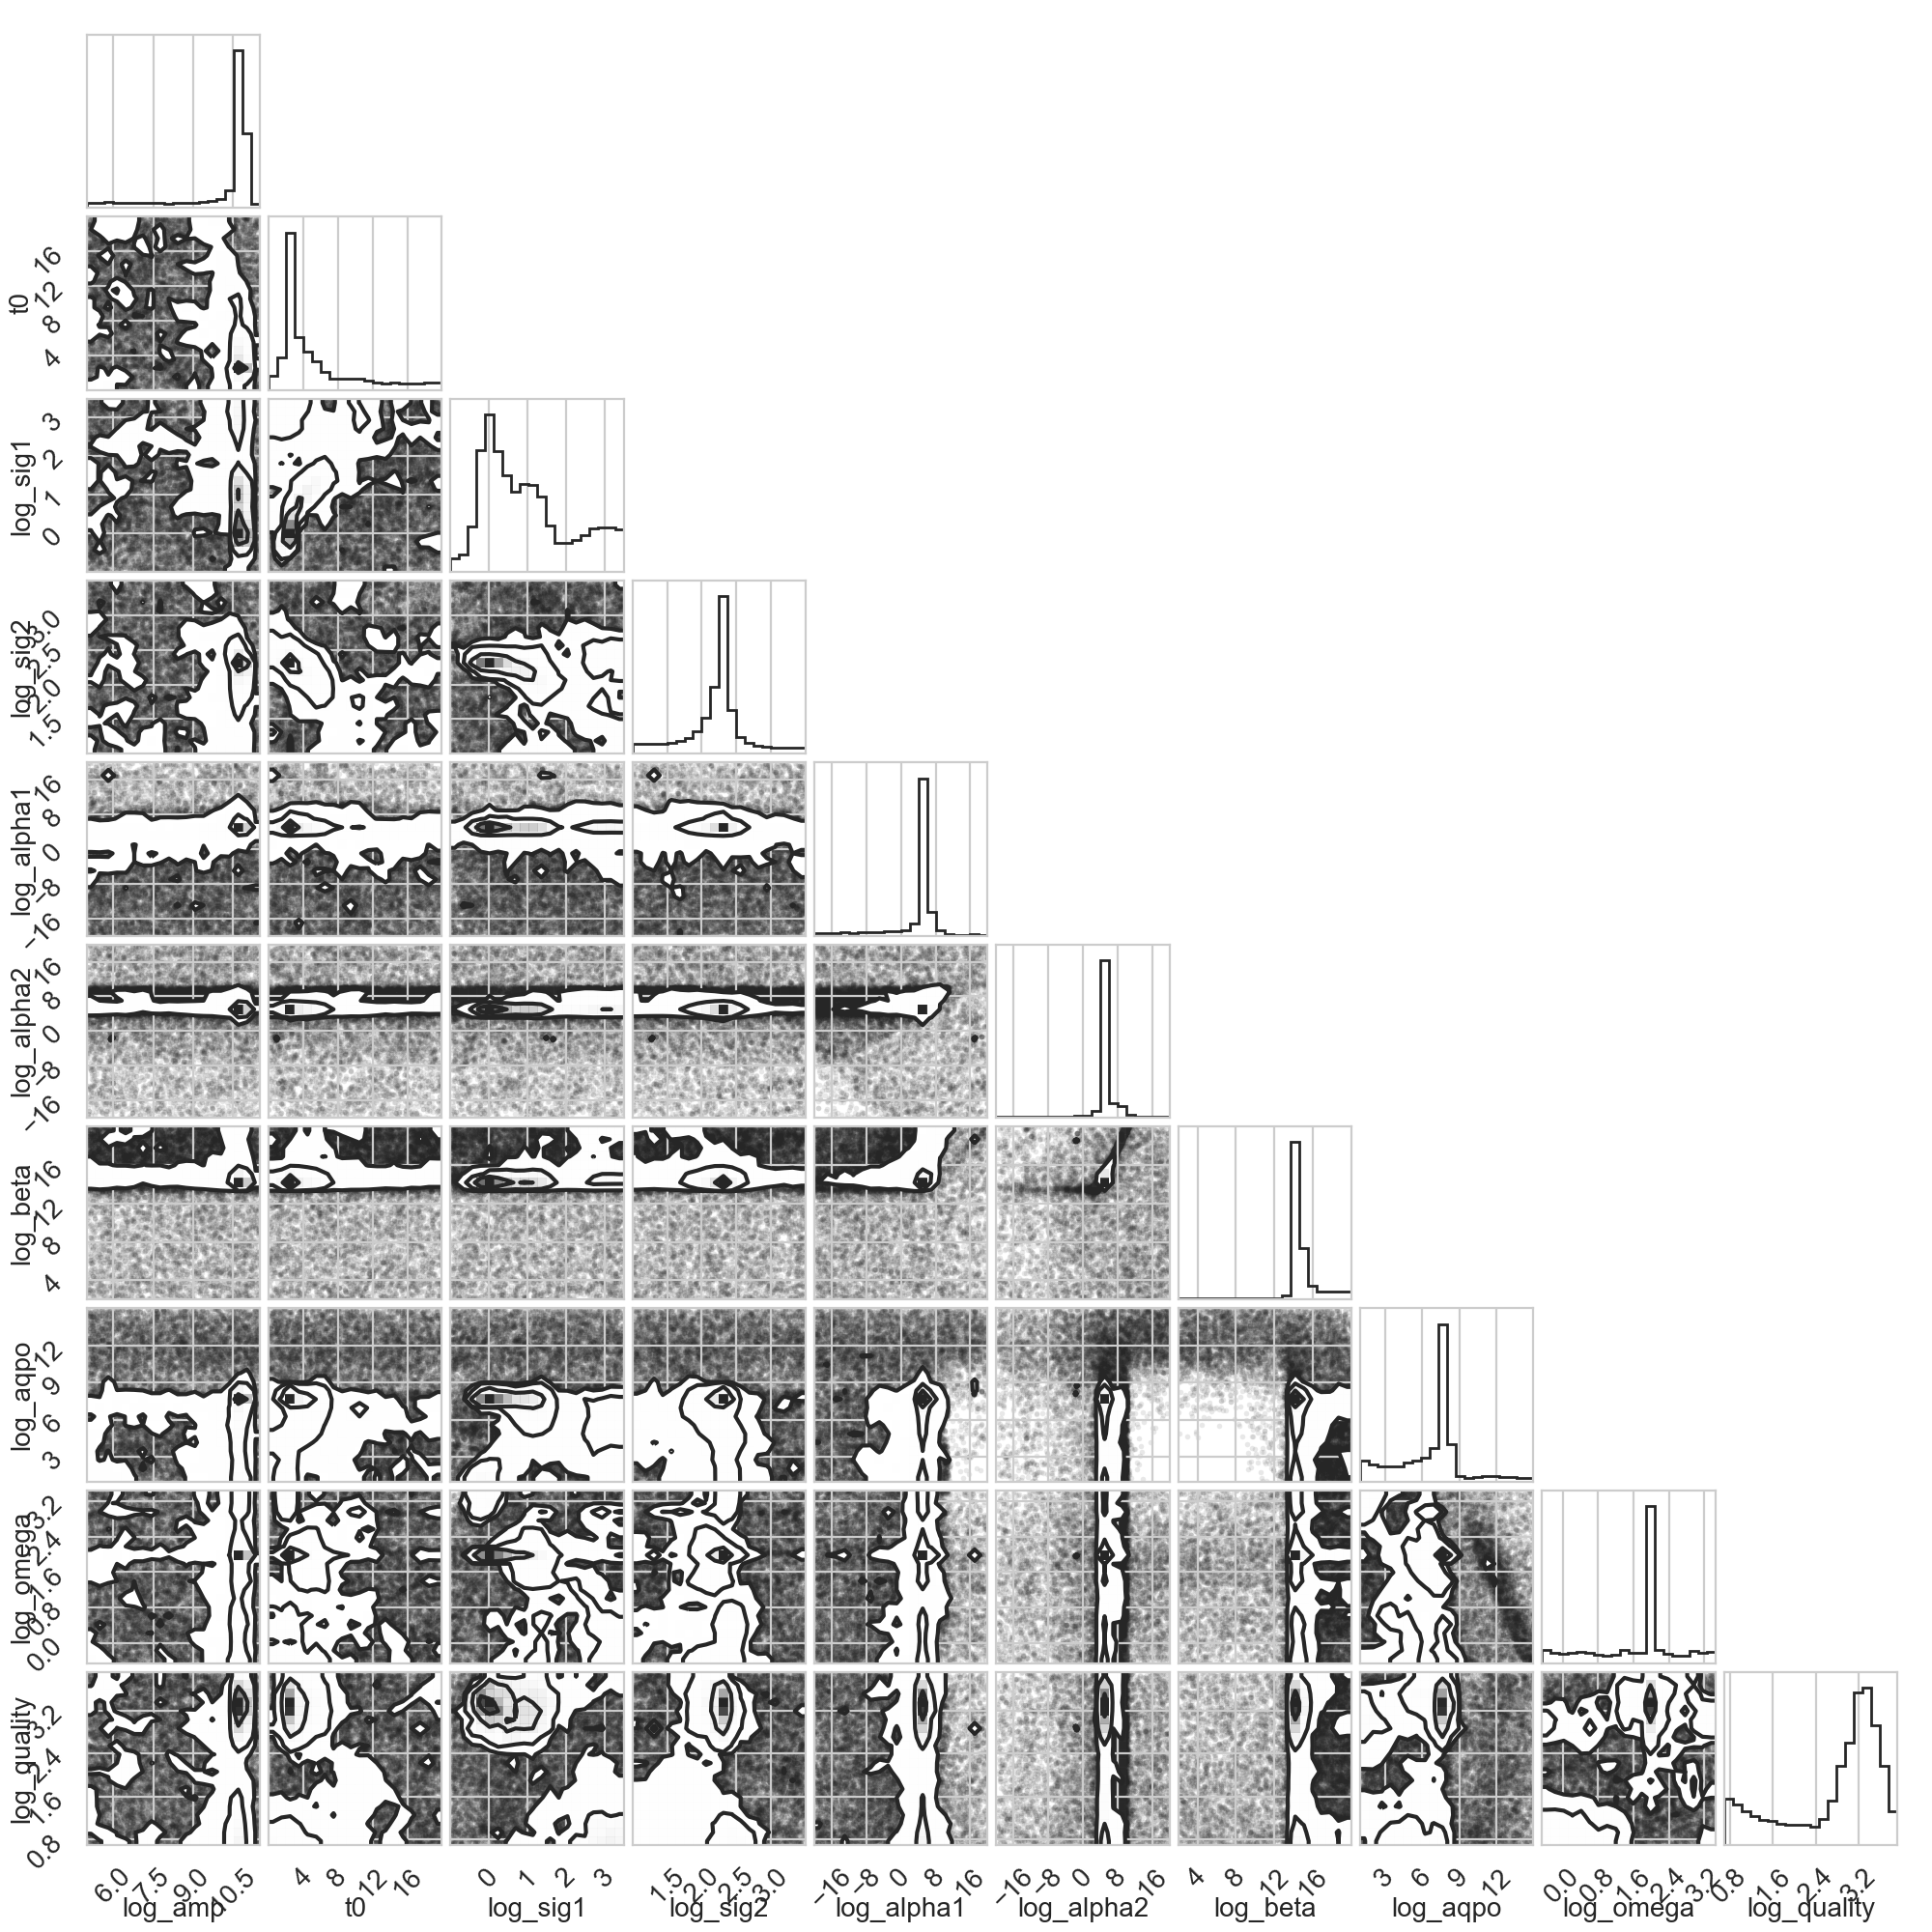

WARNING[2023-11-01 17:48:09,390]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,483]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,529]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,559]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,630]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,664]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,721]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,872]: Too few points to create valid contours
WARNING[2023-11-01 17:48:09,910]: Too few points to create valid contours
WARNING[2023-11-01 17:48:10,127]: Too few points to create valid contours
WARNING[2023-11-01 17:48:10,227]: Too few points to create valid contours
WARNING[2023-11-01 17:48:10,371]: Too few points to create valid contours
WARNING[2023-11-01 17:48:10,413]: Too few points to create valid contours
WARNING[2023-11-01 17:48:10,452]: Too 

In [78]:
fig = plt.figure(figsize=(10,10))
fig = corner.corner(post_samples.T, labels=var_names, fig=fig)

In [79]:
freq_post = np.exp(samples_qpo["log_omega"])/(2.*np.pi)

<IPython.core.display.Javascript object>


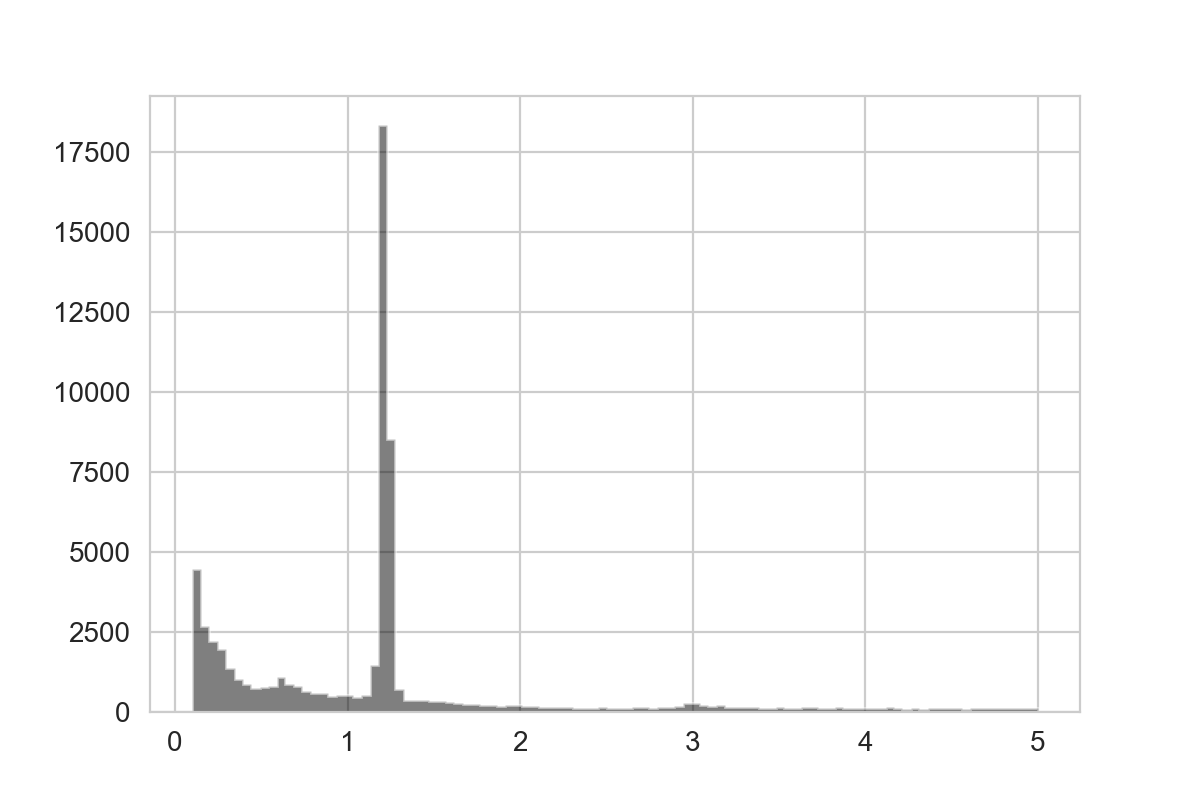

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(freq_post, bins=100, histtype="stepfilled", alpha=0.5, color="black");

In [81]:
def plot_posterior_predictive_carma_qpo(lc, res, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2']

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]
    
    omega = jnp.exp(maxpost_log["log_omega"])
    quality = jnp.exp(maxpost_log["log_quality"])
    aqpo = jnp.exp(maxpost_log["log_aqpo"])

    mean_val = skewgaussian(lc.time, mean_params)
    kernel_carma = CARMA.init(alpha=alpha, beta=beta)
    kernel_qpo = kernels.quasisep.SHO(omega=omega, quality=quality, sigma=aqpo)
    
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

<IPython.core.display.Javascript object>


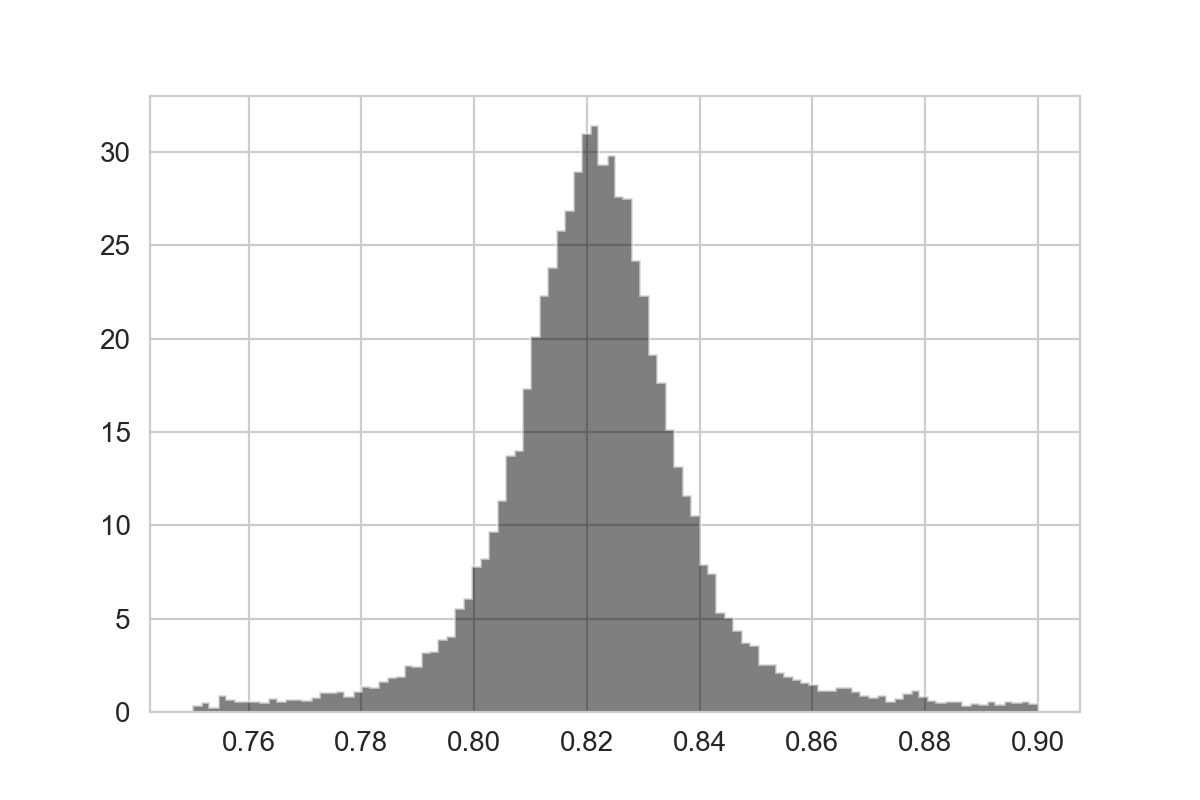

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
freq_post = np.exp(samples_qpo["log_omega"])/(2.*np.pi)
ax.hist(1/freq_post, bins=100, histtype="stepfilled", alpha=0.5, color="black", 
        range=[0.75,0.9], density=True);


<IPython.core.display.Javascript object>


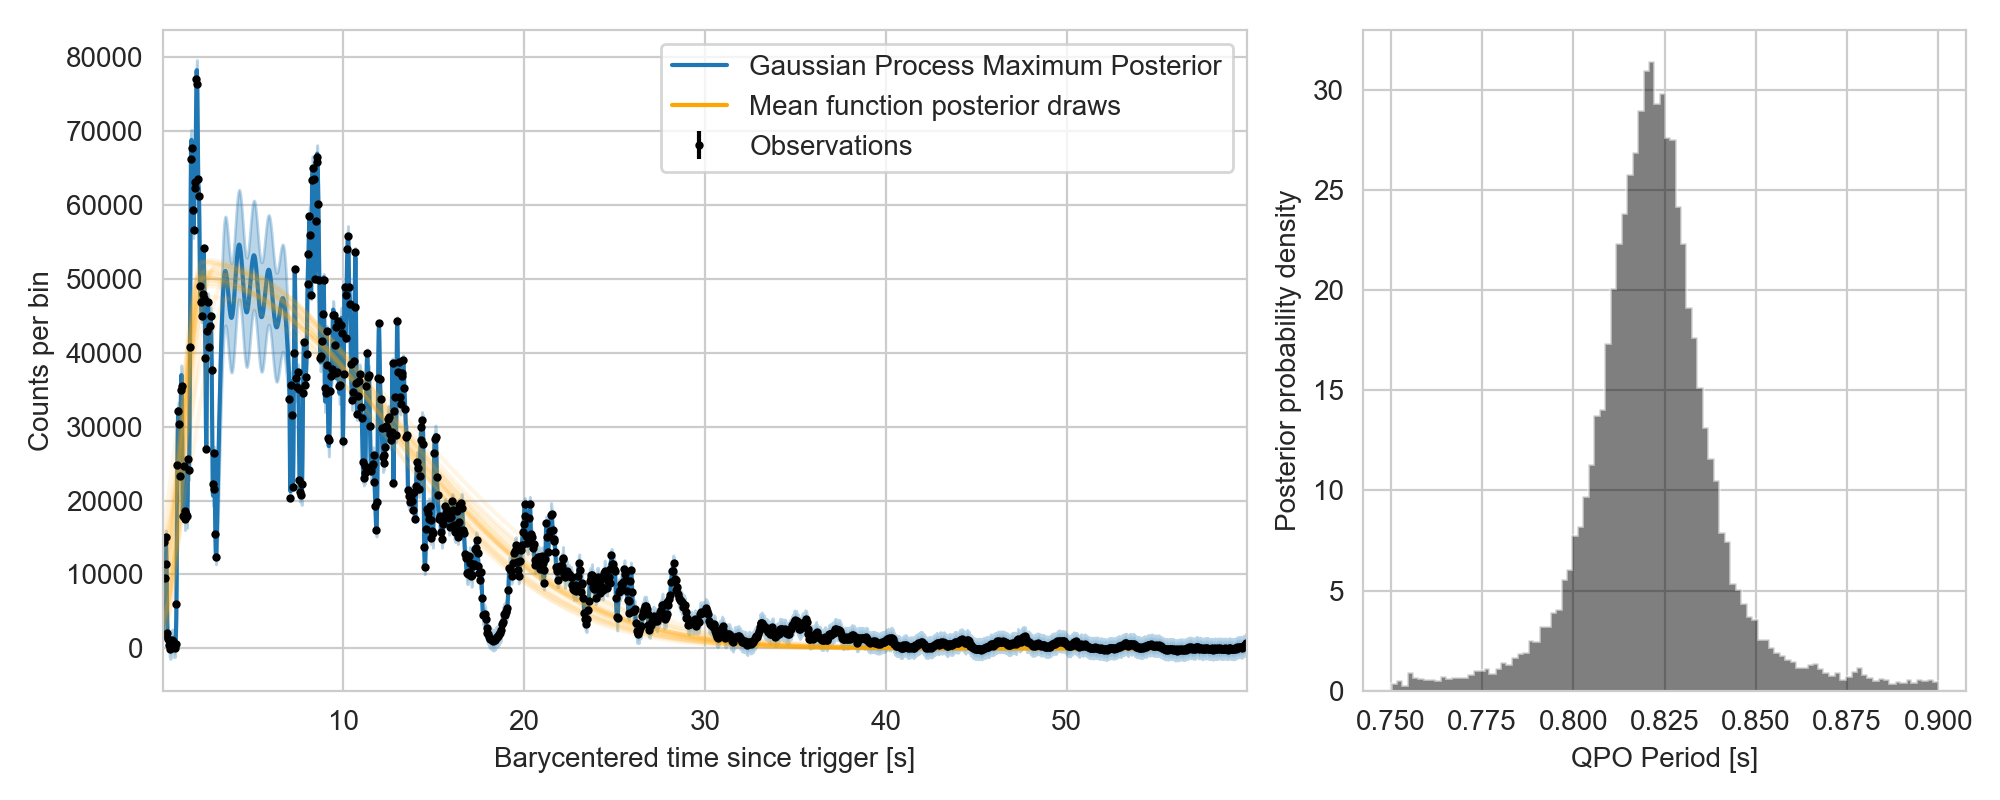

Resampling done, calculating maximum posterior model ...
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), width_ratios=[1.8, 1.0])

ax1 = plot_posterior_predictive_carma_qpo(lc, ns_qpo._results,
                               nmean=20, ngrid=3000, ax=ax1, rkey=None)

ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Counts per bin")

ax2.hist(1/freq_post, bins=100, histtype="stepfilled", alpha=0.5, 
         color="black", range=[0.75,0.9], density=True)
ax2.set_xlabel("QPO Period [s]")
ax2.set_ylabel("Posterior probability density")
fig.tight_layout()



## INTEGRAL, Cutout: CARMA Model

<IPython.core.display.Javascript object>


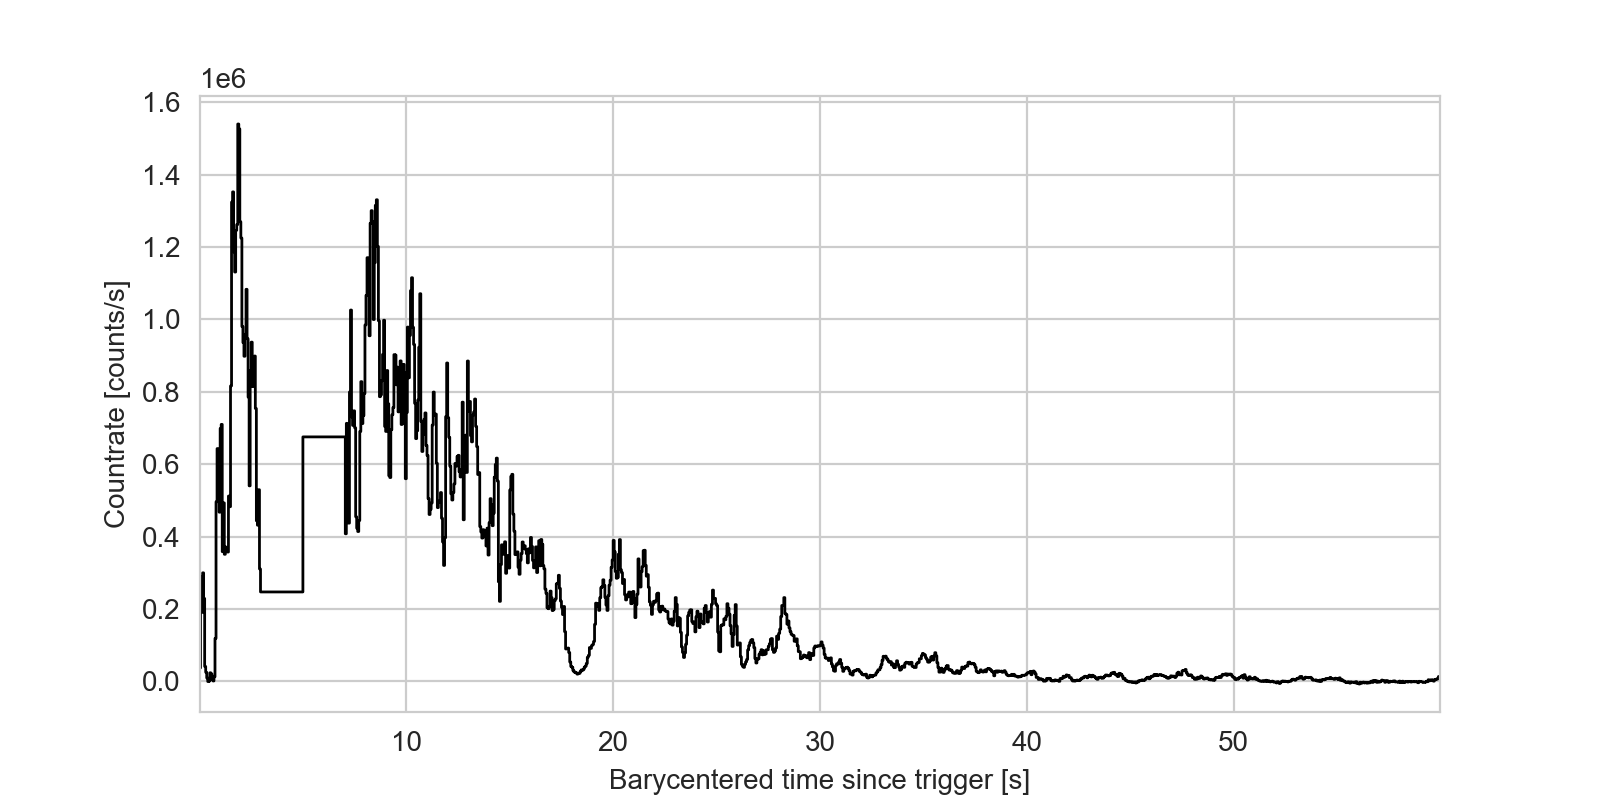

Text(0, 0.5, 'Countrate [counts/s]')

In [92]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

#lc = Lightcurve(barytime, counts-mean_bkg)
minind = barytime.searchsorted(0.0)
cutout_min = barytime.searchsorted(3.0)
cutout_max = barytime.searchsorted(7.0)
maxind = barytime.searchsorted(60.0)

t1 = barytime[minind:cutout_min]
t2 = barytime[cutout_max:maxind]
time = np.hstack([t1, t2])

c1 = counts[minind:cutout_min]
c2 = counts[cutout_max:maxind]
counts = np.hstack([c1, c2])

mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(time, counts-mean_bkg, dt=time[1]-time[0], skip_checks=True)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Countrate [counts/s]")


### INTEGRAL, Cutout, CARMA(2,1) Only

In [93]:
ns_cutout = NestedSampler(carma21_integral, constructor_kwargs={"num_live_points":1000, 
                                                         "max_samples":1e6})
ns_cutout.run(random.PRNGKey(2541), lc.time, y=lc.counts)


In [94]:
import pickle
with open(datadir + "integral_carma21_ns_cutout.pkl", "wb") as f:
    pickle.dump(ns, f)

In [95]:
samples_cutout, weights_cutout = ns_cutout.get_weighted_samples()

ns_cutout.print_summary()
logZ_carma_cutout = ns_cutout._results.log_Z_mean

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 4782964
# samples: 32000
# slices: 609000.0
# slices / acceptance: 21.0
# likelihood evals / sample: 149.5
# likelihood evals / slice: 7.8
--------
logZ=-10599.71 +- 0.16
H=11000.0
ESS=3480
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 5.82 +- 0.19 | 5.61 / 5.8 / 6.04 | 5.75 | 5.75
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 4.44 +- 0.22 | 4.2 / 4.41 / 4.72 | 4.29 | 4.29
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 10.722 +- 0.047 | 10.663 / 10.722 / 10.78 | 10.72 | 10.72
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 14.16 +- 0.19 | 13.96 / 14.13 / 14.4 | 14.03 | 14.03
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: -0.53 +- 0.19 | -0.81 

pred[110]: 5300.0 +- 1300.0 | 3700.0 / 5300.0 / 6900.0 | 5300.0 | 5300.0
pred[111]: 7800.0 +- 1300.0 | 6100.0 / 7800.0 / 9400.0 | 7800.0 | 7800.0
pred[112]: 1800.0 +- 1300.0 | 100.0 / 1800.0 / 3400.0 | 1800.0 | 1800.0
pred[113]: 2100.0 +- 1300.0 | 500.0 / 2100.0 / 3700.0 | 2100.0 | 2100.0
pred[114]: 8900.0 +- 1300.0 | 7300.0 / 8900.0 / 10500.0 | 9000.0 | 9000.0
pred[115]: 400.0 +- 1300.0 | -1200.0 / 400.0 / 2000.0 | 400.0 | 400.0
pred[116]: 600.0 +- 1300.0 | -1000.0 / 600.0 / 2200.0 | 600.0 | 600.0
pred[117]: 8800.0 +- 1300.0 | 7200.0 / 8800.0 / 10400.0 | 8900.0 | 8900.0
pred[118]: 7800.0 +- 1200.0 | 6200.0 / 7800.0 / 9300.0 | 7800.0 | 7800.0
pred[119]: -6600.0 +- 1200.0 | -8200.0 / -6600.0 / -5100.0 | -6600.0 | -6600.0
pred[120]: 2600.0 +- 1200.0 | 1000.0 / 2600.0 / 4100.0 | 2600.0 | 2600.0
pred[121]: 14400.0 +- 1200.0 | 12800.0 / 14400.0 / 15900.0 | 14400.0 | 14400.0
pred[122]: 7600.0 +- 1200.0 | 6100.0 / 7600.0 / 9200.0 | 7700.0 | 7700.0
pred[123]: 13500.0 +- 1200.0 | 12000.0 / 1350

pred[234]: -2000.0 +- 1100.0 | -3500.0 / -2000.0 / -600.0 | -1900.0 | -1900.0
pred[235]: -2400.0 +- 1100.0 | -3800.0 / -2400.0 / -1000.0 | -2300.0 | -2300.0
pred[236]: -2900.0 +- 1100.0 | -4300.0 / -2800.0 / -1500.0 | -2800.0 | -2800.0
pred[237]: -4000.0 +- 1100.0 | -5500.0 / -4000.0 / -2600.0 | -3900.0 | -3900.0
pred[238]: -2000.0 +- 1100.0 | -3400.0 / -1900.0 / -600.0 | -1900.0 | -1900.0
pred[239]: -2400.0 +- 1100.0 | -3800.0 / -2400.0 / -1000.0 | -2300.0 | -2300.0
pred[240]: -200.0 +- 1100.0 | -1600.0 / -100.0 / 1200.0 | -100.0 | -100.0
pred[241]: -1300.0 +- 1100.0 | -2700.0 / -1300.0 / 100.0 | -1200.0 | -1200.0
pred[242]: -3100.0 +- 1100.0 | -4600.0 / -3100.0 / -1700.0 | -3000.0 | -3000.0
pred[243]: -4000.0 +- 1100.0 | -5500.0 / -4000.0 / -2600.0 | -3900.0 | -3900.0
pred[244]: -3300.0 +- 1100.0 | -4800.0 / -3300.0 / -1900.0 | -3200.0 | -3200.0
pred[245]: -900.0 +- 1100.0 | -2400.0 / -900.0 / 500.0 | -800.0 | -800.0
pred[246]: -4300.0 +- 1100.0 | -5800.0 / -4300.0 / -2900.0 | -4200.

pred[377]: 200.0 +- 1000.0 | -1200.0 / 300.0 / 1500.0 | 400.0 | 400.0
pred[378]: 800.0 +- 1000.0 | -500.0 / 900.0 / 2100.0 | 1000.0 | 1000.0
pred[379]: 2300.0 +- 1000.0 | 900.0 / 2300.0 / 3500.0 | 2400.0 | 2400.0
pred[380]: 4200.0 +- 1000.0 | 2900.0 / 4300.0 / 5500.0 | 4400.0 | 4400.0
pred[381]: 3300.0 +- 1000.0 | 2000.0 / 3400.0 / 4600.0 | 3500.0 | 3500.0
pred[382]: 400.0 +- 1000.0 | -900.0 / 500.0 / 1700.0 | 600.0 | 600.0
pred[383]: 1600.0 +- 1000.0 | 300.0 / 1700.0 / 2900.0 | 1800.0 | 1800.0
pred[384]: 1600.0 +- 1000.0 | 300.0 / 1700.0 / 2800.0 | 1700.0 | 1700.0
pred[385]: -300.0 +- 1000.0 | -1600.0 / -200.0 / 900.0 | -100.0 | -100.0
pred[386]: -2200.0 +- 1000.0 | -3600.0 / -2200.0 / -1000.0 | -2100.0 | -2100.0
pred[387]: -2900.0 +- 1000.0 | -4300.0 / -2900.0 / -1700.0 | -2800.0 | -2800.0
pred[388]: -3600.0 +- 1000.0 | -4900.0 / -3500.0 / -2400.0 | -3400.0 | -3400.0
pred[389]: -2900.0 +- 1000.0 | -4200.0 / -2800.0 / -1700.0 | -2700.0 | -2700.0
pred[390]: -1600.0 +- 1000.0 | -2900.0 

pred[505]: 1330.0 +- 550.0 | 610.0 / 1400.0 / 1980.0 | 1450.0 | 1450.0
pred[506]: 1400.0 +- 550.0 | 680.0 / 1460.0 / 2040.0 | 1520.0 | 1520.0
pred[507]: 1130.0 +- 550.0 | 420.0 / 1190.0 / 1770.0 | 1250.0 | 1250.0
pred[508]: 1260.0 +- 540.0 | 550.0 / 1320.0 / 1900.0 | 1380.0 | 1380.0
pred[509]: 1890.0 +- 540.0 | 1190.0 / 1960.0 / 2520.0 | 2010.0 | 2010.0
pred[510]: 950.0 +- 540.0 | 240.0 / 1010.0 / 1570.0 | 1060.0 | 1060.0
pred[511]: 1820.0 +- 530.0 | 1120.0 / 1880.0 / 2440.0 | 1930.0 | 1930.0
pred[512]: 1550.0 +- 530.0 | 860.0 / 1620.0 / 2170.0 | 1670.0 | 1670.0
pred[513]: 1590.0 +- 520.0 | 900.0 / 1650.0 / 2200.0 | 1700.0 | 1700.0
pred[514]: 2640.0 +- 520.0 | 1960.0 / 2700.0 / 3250.0 | 2760.0 | 2760.0
pred[515]: 2940.0 +- 520.0 | 2260.0 / 3000.0 / 3540.0 | 3050.0 | 3050.0
pred[516]: 2910.0 +- 510.0 | 2230.0 / 2970.0 / 3500.0 | 3020.0 | 3020.0
pred[517]: 2970.0 +- 510.0 | 2310.0 / 3030.0 / 3560.0 | 3080.0 | 3080.0
pred[518]: 3030.0 +- 510.0 | 2370.0 / 3090.0 / 3620.0 | 3140.0 | 3140.0


pred[634]: 1470.0 +- 190.0 | 1230.0 / 1500.0 / 1670.0 | 1520.0 | 1520.0
pred[635]: 830.0 +- 190.0 | 590.0 / 860.0 / 1030.0 | 880.0 | 880.0
pred[636]: 850.0 +- 180.0 | 620.0 / 880.0 / 1050.0 | 900.0 | 900.0
pred[637]: 1390.0 +- 180.0 | 1160.0 / 1430.0 / 1590.0 | 1450.0 | 1450.0
pred[638]: 1230.0 +- 180.0 | 1000.0 / 1260.0 / 1420.0 | 1280.0 | 1280.0
pred[639]: 820.0 +- 180.0 | 590.0 / 850.0 / 1010.0 | 870.0 | 870.0
pred[640]: 1150.0 +- 180.0 | 920.0 / 1180.0 / 1330.0 | 1200.0 | 1200.0
pred[641]: 1390.0 +- 180.0 | 1170.0 / 1420.0 / 1580.0 | 1440.0 | 1440.0
pred[642]: 1730.0 +- 170.0 | 1510.0 / 1760.0 / 1910.0 | 1780.0 | 1780.0
pred[643]: 1790.0 +- 170.0 | 1570.0 / 1820.0 / 1970.0 | 1840.0 | 1840.0
pred[644]: 1290.0 +- 170.0 | 1080.0 / 1320.0 / 1470.0 | 1340.0 | 1340.0
pred[645]: 1160.0 +- 170.0 | 950.0 / 1190.0 / 1340.0 | 1210.0 | 1210.0
pred[646]: 1220.0 +- 170.0 | 1000.0 / 1250.0 / 1390.0 | 1260.0 | 1260.0
pred[647]: 1090.0 +- 160.0 | 870.0 / 1120.0 / 1260.0 | 1130.0 | 1130.0
pred[648]:

pred[767]: 82.0 +- 42.0 | 32.0 / 92.0 / 122.0 | 96.0 | 96.0
pred[768]: 127.0 +- 41.0 | 77.0 / 137.0 / 166.0 | 141.0 | 141.0
pred[769]: 104.0 +- 41.0 | 55.0 / 114.0 / 143.0 | 118.0 | 118.0
pred[770]: 49.0 +- 40.0 | 1.0 / 59.0 / 87.0 | 63.0 | 63.0
pred[771]: 142.0 +- 40.0 | 94.0 / 152.0 / 180.0 | 156.0 | 156.0
pred[772]: 279.0 +- 39.0 | 232.0 / 289.0 / 316.0 | 292.0 | 292.0
pred[773]: 418.0 +- 39.0 | 372.0 / 427.0 / 455.0 | 431.0 | 431.0
pred[774]: 415.0 +- 38.0 | 369.0 / 424.0 / 451.0 | 428.0 | 428.0
pred[775]: 576.0 +- 38.0 | 531.0 / 585.0 / 612.0 | 589.0 | 589.0
pred[776]: 665.0 +- 37.0 | 620.0 / 674.0 / 700.0 | 678.0 | 678.0
pred[777]: 612.0 +- 37.0 | 568.0 / 621.0 / 647.0 | 624.0 | 624.0
pred[778]: 451.0 +- 36.0 | 407.0 / 460.0 / 485.0 | 463.0 | 463.0
pred[779]: 642.0 +- 36.0 | 599.0 / 650.0 / 675.0 | 654.0 | 654.0
pred[780]: 823.0 +- 35.0 | 780.0 / 831.0 / 856.0 | 834.0 | 834.0
pred[781]: 671.0 +- 35.0 | 630.0 / 680.0 / 704.0 | 683.0 | 683.0
pred[782]: 576.0 +- 34.0 | 535.0 / 585.0

pred[895]: 353.1 +- 7.1 | 345.5 / 355.2 / 358.9 | 355.8 | 355.8
pred[896]: 249.3 +- 7.0 | 241.8 / 251.3 / 255.0 | 251.9 | 251.9
pred[897]: 211.4 +- 6.9 | 204.0 / 213.4 / 217.0 | 214.0 | 214.0
pred[898]: 211.6 +- 6.8 | 204.3 / 213.5 / 217.0 | 214.1 | 214.1
pred[899]: 255.7 +- 6.7 | 248.5 / 257.6 / 261.1 | 258.1 | 258.1
pred[900]: 147.8 +- 6.6 | 140.8 / 149.7 / 153.1 | 150.2 | 150.2
pred[901]: 191.9 +- 6.5 | 185.0 / 193.8 / 197.2 | 194.3 | 194.3
pred[902]: 494.1 +- 6.4 | 487.2 / 495.9 / 499.2 | 496.4 | 496.4
pred[903]: 568.2 +- 6.3 | 561.5 / 570.0 / 573.2 | 570.5 | 570.5
pred[904]: 546.3 +- 6.2 | 539.7 / 548.1 / 551.3 | 548.6 | 548.6
pred[905]: 578.4 +- 6.1 | 571.9 / 580.2 / 583.3 | 580.7 | 580.7
pred[906]: 688.5 +- 6.1 | 682.1 / 690.3 / 693.3 | 690.7 | 690.7
pred[907]: 540.7 +- 6.0 | 534.4 / 542.4 / 545.4 | 542.9 | 542.9
pred[908]: 786.8 +- 5.9 | 780.6 / 788.5 / 791.4 | 788.9 | 788.9
pred[909]: 984.9 +- 5.8 | 978.8 / 986.5 / 989.4 | 987.0 | 987.0
pred[910]: 907.0 +- 5.7 | 901.0 / 908.7 

pred[1040]: -223.48 +- 0.7 | -224.08 / -223.27 / -223.05 | -223.23 | -223.23
pred[1041]: -349.5 +- 0.69 | -350.08 / -349.29 / -349.07 | -349.25 | -349.25
pred[1042]: -113.47 +- 0.68 | -114.04 / -113.26 / -113.05 | -113.22 | -113.22
pred[1043]: -251.47 +- 0.66 | -252.03 / -251.26 / -251.06 | -251.23 | -251.23
pred[1044]: -153.45 +- 0.65 | -154.0 / -153.25 / -153.05 | -153.21 | -153.21
pred[1045]: -89.44 +- 0.64 | -89.98 / -89.24 / -89.05 | -89.21 | -89.21
pred[1046]: -207.44 +- 0.63 | -207.97 / -207.24 / -207.05 | -207.21 | -207.21
pred[1047]: -123.42 +- 0.62 | -123.94 / -123.23 / -123.04 | -123.2 | -123.2
pred[1048]: -191.42 +- 0.61 | -191.93 / -191.23 / -191.04 | -191.2 | -191.2
pred[1049]: -229.41 +- 0.6 | -229.91 / -229.23 / -229.04 | -229.19 | -229.19
pred[1050]: -127.4 +- 0.59 | -127.89 / -127.21 / -127.04 | -127.18 | -127.18
pred[1051]: -191.39 +- 0.58 | -191.87 / -191.22 / -191.04 | -191.18 | -191.18
pred[1052]: -37.38 +- 0.57 | -37.85 / -37.21 / -37.04 | -37.18 | -37.18
pred[10

In [96]:
print(logZ_carma_cutout)

-10599.714724569956


### INTEGRAL, Cutout, CARMA + QPO

In [113]:
ns_qpo_cutout = NestedSampler(carma21_integral_with_qpo, constructor_kwargs={"num_live_points":2000, 
                                                         "max_samples":1e6})
ns_qpo_cutout.run(random.PRNGKey(2864), lc.time, y=lc.counts)


In [98]:
with open(datadir + "integral_carma21_qpo_ns_cutout.pkl", "wb") as f:
    pickle.dump(ns_qpo, f)

In [106]:
samples_qpo_cutout, weights_qpo_cutout = ns_qpo_cutout.get_weighted_samples()

ns_qpo_cutout.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 11717656
# samples: 70000
# slices: 1860000.0
# slices / acceptance: 30.0
# likelihood evals / sample: 167.4
# likelihood evals / slice: 6.3
--------
logZ=-10600.94 +- 0.11
H=11000.0
ESS=7556
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 5.84 +- 0.26 | 5.62 / 5.82 / 6.07 | 5.98 | 5.98
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 4.45 +- 0.3 | 4.19 / 4.41 / 4.72 | 4.26 | 4.26
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 10.718 +- 0.051 | 10.653 / 10.721 / 10.779 | 10.683 | 10.683
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 3.5 +- 1.9 | 1.6 / 2.8 / 7.2 | 8.1 | 8.1
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 14.17 +- 0.27 | 13.96 / 14.1

pred[109]: 9300.0 +- 1400.0 | 7600.0 / 9200.0 / 11100.0 | 10100.0 | 10100.0
pred[110]: 5400.0 +- 1400.0 | 3700.0 / 5300.0 / 7100.0 | 6100.0 | 6100.0
pred[111]: 7800.0 +- 1400.0 | 6100.0 / 7800.0 / 9600.0 | 8600.0 | 8600.0
pred[112]: 1800.0 +- 1400.0 | 100.0 / 1800.0 / 3600.0 | 2600.0 | 2600.0
pred[113]: 2100.0 +- 1400.0 | 500.0 / 2100.0 / 3900.0 | 2900.0 | 2900.0
pred[114]: 9000.0 +- 1400.0 | 7300.0 / 8900.0 / 10700.0 | 9700.0 | 9700.0
pred[115]: 400.0 +- 1400.0 | -1200.0 / 400.0 / 2200.0 | 1200.0 | 1200.0
pred[116]: 700.0 +- 1400.0 | -1000.0 / 600.0 / 2400.0 | 1400.0 | 1400.0
pred[117]: 8900.0 +- 1300.0 | 7200.0 / 8800.0 / 10600.0 | 9600.0 | 9600.0
pred[118]: 7800.0 +- 1300.0 | 6200.0 / 7800.0 / 9500.0 | 8500.0 | 8500.0
pred[119]: -6600.0 +- 1300.0 | -8200.0 / -6600.0 / -4900.0 | -5900.0 | -5900.0
pred[120]: 2600.0 +- 1300.0 | 1000.0 / 2600.0 / 4300.0 | 3300.0 | 3300.0
pred[121]: 14400.0 +- 1300.0 | 12800.0 / 14400.0 / 16100.0 | 15100.0 | 15100.0
pred[122]: 7700.0 +- 1300.0 | 6100.0 /

pred[245]: -900.0 +- 1200.0 | -2400.0 / -900.0 / 600.0 | -1200.0 | -1200.0
pred[246]: -4300.0 +- 1200.0 | -5800.0 / -4300.0 / -2800.0 | -4600.0 | -4600.0
pred[247]: -2100.0 +- 1200.0 | -3600.0 / -2100.0 / -600.0 | -2500.0 | -2500.0
pred[248]: 300.0 +- 1200.0 | -1200.0 / 300.0 / 1800.0 | -100.0 | -100.0
pred[249]: -3000.0 +- 1200.0 | -4500.0 / -3000.0 / -1500.0 | -3400.0 | -3400.0
pred[250]: 700.0 +- 1200.0 | -800.0 / 700.0 / 2200.0 | 300.0 | 300.0
pred[251]: 200.0 +- 1200.0 | -1400.0 / 200.0 / 1700.0 | -200.0 | -200.0
pred[252]: -2600.0 +- 1200.0 | -4200.0 / -2600.0 / -1100.0 | -3000.0 | -3000.0
pred[253]: -3000.0 +- 1200.0 | -4500.0 / -3000.0 / -1500.0 | -3400.0 | -3400.0
pred[254]: -5700.0 +- 1200.0 | -7200.0 / -5700.0 / -4100.0 | -6100.0 | -6100.0
pred[255]: -6100.0 +- 1200.0 | -7700.0 / -6100.0 / -4600.0 | -6600.0 | -6600.0
pred[256]: -8000.0 +- 1200.0 | -9600.0 / -8000.0 / -6500.0 | -8400.0 | -8400.0
pred[257]: -8000.0 +- 1200.0 | -9600.0 / -8000.0 / -6500.0 | -8500.0 | -8500.0
pr

pred[373]: 800.0 +- 1100.0 | -600.0 / 900.0 / 2200.0 | 200.0 | 200.0
pred[374]: 400.0 +- 1100.0 | -1100.0 / 400.0 / 1700.0 | -300.0 | -300.0
pred[375]: 300.0 +- 1100.0 | -1200.0 / 300.0 / 1600.0 | -300.0 | -300.0
pred[376]: 1000.0 +- 1100.0 | -400.0 / 1100.0 / 2400.0 | 400.0 | 400.0
pred[377]: 200.0 +- 1100.0 | -1200.0 / 300.0 / 1600.0 | -400.0 | -400.0
pred[378]: 900.0 +- 1100.0 | -600.0 / 900.0 / 2200.0 | 200.0 | 200.0
pred[379]: 2300.0 +- 1100.0 | 900.0 / 2400.0 / 3700.0 | 1700.0 | 1700.0
pred[380]: 4200.0 +- 1100.0 | 2800.0 / 4300.0 / 5600.0 | 3600.0 | 3600.0
pred[381]: 3400.0 +- 1100.0 | 1900.0 / 3400.0 / 4700.0 | 2700.0 | 2700.0
pred[382]: 400.0 +- 1100.0 | -1000.0 / 500.0 / 1800.0 | -200.0 | -200.0
pred[383]: 1700.0 +- 1100.0 | 300.0 / 1700.0 / 3000.0 | 1100.0 | 1100.0
pred[384]: 1600.0 +- 1100.0 | 200.0 / 1700.0 / 2900.0 | 1000.0 | 1000.0
pred[385]: -300.0 +- 1100.0 | -1700.0 / -200.0 / 1100.0 | -900.0 | -900.0
pred[386]: -2200.0 +- 1100.0 | -3600.0 / -2200.0 / -900.0 | -2800.0

pred[500]: 1800.0 +- 610.0 | 1000.0 / 1870.0 / 2510.0 | 1450.0 | 1450.0
pred[501]: 870.0 +- 610.0 | 80.0 / 930.0 / 1570.0 | 520.0 | 520.0
pred[502]: 990.0 +- 600.0 | 200.0 / 1060.0 / 1690.0 | 640.0 | 640.0
pred[503]: 1130.0 +- 600.0 | 350.0 / 1200.0 / 1820.0 | 780.0 | 780.0
pred[504]: 1450.0 +- 590.0 | 680.0 / 1520.0 / 2140.0 | 1110.0 | 1110.0
pred[505]: 1340.0 +- 590.0 | 570.0 / 1410.0 / 2020.0 | 1000.0 | 1000.0
pred[506]: 1410.0 +- 590.0 | 650.0 / 1480.0 / 2090.0 | 1070.0 | 1070.0
pred[507]: 1140.0 +- 580.0 | 380.0 / 1210.0 / 1810.0 | 810.0 | 810.0
pred[508]: 1270.0 +- 580.0 | 520.0 / 1340.0 / 1940.0 | 940.0 | 940.0
pred[509]: 1900.0 +- 570.0 | 1150.0 / 1970.0 / 2560.0 | 1570.0 | 1570.0
pred[510]: 960.0 +- 570.0 | 210.0 / 1020.0 / 1610.0 | 630.0 | 630.0
pred[511]: 1830.0 +- 570.0 | 1090.0 / 1890.0 / 2480.0 | 1500.0 | 1500.0
pred[512]: 1560.0 +- 560.0 | 830.0 / 1630.0 / 2210.0 | 1240.0 | 1240.0
pred[513]: 1600.0 +- 560.0 | 870.0 / 1660.0 / 2240.0 | 1280.0 | 1280.0
pred[514]: 2650.0 +-

pred[629]: 2470.0 +- 210.0 | 2200.0 / 2510.0 / 2700.0 | 2360.0 | 2360.0
pred[630]: 3040.0 +- 210.0 | 2770.0 / 3080.0 / 3260.0 | 2930.0 | 2930.0
pred[631]: 3500.0 +- 210.0 | 3240.0 / 3540.0 / 3720.0 | 3390.0 | 3390.0
pred[632]: 3070.0 +- 200.0 | 2810.0 / 3110.0 / 3290.0 | 2960.0 | 2960.0
pred[633]: 2130.0 +- 200.0 | 1870.0 / 2170.0 / 2340.0 | 2020.0 | 2020.0
pred[634]: 1470.0 +- 200.0 | 1210.0 / 1510.0 / 1680.0 | 1360.0 | 1360.0
pred[635]: 830.0 +- 200.0 | 580.0 / 870.0 / 1050.0 | 730.0 | 730.0
pred[636]: 850.0 +- 200.0 | 600.0 / 890.0 / 1060.0 | 750.0 | 750.0
pred[637]: 1400.0 +- 190.0 | 1150.0 / 1430.0 / 1600.0 | 1290.0 | 1290.0
pred[638]: 1230.0 +- 190.0 | 990.0 / 1270.0 / 1440.0 | 1130.0 | 1130.0
pred[639]: 820.0 +- 190.0 | 580.0 / 860.0 / 1030.0 | 720.0 | 720.0
pred[640]: 1150.0 +- 190.0 | 910.0 / 1180.0 / 1350.0 | 1050.0 | 1050.0
pred[641]: 1390.0 +- 190.0 | 1150.0 / 1430.0 / 1590.0 | 1290.0 | 1290.0
pred[642]: 1730.0 +- 180.0 | 1490.0 / 1770.0 / 1930.0 | 1630.0 | 1630.0
pred[643]

pred[756]: 514.0 +- 51.0 | 451.0 / 527.0 / 562.0 | 491.0 | 491.0
pred[757]: 587.0 +- 51.0 | 525.0 / 600.0 / 635.0 | 564.0 | 564.0
pred[758]: 826.0 +- 50.0 | 765.0 / 839.0 / 873.0 | 804.0 | 804.0
pred[759]: 713.0 +- 49.0 | 653.0 / 726.0 / 760.0 | 691.0 | 691.0
pred[760]: 768.0 +- 49.0 | 709.0 / 781.0 / 814.0 | 747.0 | 747.0
pred[761]: 458.0 +- 48.0 | 399.0 / 470.0 / 503.0 | 436.0 | 436.0
pred[762]: 463.0 +- 48.0 | 405.0 / 475.0 / 508.0 | 442.0 | 442.0
pred[763]: 198.0 +- 47.0 | 141.0 / 210.0 / 242.0 | 177.0 | 177.0
pred[764]: -1.0 +- 46.0 | -58.0 / 11.0 / 43.0 | -21.0 | -21.0
pred[765]: 86.0 +- 46.0 | 30.0 / 98.0 / 129.0 | 66.0 | 66.0
pred[766]: -19.0 +- 45.0 | -74.0 / -7.0 / 24.0 | -39.0 | -39.0
pred[767]: 82.0 +- 45.0 | 28.0 / 94.0 / 124.0 | 63.0 | 63.0
pred[768]: 127.0 +- 44.0 | 74.0 / 138.0 / 168.0 | 108.0 | 108.0
pred[769]: 104.0 +- 44.0 | 51.0 / 115.0 / 145.0 | 85.0 | 85.0
pred[770]: 49.0 +- 43.0 | -3.0 / 60.0 / 89.0 | 30.0 | 30.0
pred[771]: 142.0 +- 43.0 | 91.0 / 153.0 / 182.0 | 

pred[888]: 752.0 +- 8.8 | 742.6 / 754.6 / 758.8 | 749.2 | 749.2
pred[889]: 632.2 +- 8.6 | 623.0 / 634.7 / 638.8 | 629.5 | 629.5
pred[890]: 466.3 +- 8.5 | 457.3 / 468.8 / 472.9 | 463.7 | 463.7
pred[891]: 328.5 +- 8.4 | 319.6 / 330.9 / 334.9 | 325.9 | 325.9
pred[892]: 448.6 +- 8.3 | 439.9 / 451.0 / 455.0 | 446.1 | 446.1
pred[893]: 390.8 +- 8.2 | 382.2 / 393.2 / 397.0 | 388.3 | 388.3
pred[894]: 482.9 +- 8.0 | 474.4 / 485.3 / 489.0 | 480.4 | 480.4
pred[895]: 353.1 +- 7.9 | 344.7 / 355.4 / 359.1 | 350.6 | 350.6
pred[896]: 249.2 +- 7.8 | 241.0 / 251.5 / 255.1 | 246.8 | 246.8
pred[897]: 211.3 +- 7.7 | 203.3 / 213.6 / 217.2 | 209.0 | 209.0
pred[898]: 211.5 +- 7.6 | 203.5 / 213.7 / 217.2 | 209.2 | 209.2
pred[899]: 255.6 +- 7.5 | 247.8 / 257.8 / 261.3 | 253.4 | 253.4
pred[900]: 147.7 +- 7.4 | 140.0 / 149.9 / 153.3 | 145.5 | 145.5
pred[901]: 191.9 +- 7.3 | 184.3 / 194.0 / 197.3 | 189.7 | 189.7
pred[902]: 494.0 +- 7.1 | 486.5 / 496.1 / 499.4 | 491.9 | 491.9
pred[903]: 568.1 +- 7.0 | 560.8 / 570.2 

pred[1019]: 380.2 +- 1.2 | 379.3 / 380.6 / 380.9 | 380.0 | 380.0
pred[1020]: 350.2 +- 1.2 | 349.3 / 350.6 / 350.9 | 350.0 | 350.0
pred[1021]: 268.3 +- 1.1 | 267.3 / 268.6 / 268.9 | 268.1 | 268.1
pred[1022]: 502.2 +- 1.1 | 501.3 / 502.6 / 502.9 | 502.1 | 502.1
pred[1023]: 154.3 +- 1.1 | 153.4 / 154.6 / 154.9 | 154.1 | 154.1
pred[1024]: 280.3 +- 1.1 | 279.4 / 280.6 / 280.9 | 280.1 | 280.1
pred[1025]: 86.3 +- 1.1 | 85.5 / 86.6 / 86.9 | 86.1 | 86.1
pred[1026]: 92.3 +- 1.1 | 91.5 / 92.6 / 92.9 | 92.2 | 92.2
pred[1027]: -15.7 +- 1.0 | -16.5 / -15.4 / -15.1 | -15.8 | -15.8
pred[1028]: -121.6 +- 1.0 | -122.5 / -121.3 / -121.1 | -121.8 | -121.8
pred[1029]: -163.6 +- 1.0 | -164.4 / -163.3 / -163.1 | -163.8 | -163.8
pred[1030]: -49.62 +- 0.99 | -50.4 / -49.33 / -49.06 | -49.77 | -49.77
pred[1031]: -87.61 +- 0.98 | -88.37 / -87.32 / -87.06 | -87.76 | -87.76
pred[1032]: -231.6 +- 0.96 | -232.36 / -231.32 / -231.07 | -231.75 | -231.75
pred[1033]: -59.58 +- 0.94 | -60.32 / -59.31 / -59.06 | -59.72 | 

<IPython.core.display.Javascript object>


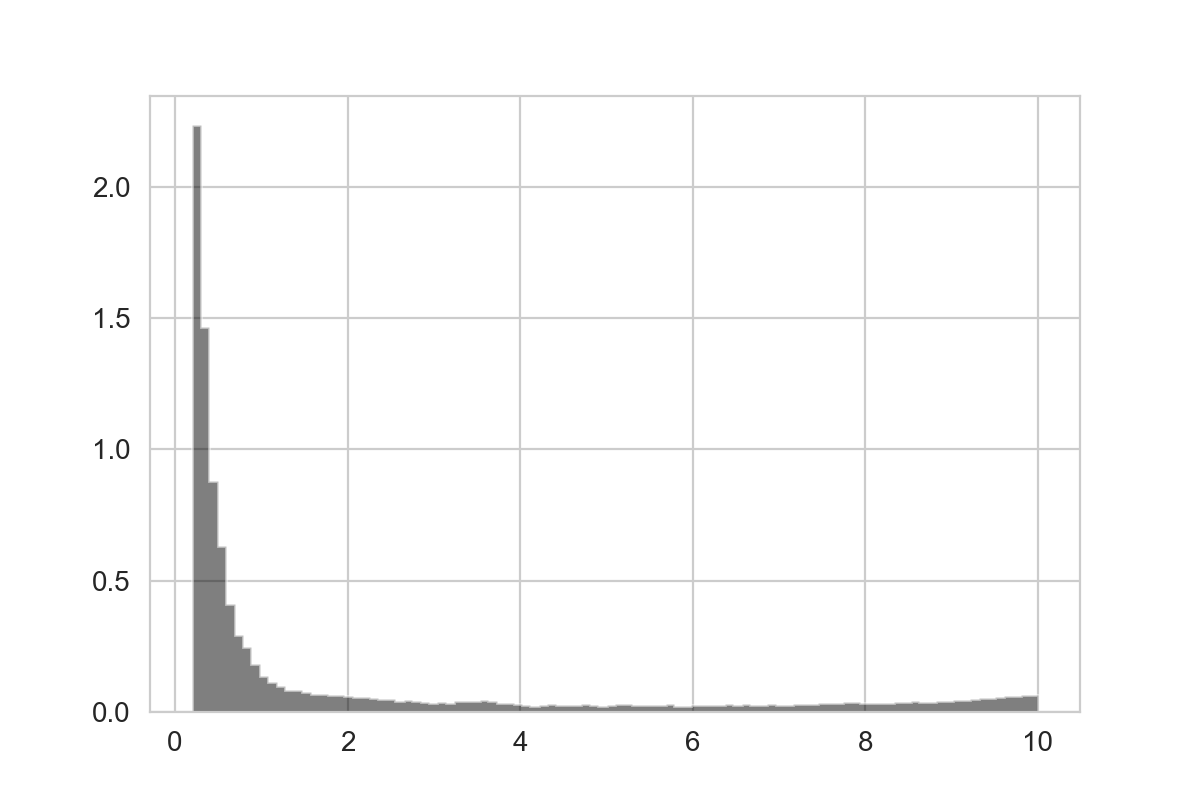

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
freq_post_cutout = np.exp(samples_qpo_cutout["log_omega"])/(2.*np.pi)
ax.hist(1/freq_post_cutout, bins=100, histtype="stepfilled", alpha=0.5, color="black", 
        density=True);


## Fermi/GBM Data: NaI Detectors

Let's do the same for the Fermi/GBM data:

In [32]:
na_filename = "bn230307656_na_mete.sav"
bgo_filename = "bn230307656_b1_mete.sav"

data = scipy.io.readsav(datadir+na_filename)
data

{'tte_na_time': array([6.99896627e+08, 6.99896627e+08, 6.99896627e+08, ...,
        6.99896772e+08, 6.99896772e+08, 6.99896772e+08], dtype='>f8'),
 'na_barytime': array([6.99896606e+08, 6.99896606e+08, 6.99896606e+08, ...,
        6.99896751e+08, 6.99896751e+08, 6.99896751e+08], dtype='>f8'),
 'btime': 699896651.671248}

In [55]:
barytime = np.array(data["na_barytime"], dtype=float)
#counts = np.array(data["counts"], dtype=float)

trigtime = data["btime"]

barytime -= trigtime -21

In [64]:
np.log(np.max(lc_na.counts))

7.834788107388195

INFO[2023-10-12 12:43:27,396]: make_lightcurve: tseg: 144.99889838695526
INFO[2023-10-12 12:43:27,397]: make_lightcurve: timebin:  2900


4569.8


<IPython.core.display.Javascript object>


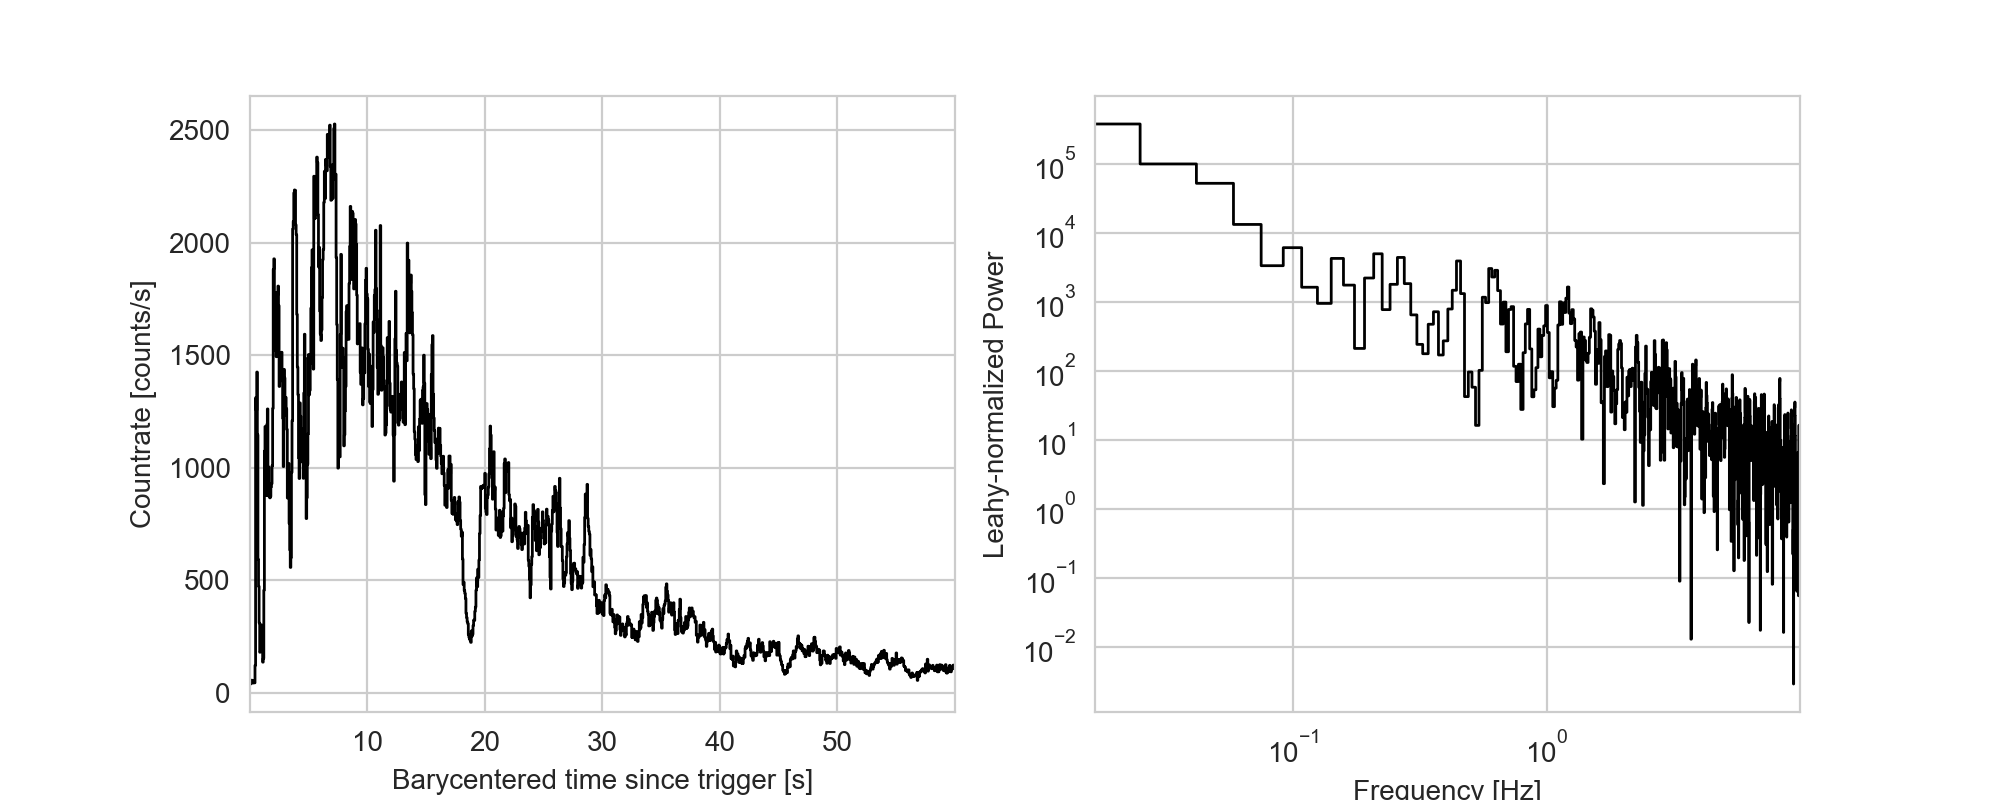

Text(0, 0.5, 'Leahy-normalized Power')

In [56]:
lc_na = Lightcurve.make_lightcurve(barytime, dt=lc.dt)

# calculate background flux
mean_bkg = np.mean(counts[-100:])
print(mean_bkg)

minind = lc_na.time.searchsorted(0.0)
maxind = lc_na.time.searchsorted(60.0)
lc_na = lc_na.truncate(start=minind, stop=maxind, method="index")

# calculate periodogram for comparison:
ps_na = Powerspectrum(lc_na, norm="leahy")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_na.time, lc_na.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_na.time[0], lc_na.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps_na.freq, ps_na.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps_na.freq[0], ps_na.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [ ]:
mean_bkg = np.log(np.mean(lc_na.counts[-100:]))

def carma21_fermina(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(6, 8.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [67]:
npoints = len(lc_na.time)
ns_na = NestedSampler(carma21_fermina)
ns_na.run(random.PRNGKey(200), lc_na.time, y=lc_na.counts)

In [68]:
import pickle
with open(datadir + "fermi_na_carma21_ns.pkl", "wb") as f:
    pickle.dump(ns_na, f)

In [8]:
#import pickle
#with open(datadir + "fermi_na_carma21_ns.pkl", "rb") as f:
#    ns_na = pickle.load(f)

In [69]:
samples, weights = ns_na.get_weighted_samples()

ns_na.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 973780
# samples: 6600
# slices: 139200.0
# slices / acceptance: 24.0
# likelihood evals / sample: 147.5
# likelihood evals / slice: 7.0
--------
logZ=-7274.42 +- 0.34
H=7300.0
ESS=661
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 4.6 +- 0.14 | 4.43 / 4.62 / 4.75 | 4.69 | 4.69
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 3.49 +- 0.11 | 3.36 / 3.49 / 3.63 | 3.49 | 3.49
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.323 +- 0.056 | 7.269 / 7.323 / 7.381 | 7.314 | 7.314
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 9.885 +- 0.078 | 9.781 / 9.881 / 9.985 | 9.873 | 9.873
--------
log_const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_const: 5.1 +- 0.2 | 4.84 / 5.13 

pred[116]: 454.0 +- 79.0 | 371.0 / 457.0 / 541.0 | 514.0 | 514.0
pred[117]: 277.0 +- 79.0 | 193.0 / 280.0 / 365.0 | 338.0 | 338.0
pred[118]: 245.0 +- 79.0 | 163.0 / 247.0 / 330.0 | 306.0 | 306.0
pred[119]: 56.0 +- 79.0 | -27.0 / 60.0 / 143.0 | 118.0 | 118.0
pred[120]: -67.0 +- 79.0 | -150.0 / -63.0 / 19.0 | -5.0 | -5.0
pred[121]: -95.0 +- 79.0 | -179.0 / -92.0 / -9.0 | -33.0 | -33.0
pred[122]: -42.0 +- 79.0 | -125.0 / -39.0 / 45.0 | 21.0 | 21.0
pred[123]: 94.0 +- 79.0 | 11.0 / 97.0 / 181.0 | 158.0 | 158.0
pred[124]: 239.0 +- 79.0 | 156.0 / 243.0 / 326.0 | 303.0 | 303.0
pred[125]: 337.0 +- 79.0 | 254.0 / 340.0 / 423.0 | 401.0 | 401.0
pred[126]: 505.0 +- 79.0 | 422.0 / 509.0 / 592.0 | 570.0 | 570.0
pred[127]: 609.0 +- 79.0 | 525.0 / 613.0 / 695.0 | 674.0 | 674.0
pred[128]: 590.0 +- 79.0 | 507.0 / 594.0 / 677.0 | 655.0 | 655.0
pred[129]: 671.0 +- 79.0 | 587.0 / 676.0 / 756.0 | 736.0 | 736.0
pred[130]: 684.0 +- 79.0 | 600.0 / 687.0 / 769.0 | 749.0 | 749.0
pred[131]: 695.0 +- 79.0 | 612.0 /

pred[375]: -737.0 +- 57.0 | -808.0 / -739.0 / -670.0 | -749.0 | -749.0
pred[376]: -738.0 +- 57.0 | -809.0 / -740.0 / -671.0 | -751.0 | -751.0
pred[377]: -690.0 +- 57.0 | -761.0 / -692.0 / -622.0 | -703.0 | -703.0
pred[378]: -704.0 +- 57.0 | -775.0 / -706.0 / -636.0 | -718.0 | -718.0
pred[379]: -694.0 +- 57.0 | -765.0 / -696.0 / -625.0 | -708.0 | -708.0
pred[380]: -652.0 +- 57.0 | -724.0 / -655.0 / -584.0 | -667.0 | -667.0
pred[381]: -626.0 +- 57.0 | -697.0 / -628.0 / -558.0 | -641.0 | -641.0
pred[382]: -621.0 +- 57.0 | -692.0 / -623.0 / -553.0 | -636.0 | -636.0
pred[383]: -581.0 +- 57.0 | -653.0 / -583.0 / -513.0 | -597.0 | -597.0
pred[384]: -553.0 +- 57.0 | -624.0 / -556.0 / -485.0 | -570.0 | -570.0
pred[385]: -478.0 +- 57.0 | -549.0 / -480.0 / -410.0 | -495.0 | -495.0
pred[386]: -427.0 +- 58.0 | -498.0 / -429.0 / -358.0 | -444.0 | -444.0
pred[387]: -446.0 +- 58.0 | -517.0 / -448.0 / -377.0 | -464.0 | -464.0
pred[388]: -386.0 +- 58.0 | -458.0 / -388.0 / -317.0 | -404.0 | -404.0
pred[3

pred[619]: -6.0 +- 45.0 | -63.0 / -5.0 / 48.0 | -50.0 | -50.0
pred[620]: -23.0 +- 45.0 | -79.0 / -21.0 / 32.0 | -66.0 | -66.0
pred[621]: -58.0 +- 45.0 | -114.0 / -56.0 / -3.0 | -101.0 | -101.0
pred[622]: -84.0 +- 45.0 | -140.0 / -82.0 / -29.0 | -127.0 | -127.0
pred[623]: -69.0 +- 45.0 | -125.0 / -68.0 / -15.0 | -112.0 | -112.0
pred[624]: -37.0 +- 45.0 | -93.0 / -36.0 / 17.0 | -80.0 | -80.0
pred[625]: -2.0 +- 44.0 | -58.0 / -1.0 / 52.0 | -44.0 | -44.0
pred[626]: -30.0 +- 44.0 | -86.0 / -29.0 / 24.0 | -72.0 | -72.0
pred[627]: -6.0 +- 44.0 | -61.0 / -4.0 / 48.0 | -48.0 | -48.0
pred[628]: -19.0 +- 44.0 | -74.0 / -17.0 / 35.0 | -60.0 | -60.0
pred[629]: -5.0 +- 44.0 | -60.0 / -4.0 / 49.0 | -47.0 | -47.0
pred[630]: -55.0 +- 44.0 | -110.0 / -53.0 / -1.0 | -96.0 | -96.0
pred[631]: -77.0 +- 43.0 | -132.0 / -76.0 / -24.0 | -119.0 | -119.0
pred[632]: -36.0 +- 43.0 | -91.0 / -36.0 / 17.0 | -78.0 | -78.0
pred[633]: -54.0 +- 43.0 | -108.0 / -53.0 / -1.0 | -95.0 | -95.0
pred[634]: -29.0 +- 43.0 | -83.

pred[858]: -20.0 +- 26.0 | -57.0 / -18.0 / 12.0 | -15.0 | -15.0
pred[859]: -16.0 +- 26.0 | -53.0 / -14.0 / 15.0 | -11.0 | -11.0
pred[860]: -24.0 +- 26.0 | -61.0 / -21.0 / 8.0 | -19.0 | -19.0
pred[861]: -20.0 +- 26.0 | -57.0 / -17.0 / 12.0 | -14.0 | -14.0
pred[862]: -22.0 +- 26.0 | -59.0 / -19.0 / 10.0 | -16.0 | -16.0
pred[863]: -8.0 +- 26.0 | -45.0 / -5.0 / 23.0 | -2.0 | -2.0
pred[864]: 22.0 +- 26.0 | -15.0 / 25.0 / 54.0 | 28.0 | 28.0
pred[865]: 16.0 +- 26.0 | -21.0 / 19.0 / 47.0 | 22.0 | 22.0
pred[866]: 48.0 +- 26.0 | 11.0 / 51.0 / 80.0 | 54.0 | 54.0
pred[867]: 30.0 +- 26.0 | -8.0 / 32.0 / 61.0 | 36.0 | 36.0
pred[868]: 5.0 +- 26.0 | -33.0 / 8.0 / 36.0 | 11.0 | 11.0
pred[869]: -5.0 +- 26.0 | -43.0 / -3.0 / 26.0 | 1.0 | 1.0
pred[870]: 23.0 +- 26.0 | -15.0 / 25.0 / 54.0 | 29.0 | 29.0
pred[871]: 19.0 +- 26.0 | -18.0 / 22.0 / 51.0 | 26.0 | 26.0
pred[872]: 36.0 +- 26.0 | -2.0 / 38.0 / 67.0 | 43.0 | 43.0
pred[873]: 22.0 +- 26.0 | -15.0 / 25.0 / 54.0 | 29.0 | 29.0
pred[874]: -1.0 +- 26.0 | -3

pred[1076]: -10.0 +- 30.0 | -54.0 / -11.0 / 31.0 | 12.0 | 12.0
pred[1077]: -6.0 +- 30.0 | -50.0 / -7.0 / 35.0 | 16.0 | 16.0
pred[1078]: -3.0 +- 30.0 | -47.0 / -4.0 / 37.0 | 19.0 | 19.0
pred[1079]: 18.0 +- 30.0 | -26.0 / 16.0 / 59.0 | 40.0 | 40.0
pred[1080]: -13.0 +- 30.0 | -57.0 / -14.0 / 28.0 | 9.0 | 9.0
pred[1081]: -10.0 +- 30.0 | -54.0 / -11.0 / 31.0 | 12.0 | 12.0
pred[1082]: -15.0 +- 30.0 | -59.0 / -16.0 / 26.0 | 7.0 | 7.0
pred[1083]: 4.0 +- 30.0 | -40.0 / 3.0 / 45.0 | 26.0 | 26.0
pred[1084]: -22.0 +- 30.0 | -65.0 / -23.0 / 19.0 | 1.0 | 1.0
pred[1085]: -33.0 +- 30.0 | -77.0 / -34.0 / 8.0 | -11.0 | -11.0
pred[1086]: -39.0 +- 30.0 | -83.0 / -40.0 / 1.0 | -17.0 | -17.0
pred[1087]: -46.0 +- 30.0 | -90.0 / -47.0 / -5.0 | -23.0 | -23.0
pred[1088]: -41.0 +- 30.0 | -85.0 / -42.0 / -0.0 | -19.0 | -19.0
pred[1089]: -63.0 +- 30.0 | -107.0 / -64.0 / -23.0 | -41.0 | -41.0
pred[1090]: -49.0 +- 30.0 | -93.0 / -50.0 / -8.0 | -26.0 | -26.0
pred[1091]: -53.0 +- 30.0 | -97.0 / -54.0 / -12.0 | -30.0 |

<IPython.core.display.Javascript object>


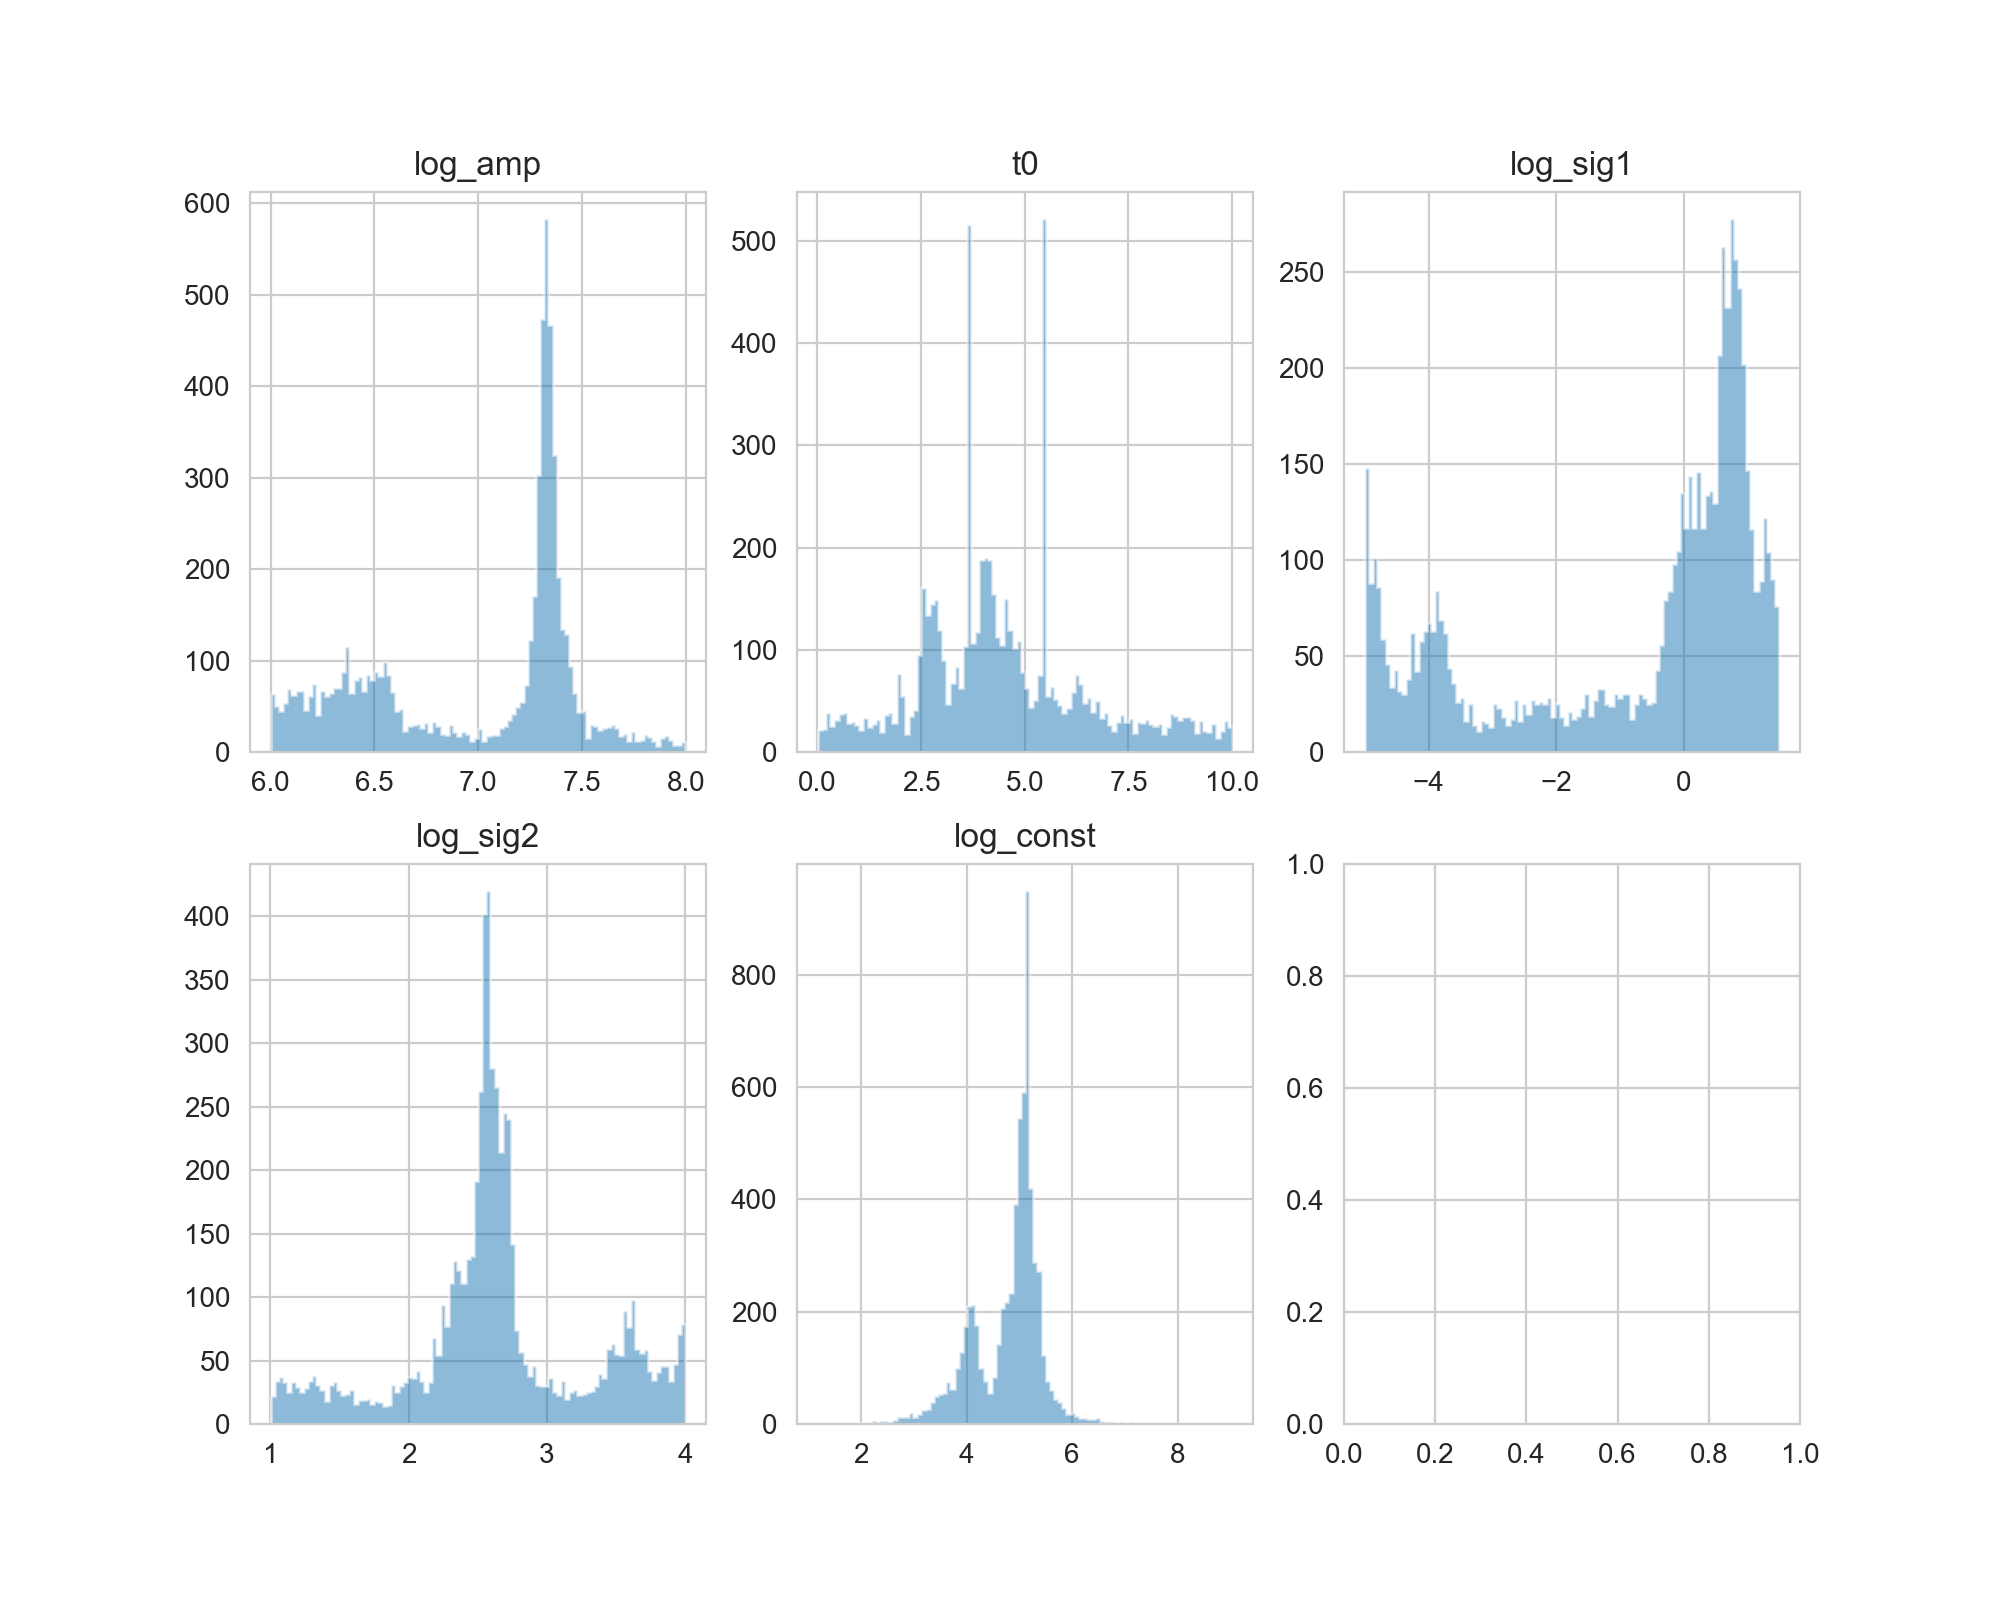

In [70]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


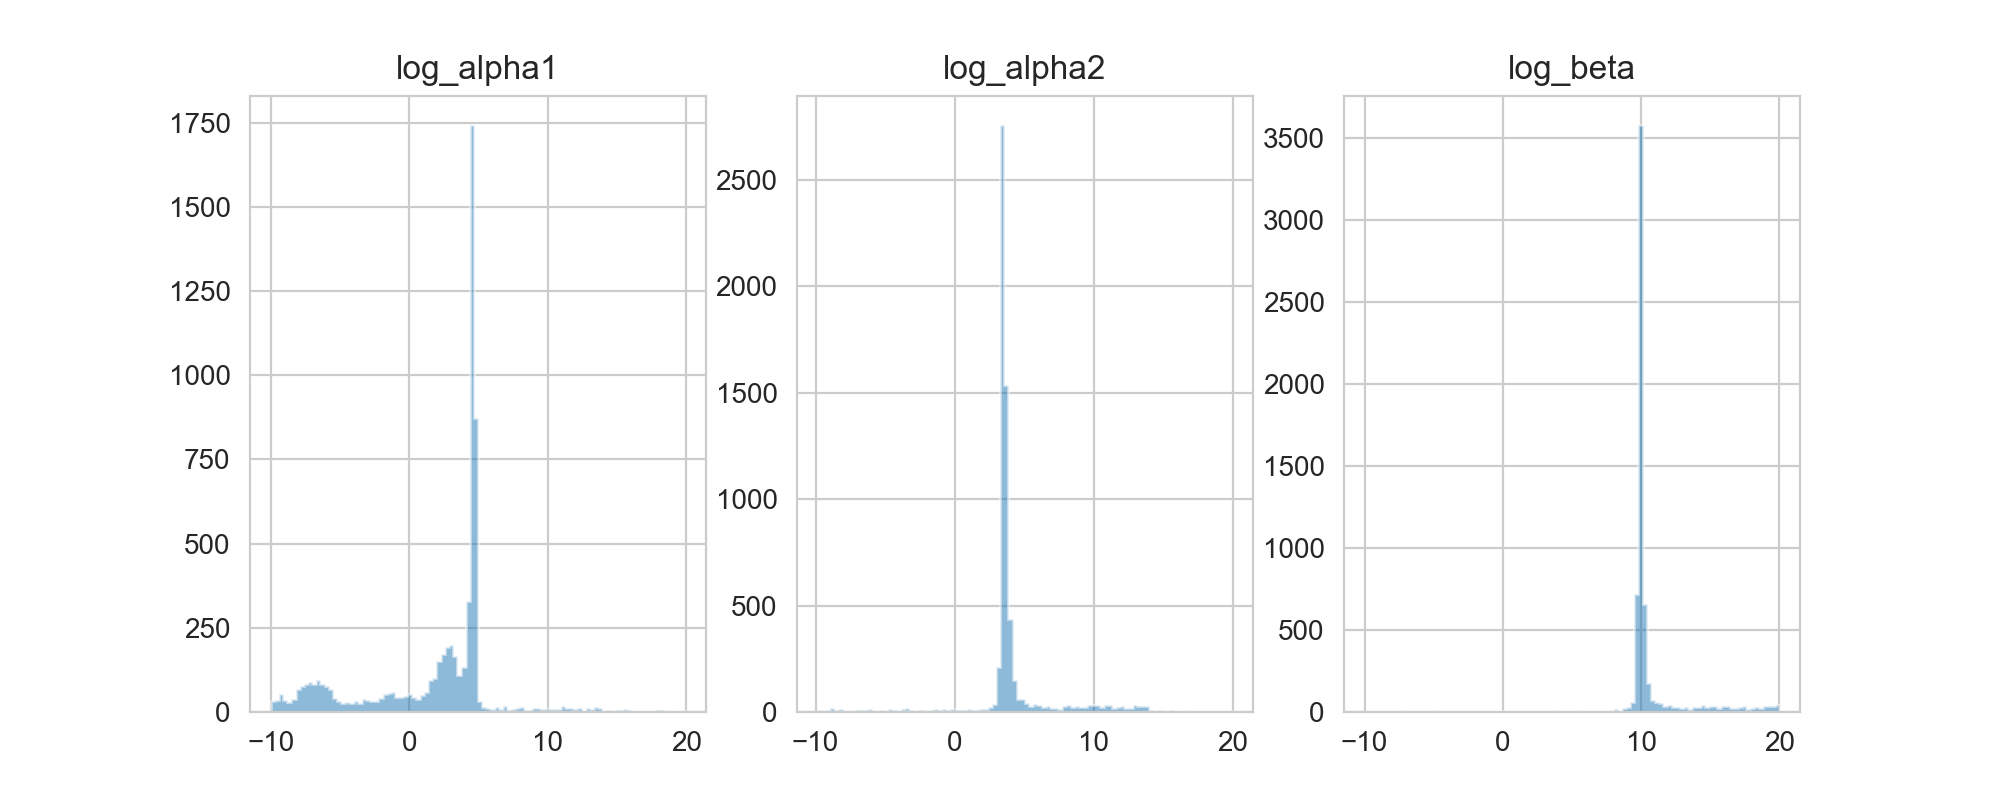

In [71]:
kernel_var_names = ["log_alpha1", "log_alpha2", "log_beta"]


fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

Let's include a function to compute the PSD:

In [72]:
npoints = len(lc_na.counts)

<IPython.core.display.Javascript object>


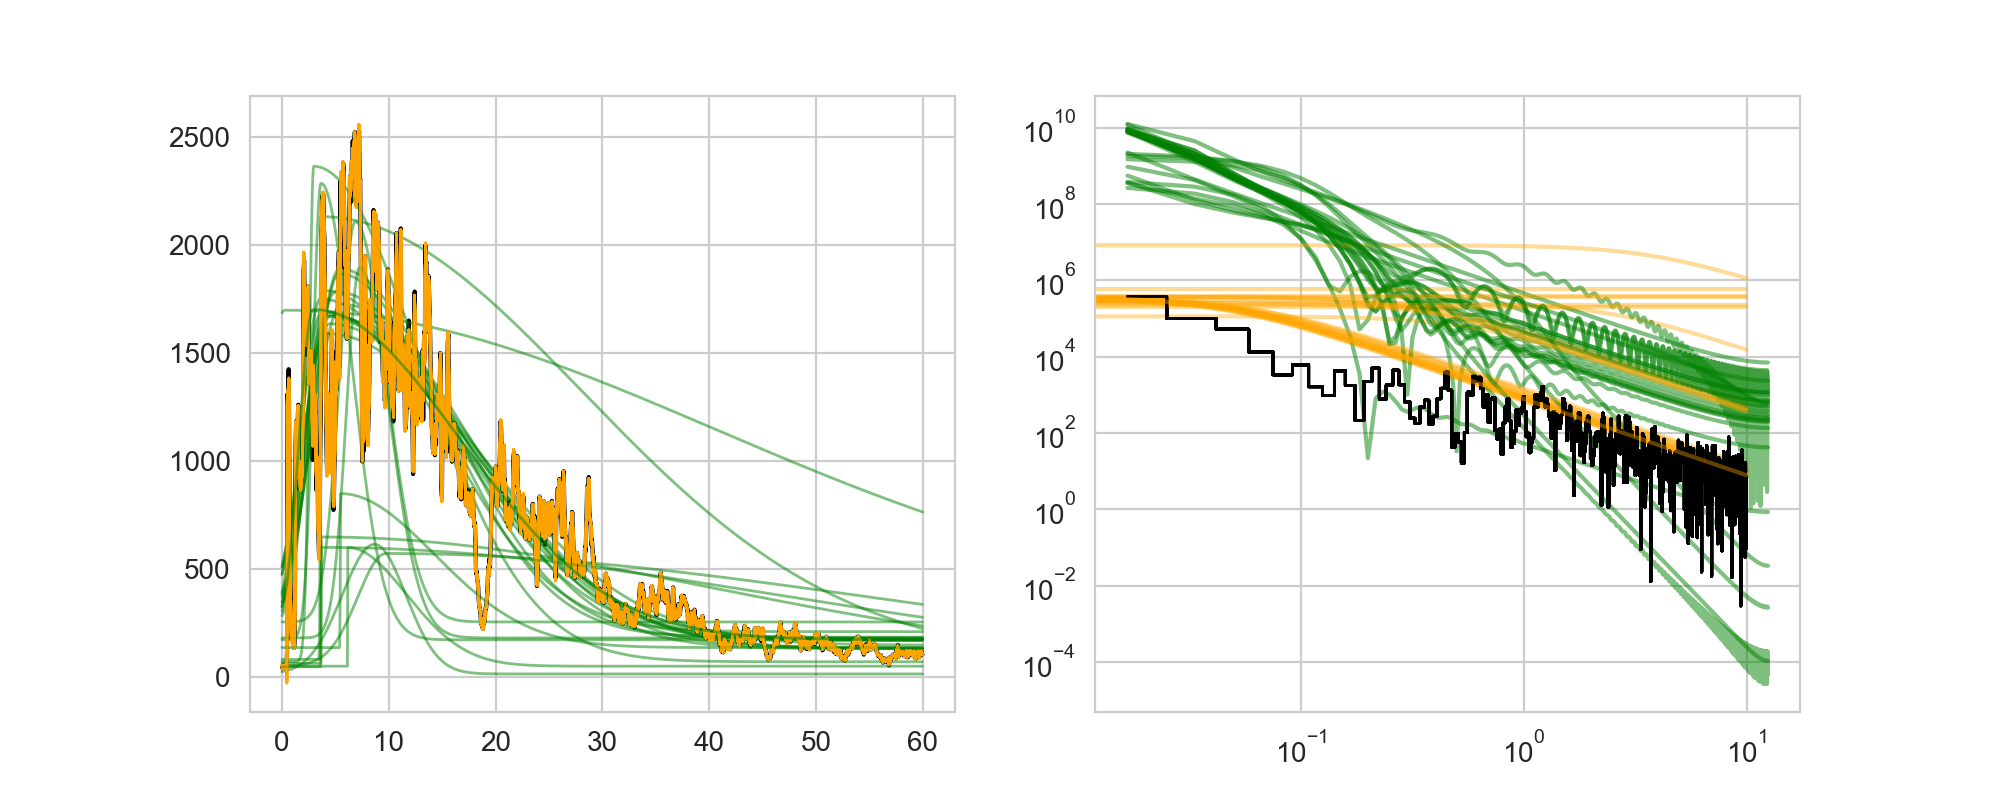

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_na.time[:npoints], lc_na.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, lc_na.time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc_na.n, d=lc_na.dt)
freq = freq[:int(lc_na.n/2)]
# calculate periodogram for comparison:
ps_na = Powerspectrum(lc_na, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples["log_amp"][idx],
              samples["t0"][idx],
              samples["log_sig1"][idx],
              samples["log_sig2"][idx],
              samples["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx])]
    
    beta_post = jnp.exp(samples["log_beta"][idx])

    
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post)
    
    gp = GaussianProcess(kernel_post, lc_na.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc_na.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    psd = power_spectrum(freq, alpha_post, ma_coefs=[beta_post])
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps_na.freq, ps_na.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)


### Model with a QPO

In [106]:
mean_bkg = np.log(np.mean(lc_na.counts[-100:]))

def carma21_fermina_with_qpo(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(6, 8.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
    
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
        
    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(1, 15))
    log_cqpo = numpyro.sample("log_cqpo", dist.Uniform(-20, 2))
    log_freq = numpyro.sample("log_freq", dist.Uniform(np.log(0.3), np.log(5.0)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=jnp.exp(log_aqpo),
            b=0.0,
            c=jnp.exp(log_cqpo),
            d=2 * jnp.pi * jnp.exp(log_freq),
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo
    
    # gaussian process
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

Let's sample this model, too:

In [107]:
npoints = lc_na.n
ns_qpo = NestedSampler(carma21_fermina_with_qpo, constructor_kwargs={"max_samples":100000})
ns_qpo.run(random.PRNGKey(200), lc_na.time[:npoints], y=lc_na.counts[:npoints], )

In [108]:
import pickle
with open(datadir + "fermi_na_carma21_qpo_ns.pkl", "wb") as f:
    pickle.dump(ns_qpo, f)

In [109]:
samples_qpo, weights_qpo = ns_qpo.get_weighted_samples()

ns_qpo.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1917595
# samples: 9350
# slices: 272250.0
# slices / acceptance: 33.0
# likelihood evals / sample: 205.1
# likelihood evals / slice: 7.0
--------
logZ=-7210.46 +- 0.3
H=7200.0
ESS=955
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 4.08 +- 0.16 | 3.87 / 4.09 / 4.28 | 4.11 | 4.11
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 3.36 +- 0.11 | 3.22 / 3.36 / 3.51 | 3.33 | 3.33
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.28 +- 0.06 | 7.208 / 7.275 / 7.358 | 7.305 | 7.305
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 3.4 +- 1.1 | 2.0 / 3.6 / 4.8 | 5.4 | 5.4
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 9.705 +- 0.077 | 9.612 / 9.702 / 9.806 | 9

pred[192]: -19.0 +- 64.0 | -103.0 / -15.0 / 58.0 | -46.0 | -46.0
pred[193]: -9.0 +- 64.0 | -93.0 / -5.0 / 68.0 | -36.0 | -36.0
pred[194]: 117.0 +- 64.0 | 31.0 / 120.0 / 192.0 | 89.0 | 89.0
pred[195]: 138.0 +- 64.0 | 54.0 / 142.0 / 213.0 | 111.0 | 111.0
pred[196]: 303.0 +- 64.0 | 219.0 / 307.0 / 378.0 | 275.0 | 275.0
pred[197]: 482.0 +- 63.0 | 398.0 / 485.0 / 556.0 | 455.0 | 455.0
pred[198]: 534.0 +- 63.0 | 450.0 / 537.0 / 608.0 | 507.0 | 507.0
pred[199]: 470.0 +- 63.0 | 386.0 / 473.0 / 543.0 | 443.0 | 443.0
pred[200]: 390.0 +- 63.0 | 306.0 / 394.0 / 464.0 | 363.0 | 363.0
pred[201]: 210.0 +- 63.0 | 127.0 / 213.0 / 284.0 | 183.0 | 183.0
pred[202]: 89.0 +- 63.0 | 6.0 / 93.0 / 163.0 | 63.0 | 63.0
pred[203]: 119.0 +- 63.0 | 34.0 / 123.0 / 192.0 | 92.0 | 92.0
pred[204]: 5.0 +- 62.0 | -76.0 / 9.0 / 78.0 | -21.0 | -21.0
pred[205]: -5.0 +- 62.0 | -86.0 / -1.0 / 68.0 | -30.0 | -30.0
pred[206]: 110.0 +- 62.0 | 27.0 / 114.0 / 183.0 | 85.0 | 85.0
pred[207]: 84.0 +- 62.0 | 0.0 / 88.0 / 156.0 | 58.0 

pred[409]: 310.0 +- 51.0 | 246.0 / 305.0 / 381.0 | 315.0 | 315.0
pred[410]: 276.0 +- 51.0 | 212.0 / 271.0 / 347.0 | 281.0 | 281.0
pred[411]: 161.0 +- 52.0 | 96.0 / 156.0 / 232.0 | 166.0 | 166.0
pred[412]: 88.0 +- 52.0 | 24.0 / 83.0 / 161.0 | 93.0 | 93.0
pred[413]: 29.0 +- 52.0 | -35.0 / 24.0 / 101.0 | 34.0 | 34.0
pred[414]: 109.0 +- 52.0 | 44.0 / 104.0 / 180.0 | 114.0 | 114.0
pred[415]: 185.0 +- 52.0 | 121.0 / 180.0 / 256.0 | 190.0 | 190.0
pred[416]: 86.0 +- 52.0 | 20.0 / 81.0 / 157.0 | 91.0 | 91.0
pred[417]: 57.0 +- 52.0 | -8.0 / 52.0 / 128.0 | 62.0 | 62.0
pred[418]: -24.0 +- 52.0 | -89.0 / -29.0 / 48.0 | -18.0 | -18.0
pred[419]: -98.0 +- 52.0 | -164.0 / -103.0 / -27.0 | -93.0 | -93.0
pred[420]: -67.0 +- 52.0 | -132.0 / -71.0 / 5.0 | -61.0 | -61.0
pred[421]: -62.0 +- 52.0 | -127.0 / -66.0 / 10.0 | -55.0 | -55.0
pred[422]: -78.0 +- 52.0 | -142.0 / -82.0 / -5.0 | -71.0 | -71.0
pred[423]: -119.0 +- 52.0 | -184.0 / -123.0 / -47.0 | -112.0 | -112.0
pred[424]: -84.0 +- 52.0 | -149.0 / -88.0

pred[632]: -108.0 +- 56.0 | -179.0 / -109.0 / -36.0 | -89.0 | -89.0
pred[633]: -123.0 +- 56.0 | -193.0 / -124.0 / -50.0 | -103.0 | -103.0
pred[634]: -100.0 +- 56.0 | -170.0 / -100.0 / -27.0 | -80.0 | -80.0
pred[635]: -114.0 +- 56.0 | -184.0 / -115.0 / -41.0 | -94.0 | -94.0
pred[636]: -108.0 +- 56.0 | -178.0 / -108.0 / -35.0 | -88.0 | -88.0
pred[637]: -122.0 +- 56.0 | -192.0 / -123.0 / -50.0 | -103.0 | -103.0
pred[638]: -145.0 +- 56.0 | -215.0 / -145.0 / -73.0 | -125.0 | -125.0
pred[639]: -133.0 +- 56.0 | -203.0 / -133.0 / -61.0 | -113.0 | -113.0
pred[640]: -132.0 +- 56.0 | -202.0 / -132.0 / -60.0 | -112.0 | -112.0
pred[641]: -90.0 +- 56.0 | -159.0 / -90.0 / -17.0 | -70.0 | -70.0
pred[642]: -72.0 +- 56.0 | -142.0 / -73.0 / -0.0 | -52.0 | -52.0
pred[643]: -53.0 +- 56.0 | -123.0 / -54.0 / 18.0 | -34.0 | -34.0
pred[644]: -81.0 +- 56.0 | -151.0 / -81.0 / -9.0 | -61.0 | -61.0
pred[645]: -62.0 +- 56.0 | -132.0 / -63.0 / 9.0 | -42.0 | -42.0
pred[646]: -75.0 +- 56.0 | -145.0 / -76.0 / -4.0 | -5

pred[819]: -33.0 +- 39.0 | -83.0 / -31.0 / 18.0 | -18.0 | -18.0
pred[820]: -28.0 +- 39.0 | -78.0 / -26.0 / 23.0 | -14.0 | -14.0
pred[821]: -37.0 +- 39.0 | -87.0 / -36.0 / 13.0 | -23.0 | -23.0
pred[822]: -25.0 +- 39.0 | -75.0 / -23.0 / 25.0 | -11.0 | -11.0
pred[823]: -63.0 +- 39.0 | -113.0 / -62.0 / -14.0 | -49.0 | -49.0
pred[824]: -52.0 +- 39.0 | -102.0 / -50.0 / -2.0 | -38.0 | -38.0
pred[825]: -62.0 +- 39.0 | -111.0 / -60.0 / -12.0 | -48.0 | -48.0
pred[826]: -67.0 +- 38.0 | -117.0 / -66.0 / -18.0 | -53.0 | -53.0
pred[827]: -45.0 +- 38.0 | -95.0 / -44.0 / 4.0 | -31.0 | -31.0
pred[828]: 2.0 +- 38.0 | -48.0 / 3.0 / 51.0 | 15.0 | 15.0
pred[829]: -26.0 +- 38.0 | -75.0 / -25.0 / 23.0 | -12.0 | -12.0
pred[830]: -9.0 +- 38.0 | -58.0 / -7.0 / 40.0 | 5.0 | 5.0
pred[831]: -27.0 +- 38.0 | -76.0 / -25.0 / 22.0 | -13.0 | -13.0
pred[832]: -19.0 +- 38.0 | -68.0 / -18.0 / 29.0 | -6.0 | -6.0
pred[833]: -42.0 +- 38.0 | -91.0 / -41.0 / 6.0 | -29.0 | -29.0
pred[834]: -42.0 +- 38.0 | -90.0 / -40.0 / 6.0 | 

pred[1002]: 83.0 +- 22.0 | 55.0 / 83.0 / 110.0 | 87.0 | 87.0
pred[1003]: 104.0 +- 22.0 | 76.0 / 103.0 / 130.0 | 108.0 | 108.0
pred[1004]: 108.0 +- 22.0 | 80.0 / 107.0 / 134.0 | 112.0 | 112.0
pred[1005]: 75.0 +- 21.0 | 47.0 / 74.0 / 101.0 | 79.0 | 79.0
pred[1006]: 86.0 +- 21.0 | 59.0 / 86.0 / 112.0 | 90.0 | 90.0
pred[1007]: 87.0 +- 21.0 | 60.0 / 87.0 / 113.0 | 91.0 | 91.0
pred[1008]: 76.0 +- 21.0 | 49.0 / 76.0 / 102.0 | 80.0 | 80.0
pred[1009]: 66.0 +- 21.0 | 39.0 / 66.0 / 92.0 | 70.0 | 70.0
pred[1010]: 50.0 +- 21.0 | 23.0 / 49.0 / 76.0 | 53.0 | 53.0
pred[1011]: 60.0 +- 21.0 | 34.0 / 60.0 / 86.0 | 64.0 | 64.0
pred[1012]: 34.0 +- 21.0 | 8.0 / 34.0 / 60.0 | 38.0 | 38.0
pred[1013]: 56.0 +- 21.0 | 30.0 / 56.0 / 82.0 | 60.0 | 60.0
pred[1014]: 83.0 +- 21.0 | 56.0 / 82.0 / 108.0 | 86.0 | 86.0
pred[1015]: 56.0 +- 21.0 | 30.0 / 56.0 / 82.0 | 60.0 | 60.0
pred[1016]: 80.0 +- 21.0 | 53.0 / 79.0 / 105.0 | 83.0 | 83.0
pred[1017]: 59.0 +- 21.0 | 33.0 / 59.0 / 85.0 | 63.0 | 63.0
pred[1018]: 80.0 +- 21.0

pred[1195]: 44.0 +- 14.0 | 28.0 / 43.0 / 66.0 | 41.0 | 41.0
pred[1196]: 52.0 +- 14.0 | 36.0 / 51.0 / 74.0 | 49.0 | 49.0
pred[1197]: 60.0 +- 14.0 | 43.0 / 59.0 / 81.0 | 57.0 | 57.0
pred[1198]: 46.0 +- 13.0 | 30.0 / 45.0 / 67.0 | 43.0 | 43.0
pred[1199]: 43.0 +- 13.0 | 27.0 / 42.0 / 65.0 | 40.0 | 40.0
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.515 +- 0.012 | 0.495 / 0.518 / 0.529 | 0.514 | 0.514
--------


In [110]:
logZ_carma = -7274.42
logZ_qpo =  -7210.4

In [111]:
logZ_carma - logZ_qpo

-64.02000000000044

<IPython.core.display.Javascript object>


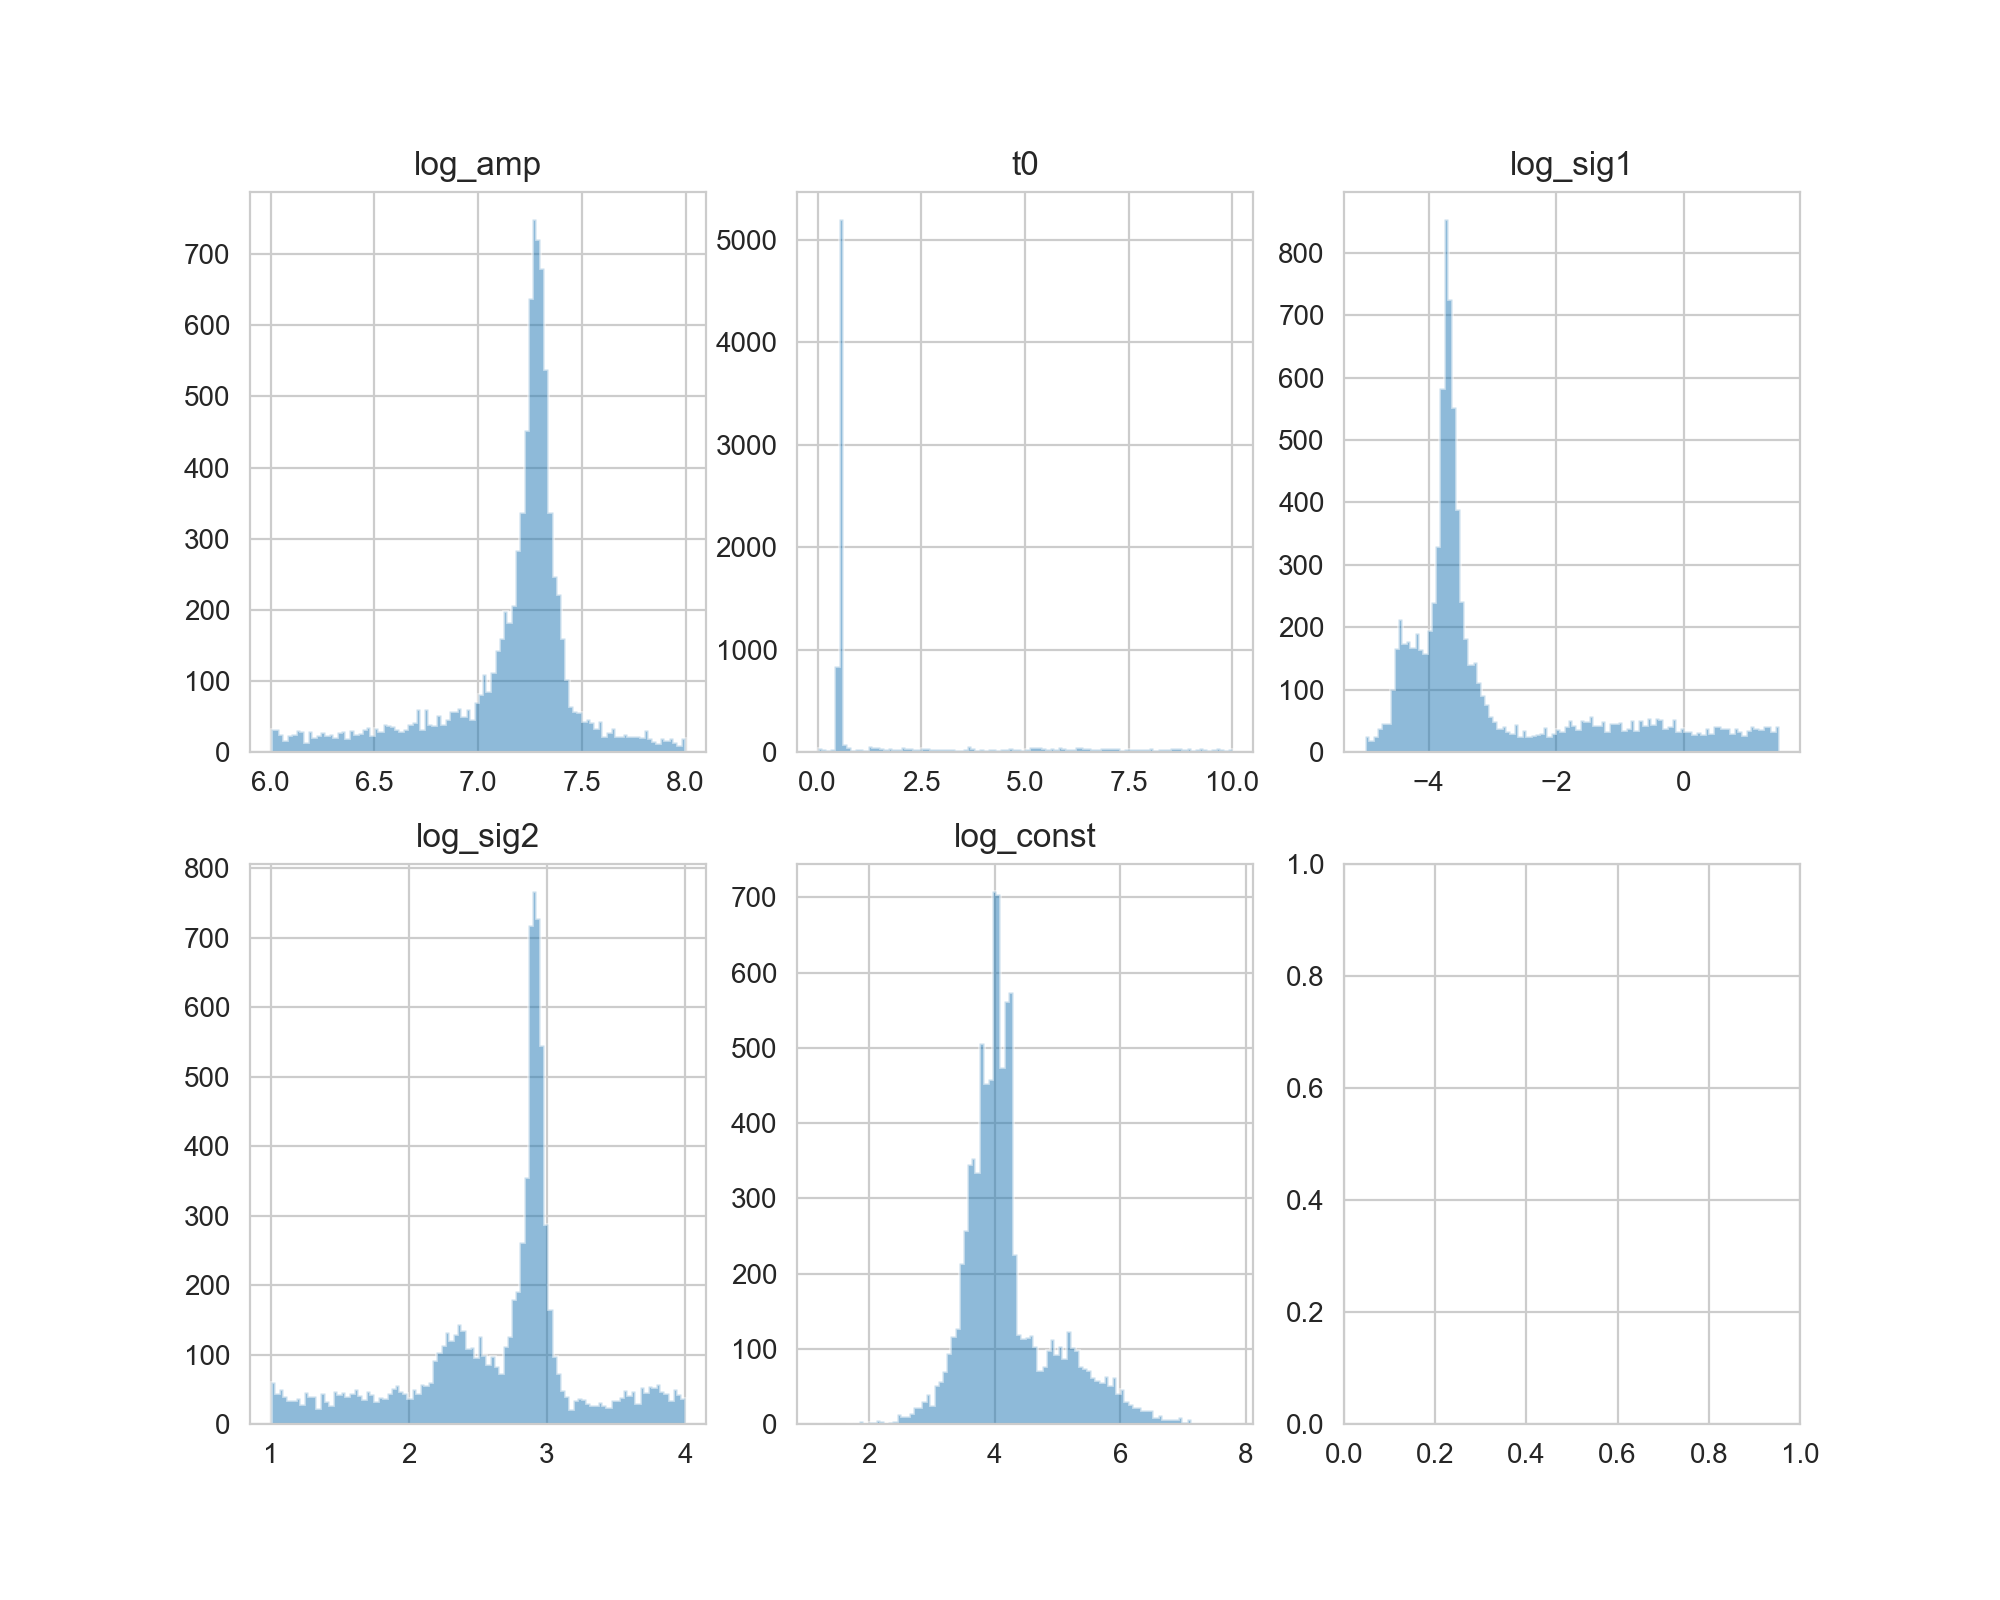

In [112]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples_qpo[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


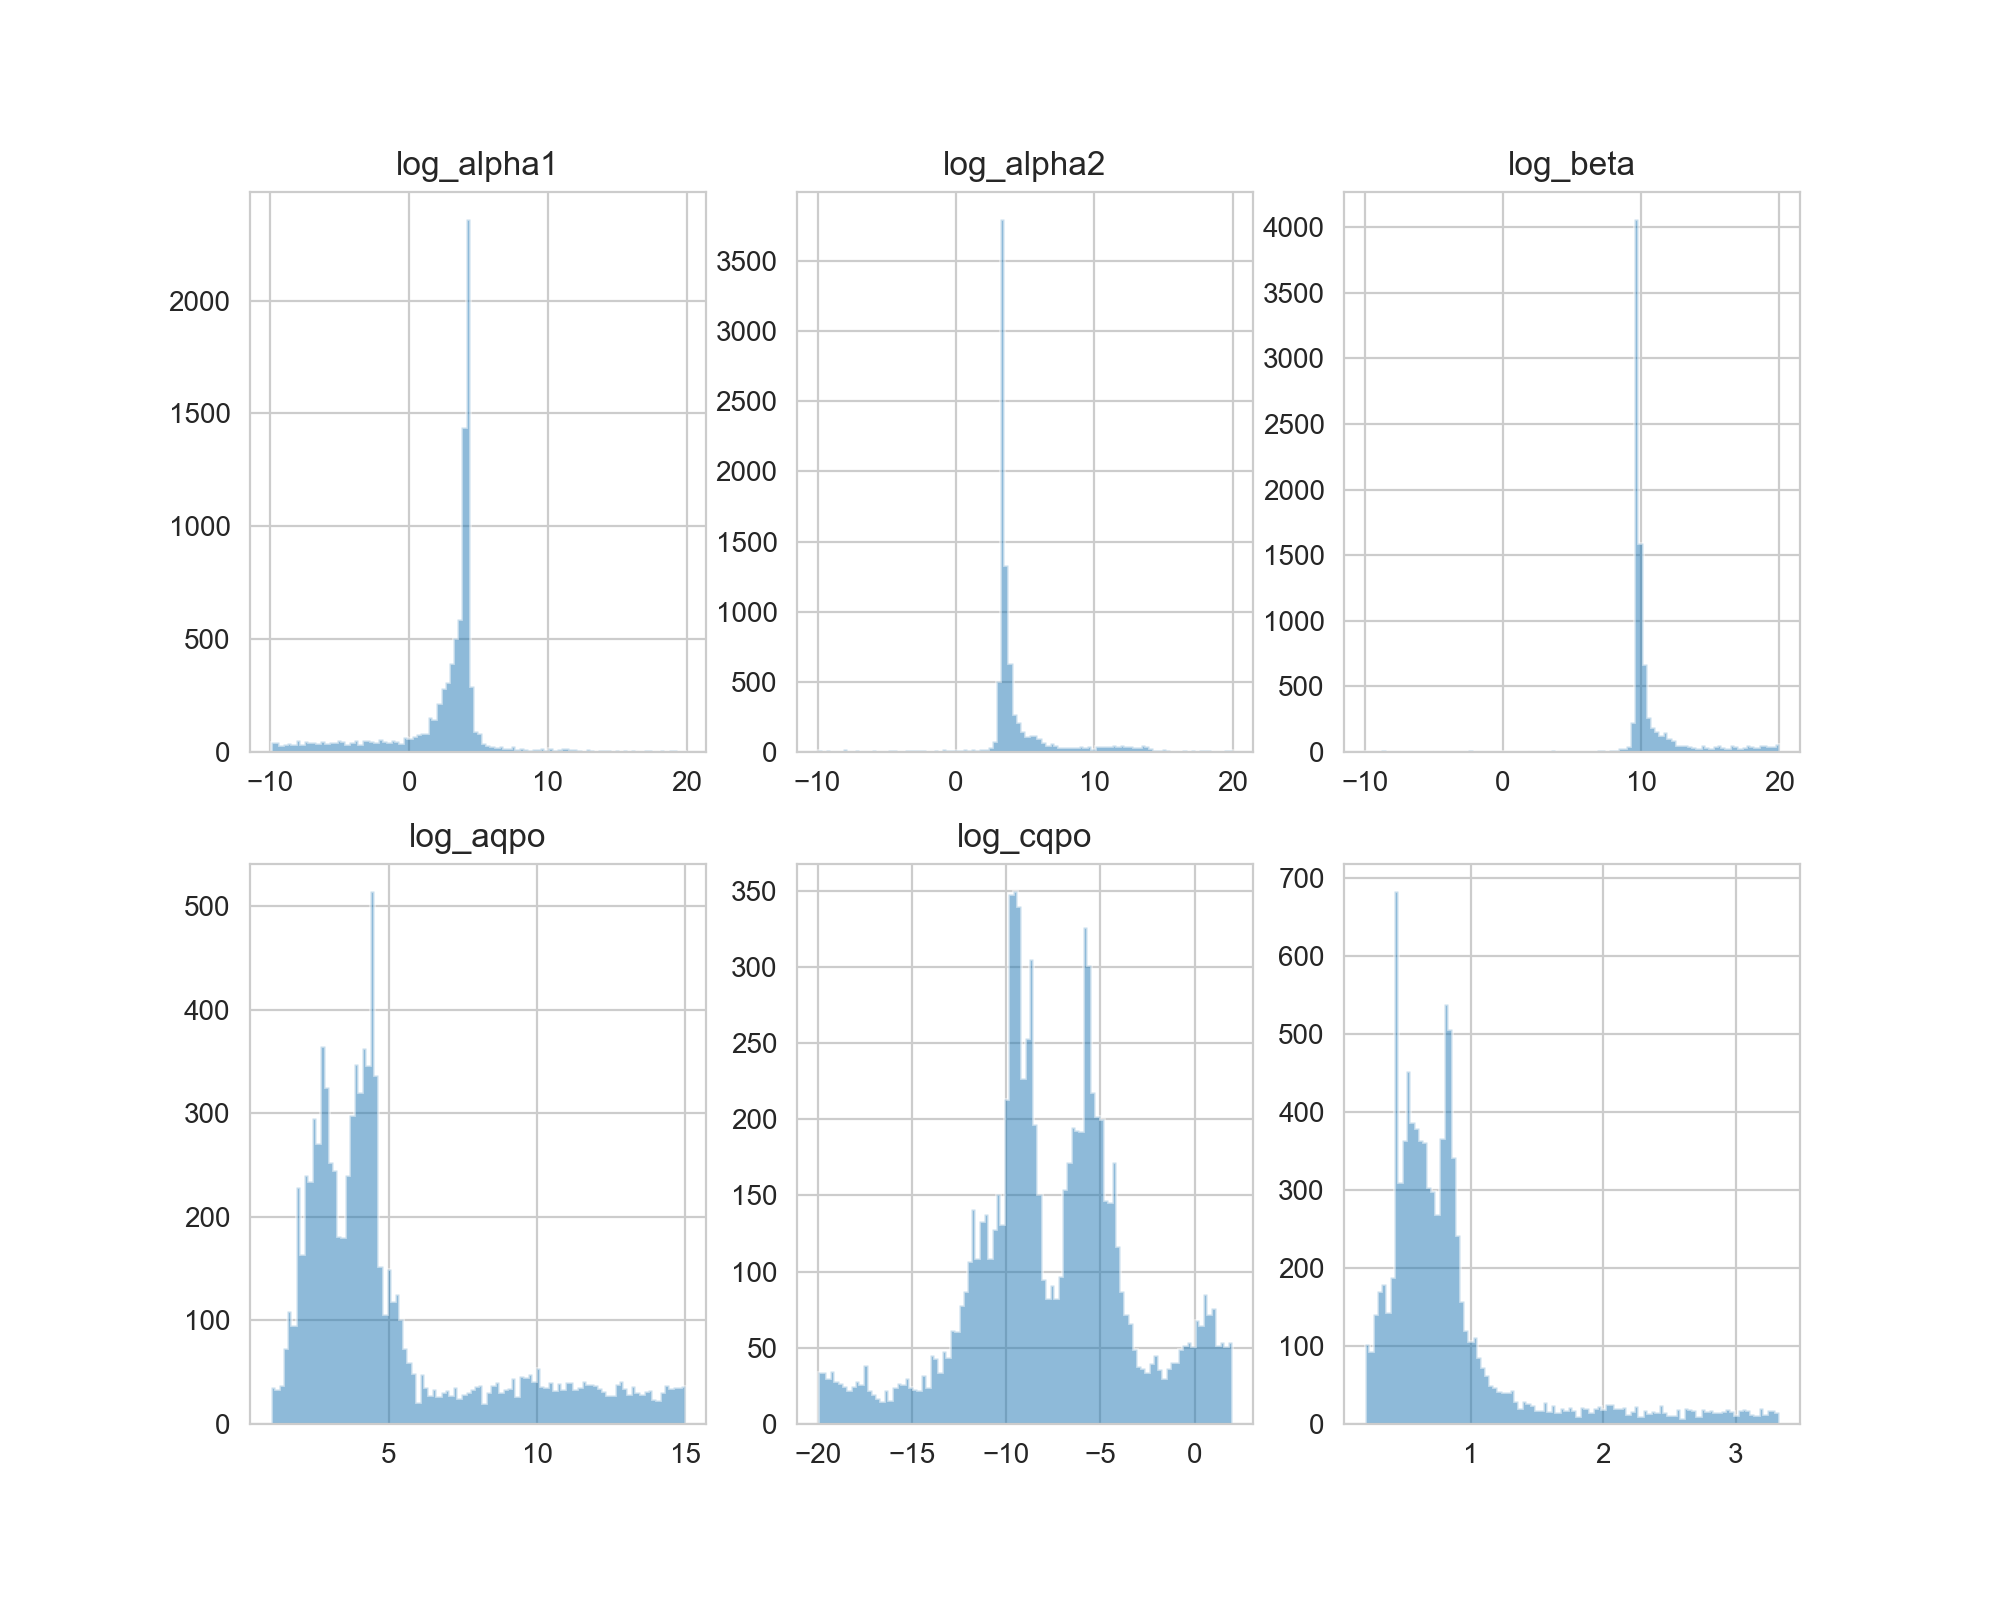

In [113]:
kernel_var_names = ["log_alpha1", "log_alpha2",
                    "log_beta", "log_aqpo", 
                    "log_cqpo", "log_freq"]


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):

    samp = samples_qpo[vn].block_until_ready()  
    if vn == "log_freq":
        axes[i].hist(1./jnp.exp(samp), bins=100, histtype="stepfilled", alpha=0.5)
    else:
        axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
        axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

In [114]:
def lorentzian(freq, amp, f0, fwhm):
    """
    A Lorentzian function (Cauchy distribution)
    
    Parameters
    ----------
    freq : numpy.ndarray
        An array of frequencies for which to 
        compute the Lorentzian
        
    amp : float
        The amplitude of the Lorentzian
        
    f0 : float
        The centroid frequency of the Lorentzian
        
    fwhm : float
        The full-width at half-maximum of the 
        Lorentzian
        
    Returns
    -------
    lor : numpy.ndarray
        The values of the Lorentzian for the 
        given parameters and frequency array
    
    """
    num = amp * fwhm**2.
    denom = fwhm**2. + (freq - f0)**2.0
    
    return num/denom   

<IPython.core.display.Javascript object>


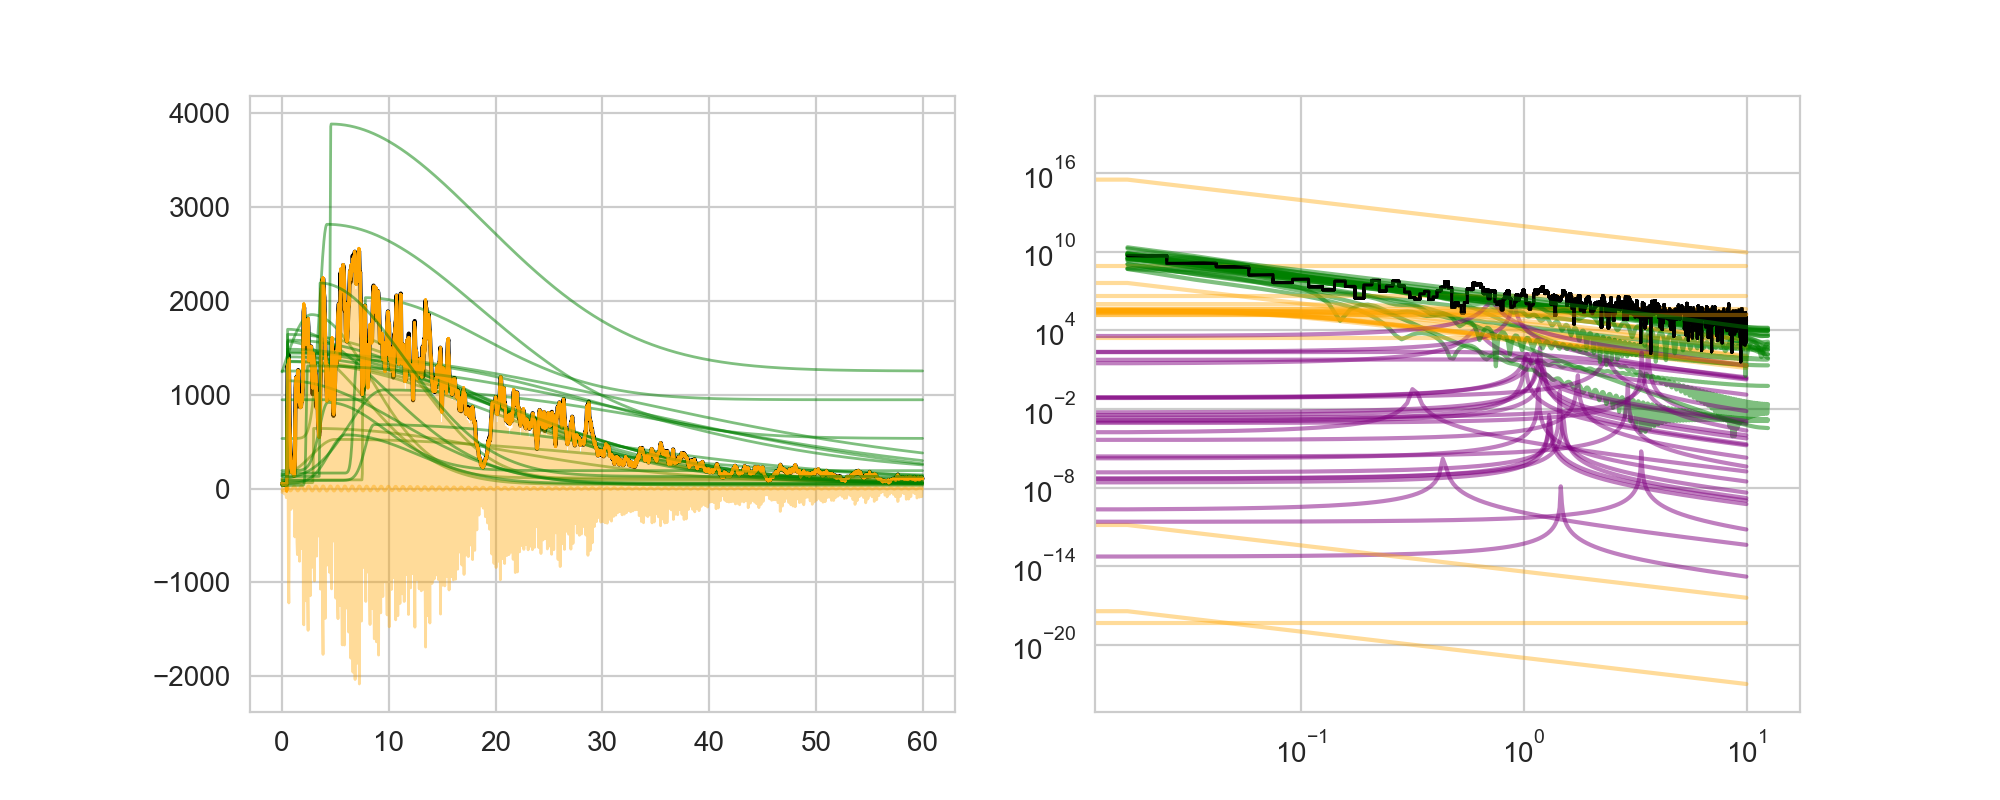

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_na.time[:npoints], lc_na.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples_qpo["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, lc_na.time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc_na.n, d=lc_na.dt)
freq = freq[:int(lc_na.n/2)]

# calculate periodogram for comparison:
ps_na = Powerspectrum(lc_na, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples_qpo["log_amp"][idx],
              samples_qpo["t0"][idx],
              samples_qpo["log_sig1"][idx],
              samples_qpo["log_sig2"][idx],
              samples_qpo["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples_qpo["log_alpha1"][idx]),
             jnp.exp(samples_qpo["log_alpha2"][idx])]
    
    beta_post = jnp.exp(samples_qpo["log_beta"][idx])
    
    kernel_carma = CARMA.init(alpha=alpha_post, 
                        beta=beta_post)
    
    
    aqpo_post = jnp.exp(samples_qpo["log_aqpo"][idx])
    cqpo_post = jnp.exp(samples_qpo["log_cqpo"][idx])
    freq_post = jnp.exp(samples_qpo['log_freq'][idx])
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=aqpo_post,
            b=0.0,
            c=cqpo_post,
            d=2 * jnp.pi * freq_post
        )
    
    # add kernels together
    kernel_post = kernel_carma + kernel_qpo
    
    gp = GaussianProcess(kernel_post, lc_na.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc_na.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    # PSD of the CARMA process
    psd_carma = power_spectrum(freq, alpha_post, ma_coefs=[beta_post])
    psd_lor = lorentzian(freq, aqpo_post, freq_post, cqpo_post)
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps_na.freq, ps_na.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd_carma, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)
    ax2.loglog(freq, psd_lor, color="purple", alpha=0.5)


I guess that's fine?

## BGO Data

Let's do the same for the BGO data

In [116]:
bgo_filename = "bn230307656_b1_mete.sav"

data = scipy.io.readsav(datadir+bgo_filename)
data

{'tte_b1_time': array([6.99896627e+08, 6.99896627e+08, 6.99896627e+08, ...,
        6.99896772e+08, 6.99896772e+08, 6.99896772e+08], dtype='>f8'),
 'b1_barytime': array([6.99896606e+08, 6.99896606e+08, 6.99896606e+08, ...,
        6.99896751e+08, 6.99896751e+08, 6.99896751e+08], dtype='>f8'),
 'btime': 699896651.671248}

In [117]:
barytime = np.array(data["b1_barytime"], dtype=float)
#counts = np.array(data["counts"], dtype=float)

trigtime = data["btime"]

barytime -= trigtime -21

In [118]:
np.log(np.max(lc_na.counts))

7.834788107388195

INFO[2023-10-13 13:07:11,772]: make_lightcurve: tseg: 144.99639451503754
INFO[2023-10-13 13:07:11,773]: make_lightcurve: timebin:  2899


4569.8


<IPython.core.display.Javascript object>


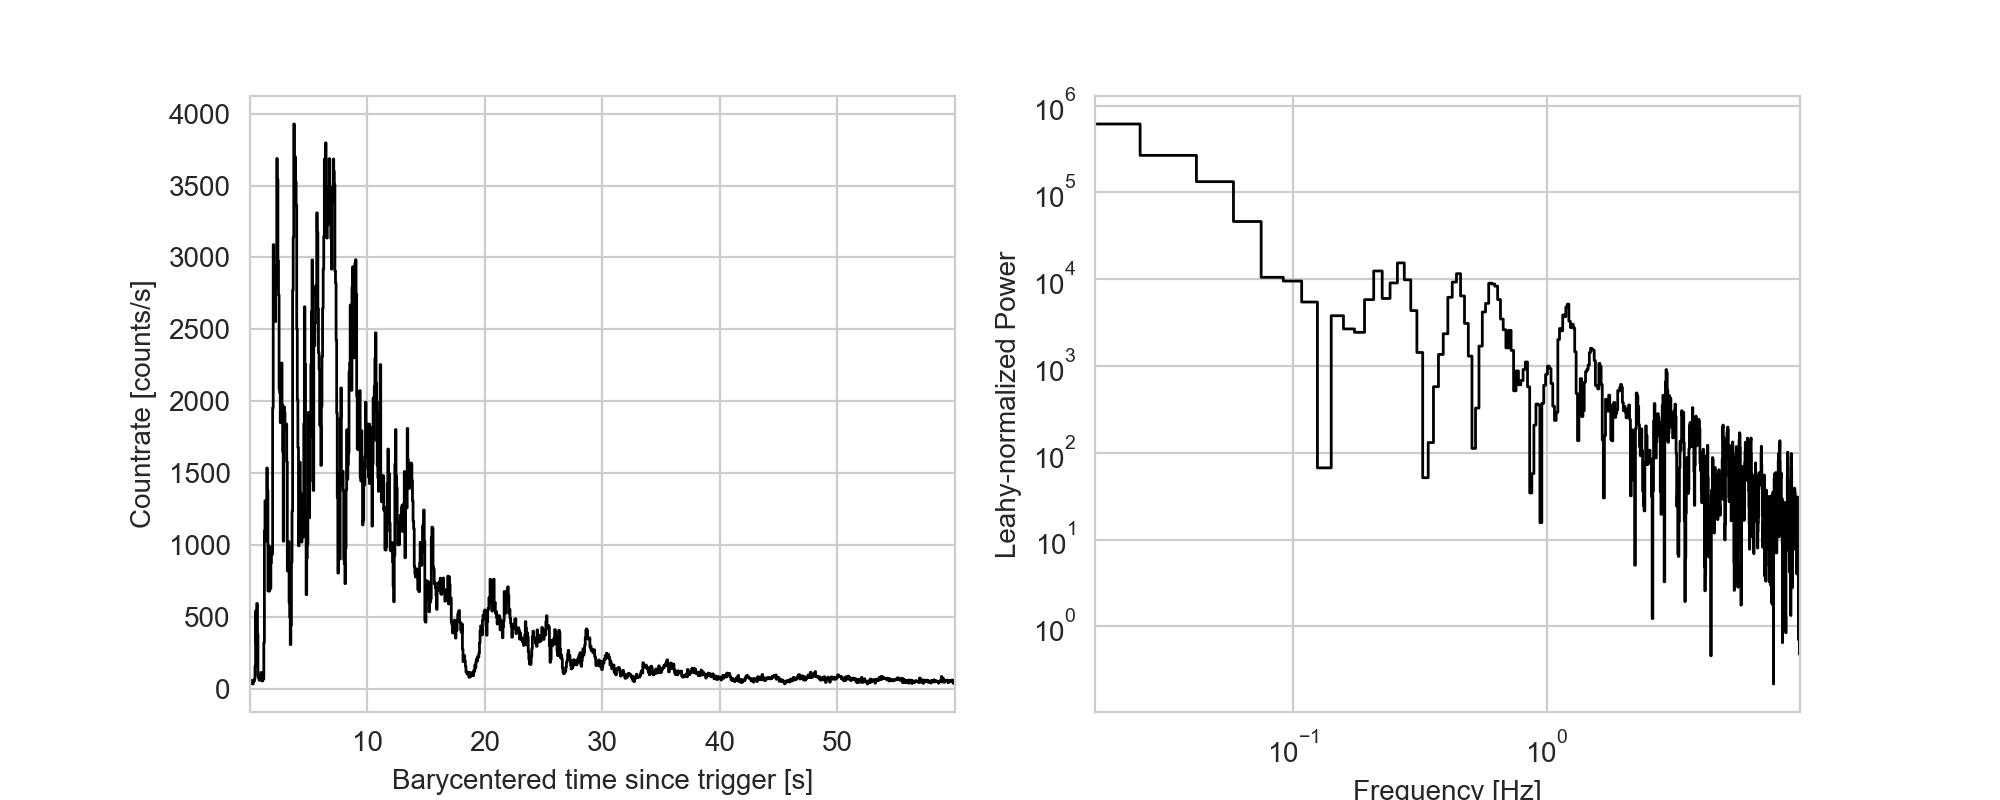

Text(0, 0.5, 'Leahy-normalized Power')

In [119]:
lc_bgo = Lightcurve.make_lightcurve(barytime, dt=lc.dt)

# calculate background flux
mean_bkg = np.mean(counts[-100:])
print(mean_bkg)

minind = lc_bgo.time.searchsorted(0.0)
maxind = lc_bgo.time.searchsorted(60.0)
lc_bgo = lc_bgo.truncate(start=minind, stop=maxind, method="index")

# calculate periodogram for comparison:
ps_bgo = Powerspectrum(lc_bgo, norm="leahy")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time, lc_bgo.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps_bgo.freq, ps_bgo.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps_bgo.freq[0], ps_bgo.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [150]:
np.log(np.max(lc_bgo.counts))

8.275885669474356

In [151]:
mean_bkg = np.log(np.mean(lc_bgo.counts[-100:]))

def carma21_fermi_bgo(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(7, 9.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [152]:
npoints = len(lc_bgo.time)
ns_bgo = NestedSampler(carma21_fermi_bgo)
ns_bgo.run(random.PRNGKey(200), lc_bgo.time, y=lc_bgo.counts)

In [153]:
import pickle
with open(datadir + "fermi_bgo_carma21_ns.pkl", "wb") as f:
    pickle.dump(ns_bgo, f)

In [154]:
#import pickle
#with open(datadir + "fermi_na_carma21_ns.pkl", "rb") as f:
#    ns_na = pickle.load(f)

In [155]:
samples, weights = ns_bgo.get_weighted_samples()

ns_bgo.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1319211
# samples: 7800
# slices: 168000.0
# slices / acceptance: 24.0
# likelihood evals / sample: 169.1
# likelihood evals / slice: 7.8
--------
logZ=-7850.95 +- 0.38
H=7900.0
ESS=663
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 4.98 +- 0.12 | 4.82 / 4.98 / 5.13 | 4.99 | 4.99
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 3.82 +- 0.1 | 3.69 / 3.82 / 3.95 | 3.81 | 3.81
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.727 +- 0.055 | 7.66 / 7.731 / 7.8 | 7.735 | 7.735
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 10.662 +- 0.08 | 10.569 / 10.658 / 10.768 | 10.646 | 10.646
--------
log_const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_const: 4.02 +- 0.043 | 3.97 /

pred[116]: 517.0 +- 100.0 | 381.0 / 517.0 / 640.0 | 488.0 | 488.0
pred[117]: 213.0 +- 99.0 | 78.0 / 213.0 / 335.0 | 184.0 | 184.0
pred[118]: 59.0 +- 98.0 | -74.0 / 58.0 / 180.0 | 28.0 | 28.0
pred[119]: -265.0 +- 98.0 | -399.0 / -266.0 / -143.0 | -295.0 | -295.0
pred[120]: -329.0 +- 97.0 | -460.0 / -331.0 / -210.0 | -361.0 | -361.0
pred[121]: -528.0 +- 97.0 | -661.0 / -529.0 / -407.0 | -558.0 | -558.0
pred[122]: -167.0 +- 96.0 | -298.0 / -168.0 / -47.0 | -199.0 | -199.0
pred[123]: 202.0 +- 95.0 | 69.0 / 201.0 / 320.0 | 170.0 | 170.0
pred[124]: 532.0 +- 95.0 | 401.0 / 532.0 / 650.0 | 500.0 | 500.0
pred[125]: 808.0 +- 94.0 | 677.0 / 809.0 / 926.0 | 775.0 | 775.0
pred[126]: 1088.0 +- 94.0 | 957.0 / 1088.0 / 1204.0 | 1056.0 | 1056.0
pred[127]: 1474.0 +- 93.0 | 1348.0 / 1474.0 / 1589.0 | 1440.0 | 1440.0
pred[128]: 1324.0 +- 93.0 | 1188.0 / 1326.0 / 1438.0 | 1292.0 | 1292.0
pred[129]: 1565.0 +- 91.0 | 1440.0 / 1568.0 / 1676.0 | 1530.0 | 1530.0
pred[130]: 1148.0 +- 91.0 | 1017.0 / 1148.0 / 126

pred[354]: -90.0 +- 110.0 | -210.0 / -90.0 / 50.0 | -150.0 | -150.0
pred[355]: -70.0 +- 110.0 | -190.0 / -70.0 / 70.0 | -130.0 | -130.0
pred[356]: -60.0 +- 100.0 | -180.0 / -60.0 / 80.0 | -120.0 | -120.0
pred[357]: -130.0 +- 100.0 | -250.0 / -130.0 / 10.0 | -190.0 | -190.0
pred[358]: -130.0 +- 100.0 | -250.0 / -130.0 / 10.0 | -190.0 | -190.0
pred[359]: -180.0 +- 100.0 | -300.0 / -180.0 / -40.0 | -240.0 | -240.0
pred[360]: -190.0 +- 100.0 | -310.0 / -190.0 / -50.0 | -250.0 | -250.0
pred[361]: -130.0 +- 100.0 | -250.0 / -130.0 / 10.0 | -190.0 | -190.0
pred[362]: -290.0 +- 100.0 | -410.0 / -290.0 / -160.0 | -360.0 | -360.0
pred[363]: -380.0 +- 100.0 | -500.0 / -370.0 / -240.0 | -440.0 | -440.0
pred[364]: -360.0 +- 100.0 | -480.0 / -360.0 / -230.0 | -420.0 | -420.0
pred[365]: -330.0 +- 100.0 | -450.0 / -320.0 / -190.0 | -390.0 | -390.0
pred[366]: -360.0 +- 100.0 | -480.0 / -360.0 / -230.0 | -420.0 | -420.0
pred[367]: -390.0 +- 100.0 | -510.0 / -390.0 / -260.0 | -450.0 | -450.0
pred[368]: -

pred[588]: 122.0 +- 26.0 | 100.0 / 128.0 / 145.0 | 113.0 | 113.0
pred[589]: 74.0 +- 26.0 | 53.0 / 80.0 / 97.0 | 66.0 | 66.0
pred[590]: 71.0 +- 25.0 | 50.0 / 78.0 / 94.0 | 63.0 | 63.0
pred[591]: 92.0 +- 25.0 | 71.0 / 98.0 / 114.0 | 84.0 | 84.0
pred[592]: 96.0 +- 25.0 | 76.0 / 102.0 / 118.0 | 88.0 | 88.0
pred[593]: 98.0 +- 25.0 | 78.0 / 104.0 / 120.0 | 90.0 | 90.0
pred[594]: 112.0 +- 24.0 | 92.0 / 118.0 / 133.0 | 104.0 | 104.0
pred[595]: 72.0 +- 24.0 | 52.0 / 78.0 / 93.0 | 64.0 | 64.0
pred[596]: 69.0 +- 24.0 | 50.0 / 75.0 / 90.0 | 62.0 | 62.0
pred[597]: 103.0 +- 24.0 | 84.0 / 109.0 / 124.0 | 96.0 | 96.0
pred[598]: 94.0 +- 23.0 | 75.0 / 100.0 / 114.0 | 86.0 | 86.0
pred[599]: 48.0 +- 23.0 | 29.0 / 54.0 / 68.0 | 41.0 | 41.0
pred[600]: 71.0 +- 23.0 | 52.0 / 77.0 / 91.0 | 64.0 | 64.0
pred[601]: 103.0 +- 23.0 | 85.0 / 109.0 / 123.0 | 96.0 | 96.0
pred[602]: 94.0 +- 22.0 | 76.0 / 100.0 / 114.0 | 87.0 | 87.0
pred[603]: 117.0 +- 22.0 | 99.0 / 123.0 / 136.0 | 110.0 | 110.0
pred[604]: 126.0 +- 22.0 

pred[815]: 44.4 +- 2.9 | 41.2 / 44.7 / 47.3 | 42.2 | 42.2
pred[816]: 50.2 +- 2.9 | 47.0 / 50.5 / 53.1 | 48.0 | 48.0
pred[817]: 28.5 +- 2.9 | 25.3 / 28.8 / 31.4 | 26.3 | 26.3
pred[818]: 26.3 +- 2.9 | 23.1 / 26.6 / 29.1 | 24.1 | 24.1
pred[819]: 8.5 +- 2.9 | 5.3 / 8.7 / 11.3 | 6.2 | 6.2
pred[820]: 6.4 +- 2.9 | 3.2 / 6.7 / 9.2 | 4.1 | 4.1
pred[821]: 1.5 +- 2.9 | -1.7 / 1.8 / 4.4 | -0.7 | -0.7
pred[822]: 15.3 +- 2.8 | 12.1 / 15.6 / 18.1 | 13.1 | 13.1
pred[823]: 0.5 +- 2.8 | -2.7 / 0.8 / 3.4 | -1.7 | -1.7
pred[824]: 1.4 +- 2.8 | -1.8 / 1.7 / 4.2 | -0.8 | -0.8
pred[825]: -5.5 +- 2.8 | -8.7 / -5.1 / -2.7 | -7.7 | -7.7
pred[826]: 0.5 +- 2.8 | -2.7 / 0.8 / 3.2 | -1.8 | -1.8
pred[827]: 3.5 +- 2.8 | 0.4 / 3.9 / 6.3 | 1.3 | 1.3
pred[828]: 17.5 +- 2.8 | 14.4 / 17.9 / 20.3 | 15.3 | 15.3
pred[829]: 24.4 +- 2.8 | 21.2 / 24.8 / 27.1 | 22.2 | 22.2
pred[830]: 4.8 +- 2.8 | 1.6 / 5.2 / 7.5 | 2.6 | 2.6
pred[831]: 36.1 +- 2.8 | 33.0 / 36.5 / 38.9 | 33.9 | 33.9
pred[832]: -4.2 +- 2.7 | -7.4 / -3.8 / -1.5 | -6.

pred[1010]: 10.2 +- 2.4 | 7.4 / 10.4 / 13.0 | 7.9 | 7.9
pred[1011]: 0.2 +- 2.4 | -2.6 / 0.5 / 3.0 | -2.1 | -2.1
pred[1012]: 5.3 +- 2.4 | 2.5 / 5.5 / 8.1 | 3.0 | 3.0
pred[1013]: 27.0 +- 2.4 | 24.2 / 27.3 / 29.8 | 24.7 | 24.7
pred[1014]: 4.4 +- 2.4 | 1.5 / 4.6 / 7.2 | 2.0 | 2.0
pred[1015]: 23.1 +- 2.4 | 20.3 / 23.4 / 25.9 | 20.8 | 20.8
pred[1016]: 27.2 +- 2.4 | 24.4 / 27.4 / 29.9 | 24.8 | 24.8
pred[1017]: 20.3 +- 2.4 | 17.5 / 20.6 / 23.1 | 18.0 | 18.0
pred[1018]: 33.0 +- 2.4 | 30.2 / 33.3 / 35.8 | 30.7 | 30.7
pred[1019]: 13.4 +- 2.4 | 10.5 / 13.6 / 16.2 | 11.0 | 11.0
pred[1020]: 26.1 +- 2.4 | 23.3 / 26.3 / 28.8 | 23.7 | 23.7
pred[1021]: 11.3 +- 2.4 | 8.4 / 11.5 / 14.1 | 8.9 | 8.9
pred[1022]: 5.2 +- 2.4 | 2.4 / 5.5 / 8.0 | 2.9 | 2.9
pred[1023]: 3.2 +- 2.4 | 0.4 / 3.5 / 6.0 | 0.9 | 0.9
pred[1024]: 10.2 +- 2.4 | 7.4 / 10.5 / 13.0 | 7.9 | 7.9
pred[1025]: 16.2 +- 2.4 | 13.4 / 16.5 / 19.0 | 13.9 | 13.9
pred[1026]: 18.2 +- 2.4 | 15.4 / 18.5 / 21.0 | 15.9 | 15.9
pred[1027]: 19.2 +- 2.4 | 16.4 / 

<IPython.core.display.Javascript object>


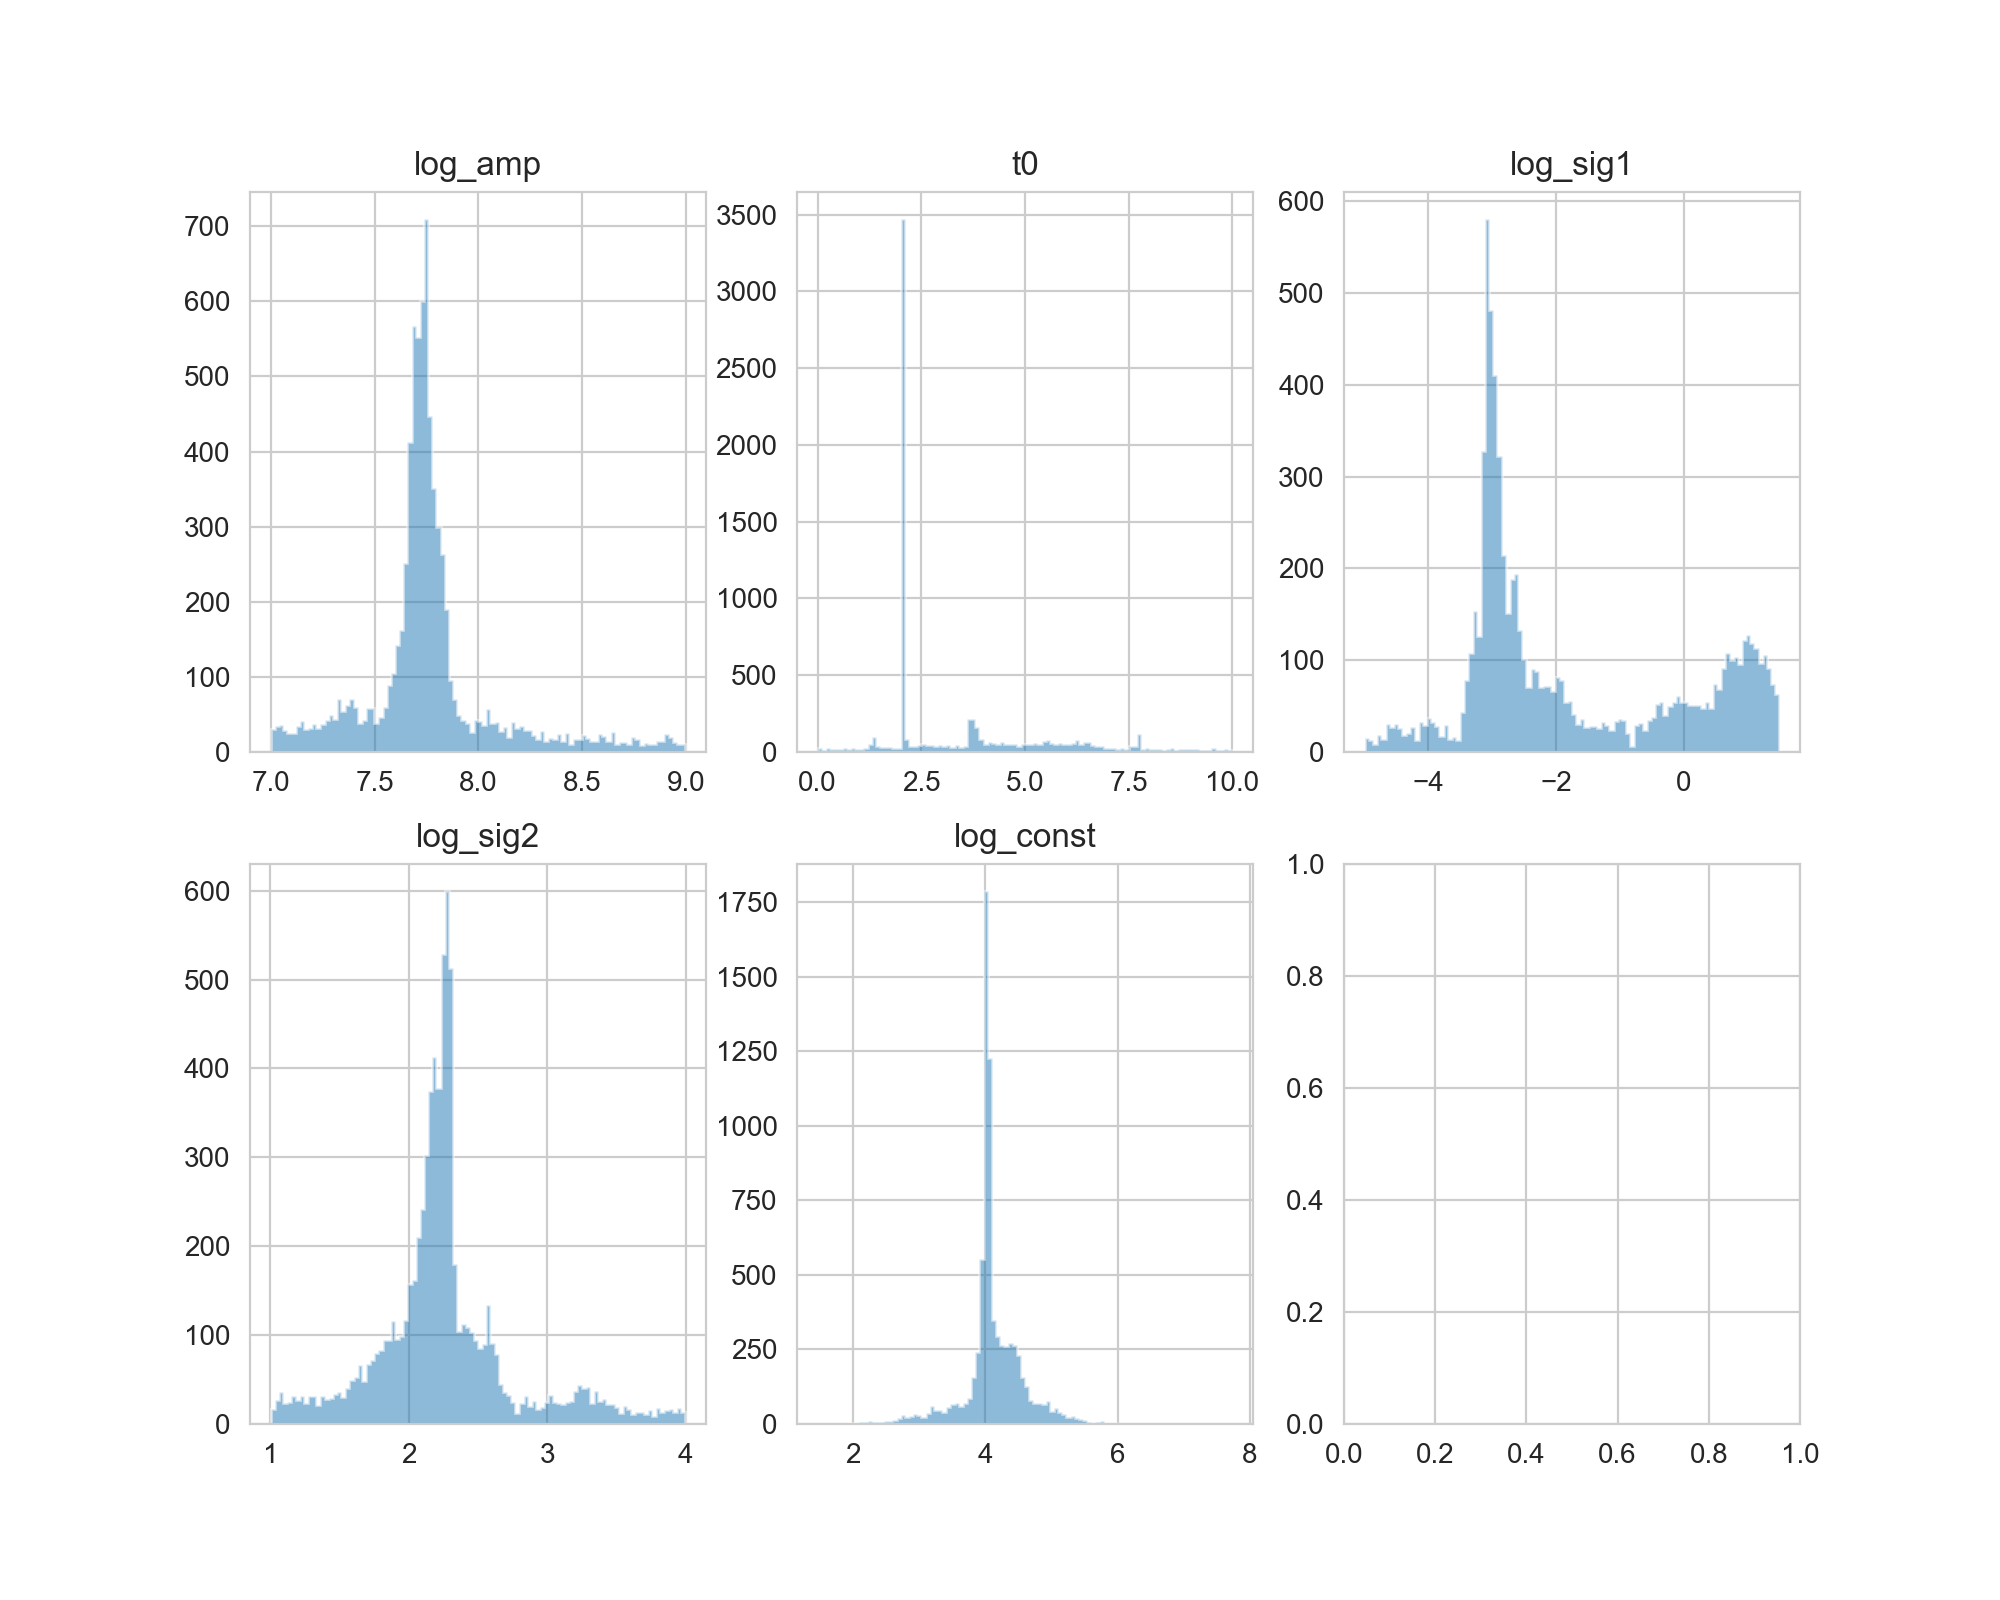

In [156]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


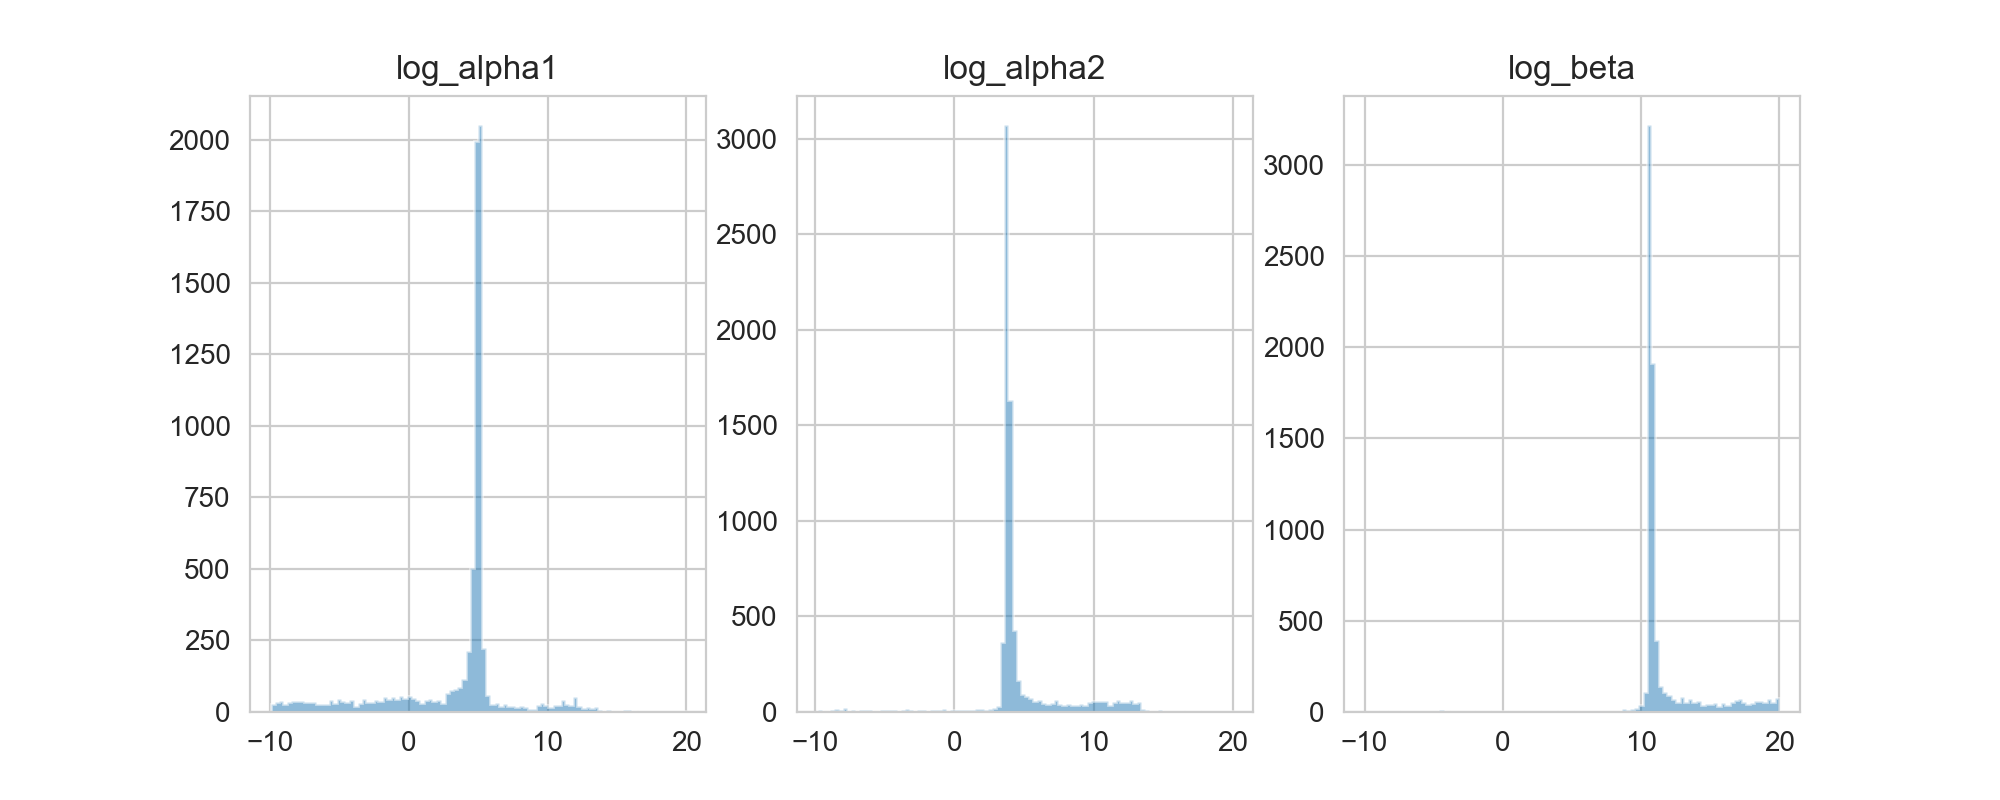

In [157]:
kernel_var_names = ["log_alpha1", "log_alpha2", "log_beta"]


fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

Let's include a function to compute the PSD:

In [158]:
npoints = len(lc_bgo.counts)

<IPython.core.display.Javascript object>


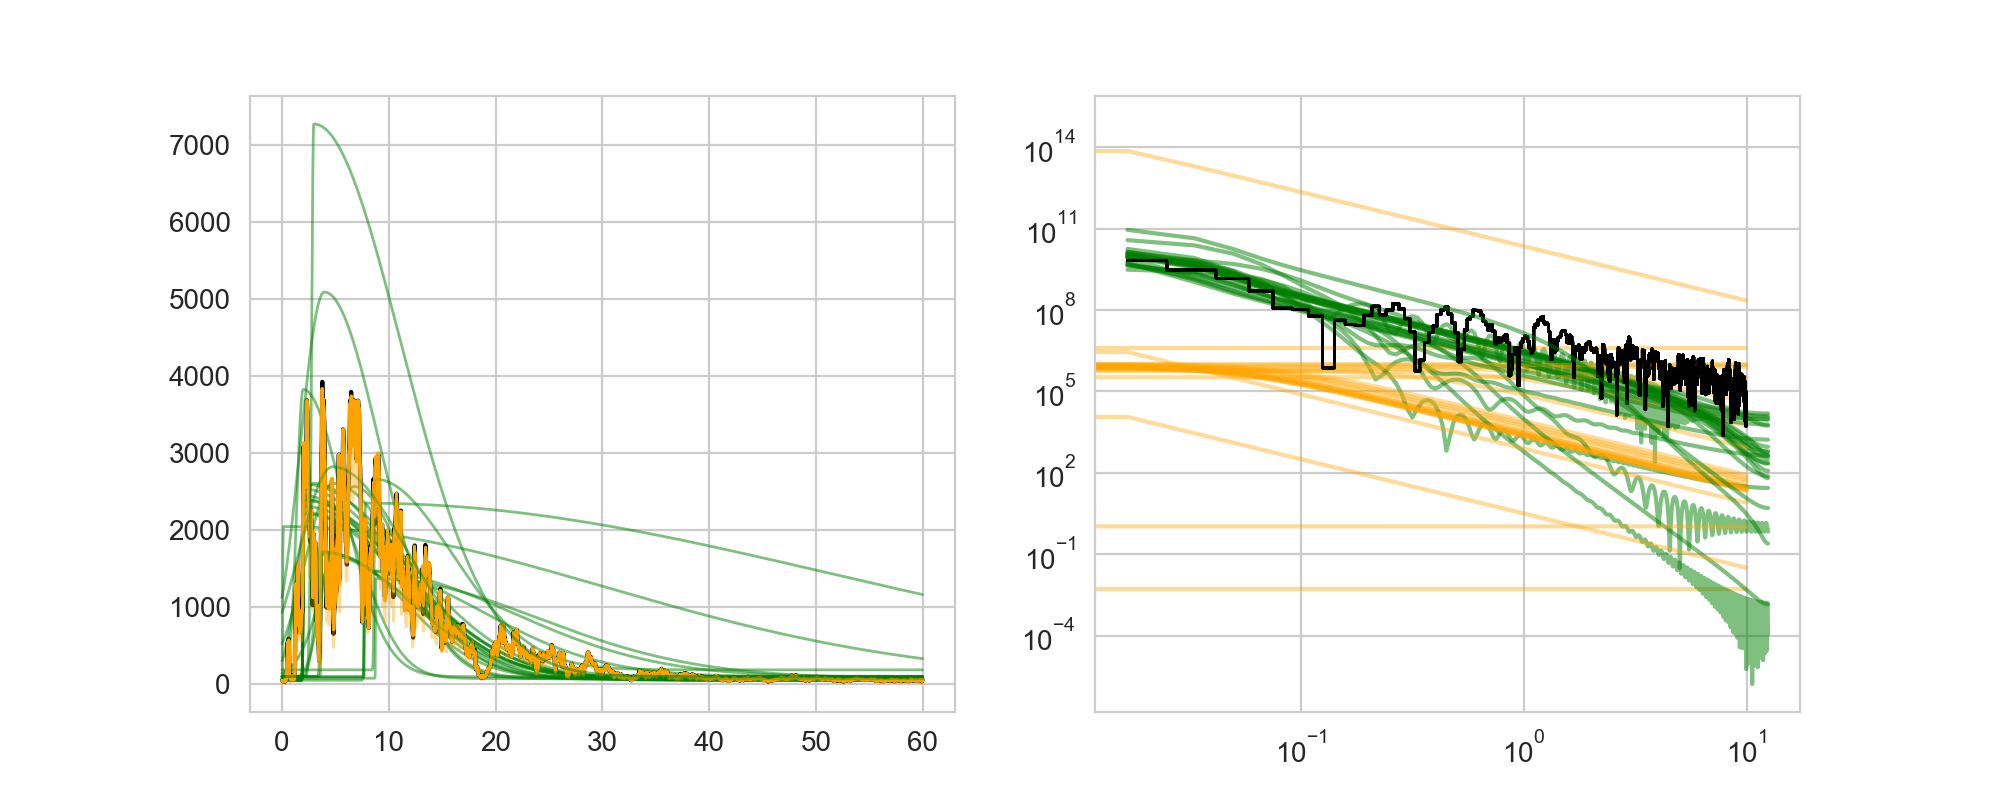

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time[:npoints], lc_bgo.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, lc_bgo.time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc_bgo.n, d=lc_bgo.dt)
freq = freq[:int(lc_bgo.n/2)]
# calculate periodogram for comparison:
ps_bgo = Powerspectrum(lc_bgo, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples["log_amp"][idx],
              samples["t0"][idx],
              samples["log_sig1"][idx],
              samples["log_sig2"][idx],
              samples["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx])]
    
    beta_post = jnp.exp(samples["log_beta"][idx])

    
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post)
    
    gp = GaussianProcess(kernel_post, lc_bgo.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc_bgo.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    psd = power_spectrum(freq, alpha_post, ma_coefs=[beta_post])
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps_bgo.freq, ps_bgo.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)


### Model with a QPO

In [180]:
mean_bkg = np.log(np.mean(lc_bgo.counts[-100:]))

def carma21_fermi_bgo_with_qpo(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(7, 9.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
    
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
        
    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(5, 15))
    log_cqpo = numpyro.sample("log_cqpo", dist.Uniform(-20, 2))
    log_freq = numpyro.sample("log_freq", dist.Uniform(np.log(0.3), np.log(5.0)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=jnp.exp(log_aqpo),
            b=0.0,
            c=jnp.exp(log_cqpo),
            d=2 * jnp.pi * jnp.exp(log_freq),
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo
    
    # gaussian process
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

Let's sample this model, too:

In [189]:
npoints = lc_bgo.n
ns_qpo = NestedSampler(carma21_fermi_bgo_with_qpo, constructor_kwargs={"max_samples":10000})
ns_qpo.run(random.PRNGKey(1200), lc_bgo.time[:npoints], y=lc_bgo.counts[:npoints])

In [190]:
import pickle
with open(datadir + "fermi_bgo_carma21_qpo_ns.pkl", "wb") as f:
    pickle.dump(ns_qpo, f)

In [191]:
samples_qpo, weights_qpo = ns_qpo.get_weighted_samples()

ns_qpo.print_summary()


--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 1998566
# samples: 10000
# slices: 293700.0
# slices / acceptance: 33.0
# likelihood evals / sample: 199.9
# likelihood evals / slice: 6.8
--------
logZ=-7852.37 +- 0.33
H=7900.0
ESS=923
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 4.94 +- 0.14 | 4.76 / 4.95 / 5.11 | 5.07 | 5.07
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 3.82 +- 0.11 | 3.68 / 3.82 / 3.98 | 3.9 | 3.9
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.59 +- 0.048 | 7.526 / 7.593 / 7.648 | 7.717 | 7.717
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 7.39 +- 0.37 | 6.92 / 7.39 / 7.95 | 7.57 | 7.57
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 10.66 +- 0.086

pred[114]: 1290.0 +- 86.0 | 1179.0 / 1288.0 / 1400.0 | 1061.0 | 1061.0
pred[115]: 1203.0 +- 85.0 | 1090.0 / 1201.0 / 1312.0 | 974.0 | 974.0
pred[116]: 727.0 +- 85.0 | 618.0 / 725.0 / 836.0 | 498.0 | 498.0
pred[117]: 421.0 +- 85.0 | 312.0 / 420.0 / 530.0 | 194.0 | 194.0
pred[118]: 265.0 +- 85.0 | 156.0 / 263.0 / 375.0 | 40.0 | 40.0
pred[119]: -59.0 +- 85.0 | -168.0 / -62.0 / 49.0 | -286.0 | -286.0
pred[120]: -126.0 +- 84.0 | -233.0 / -128.0 / -17.0 | -348.0 | -348.0
pred[121]: -325.0 +- 84.0 | -433.0 / -327.0 / -218.0 | -550.0 | -550.0
pred[122]: 34.0 +- 84.0 | -75.0 / 32.0 / 142.0 | -187.0 | -187.0
pred[123]: 401.0 +- 84.0 | 292.0 / 399.0 / 508.0 | 179.0 | 179.0
pred[124]: 730.0 +- 84.0 | 621.0 / 729.0 / 838.0 | 510.0 | 510.0
pred[125]: 1004.0 +- 83.0 | 895.0 / 1002.0 / 1112.0 | 785.0 | 785.0
pred[126]: 1283.0 +- 83.0 | 1178.0 / 1281.0 / 1391.0 | 1063.0 | 1063.0
pred[127]: 1667.0 +- 83.0 | 1558.0 / 1667.0 / 1774.0 | 1453.0 | 1453.0
pred[128]: 1517.0 +- 83.0 | 1411.0 / 1514.0 / 1625.0 |

pred[368]: -551.0 +- 75.0 | -643.0 / -549.0 / -458.0 | -517.0 | -517.0
pred[369]: -545.0 +- 75.0 | -637.0 / -543.0 / -453.0 | -510.0 | -510.0
pred[370]: -557.0 +- 75.0 | -648.0 / -554.0 / -464.0 | -521.0 | -521.0
pred[371]: -541.0 +- 75.0 | -632.0 / -539.0 / -448.0 | -505.0 | -505.0
pred[372]: -551.0 +- 75.0 | -643.0 / -549.0 / -459.0 | -515.0 | -515.0
pred[373]: -566.0 +- 75.0 | -657.0 / -564.0 / -473.0 | -529.0 | -529.0
pred[374]: -528.0 +- 75.0 | -620.0 / -526.0 / -436.0 | -491.0 | -491.0
pred[375]: -554.0 +- 74.0 | -646.0 / -553.0 / -462.0 | -517.0 | -517.0
pred[376]: -530.0 +- 74.0 | -621.0 / -528.0 / -438.0 | -492.0 | -492.0
pred[377]: -535.0 +- 74.0 | -627.0 / -534.0 / -444.0 | -497.0 | -497.0
pred[378]: -517.0 +- 74.0 | -609.0 / -516.0 / -426.0 | -479.0 | -479.0
pred[379]: -508.0 +- 74.0 | -600.0 / -507.0 / -417.0 | -470.0 | -470.0
pred[380]: -526.0 +- 74.0 | -617.0 / -525.0 / -435.0 | -487.0 | -487.0
pred[381]: -487.0 +- 74.0 | -579.0 / -486.0 / -397.0 | -448.0 | -448.0
pred[3

pred[574]: 238.0 +- 30.0 | 201.0 / 243.0 / 271.0 | 266.0 | 266.0
pred[575]: 184.0 +- 30.0 | 148.0 / 189.0 / 217.0 | 212.0 | 212.0
pred[576]: 184.0 +- 30.0 | 147.0 / 188.0 / 216.0 | 211.0 | 211.0
pred[577]: 187.0 +- 30.0 | 150.0 / 191.0 / 219.0 | 214.0 | 214.0
pred[578]: 193.0 +- 29.0 | 157.0 / 197.0 / 225.0 | 219.0 | 219.0
pred[579]: 130.0 +- 29.0 | 94.0 / 135.0 / 162.0 | 157.0 | 157.0
pred[580]: 137.0 +- 29.0 | 101.0 / 141.0 / 169.0 | 163.0 | 163.0
pred[581]: 108.0 +- 29.0 | 73.0 / 113.0 / 140.0 | 135.0 | 135.0
pred[582]: 117.0 +- 28.0 | 82.0 / 122.0 / 149.0 | 143.0 | 143.0
pred[583]: 114.0 +- 28.0 | 79.0 / 118.0 / 145.0 | 140.0 | 140.0
pred[584]: 96.0 +- 28.0 | 61.0 / 100.0 / 126.0 | 121.0 | 121.0
pred[585]: 106.0 +- 28.0 | 72.0 / 110.0 / 137.0 | 132.0 | 132.0
pred[586]: 117.0 +- 28.0 | 83.0 / 121.0 / 147.0 | 143.0 | 143.0
pred[587]: 75.0 +- 27.0 | 40.0 / 78.0 / 104.0 | 99.0 | 99.0
pred[588]: 61.0 +- 27.0 | 27.0 / 65.0 / 91.0 | 86.0 | 86.0
pred[589]: 14.0 +- 27.0 | -20.0 / 18.0 / 43.

pred[805]: 7.5 +- 7.8 | -2.3 / 8.4 / 15.6 | 9.9 | 9.9
pred[806]: -12.2 +- 7.8 | -22.0 / -11.3 / -4.1 | -9.8 | -9.8
pred[807]: -5.3 +- 7.8 | -15.0 / -4.4 / 2.8 | -2.9 | -2.9
pred[808]: 0.8 +- 7.7 | -8.9 / 1.6 / 8.8 | 3.1 | 3.1
pred[809]: 5.9 +- 7.7 | -3.8 / 6.7 / 13.9 | 8.2 | 8.2
pred[810]: 10.8 +- 7.7 | 1.0 / 11.6 / 18.7 | 13.0 | 13.0
pred[811]: -2.8 +- 7.7 | -12.6 / -2.1 / 5.1 | -0.6 | -0.6
pred[812]: 23.8 +- 7.7 | 14.1 / 24.6 / 31.8 | 26.0 | 26.0
pred[813]: 22.1 +- 7.7 | 12.4 / 22.9 / 30.0 | 24.2 | 24.2
pred[814]: 16.1 +- 7.7 | 6.4 / 16.9 / 24.0 | 18.2 | 18.2
pred[815]: 15.2 +- 7.6 | 5.6 / 16.0 / 23.2 | 17.3 | 17.3
pred[816]: 21.0 +- 7.6 | 11.5 / 21.8 / 29.0 | 23.1 | 23.1
pred[817]: -0.6 +- 7.6 | -10.2 / 0.1 / 7.3 | 1.4 | 1.4
pred[818]: -2.8 +- 7.6 | -12.3 / -2.1 / 5.1 | -0.8 | -0.8
pred[819]: -20.6 +- 7.6 | -30.1 / -19.9 / -12.7 | -18.6 | -18.6
pred[820]: -22.7 +- 7.6 | -32.1 / -22.0 / -14.8 | -20.7 | -20.7
pred[821]: -27.5 +- 7.6 | -36.9 / -26.8 / -19.6 | -25.6 | -25.6
pred[822]: -

pred[1022]: -22.2 +- 7.0 | -31.1 / -21.1 / -15.2 | -21.9 | -21.9
pred[1023]: -24.1 +- 7.0 | -33.0 / -23.1 / -17.2 | -23.9 | -23.9
pred[1024]: -17.1 +- 7.0 | -26.1 / -16.1 / -10.2 | -16.9 | -16.9
pred[1025]: -11.1 +- 7.0 | -20.1 / -10.1 / -4.2 | -10.9 | -10.9
pred[1026]: -9.1 +- 7.0 | -18.0 / -8.1 / -2.2 | -8.9 | -8.9
pred[1027]: -8.2 +- 7.0 | -17.1 / -7.2 / -1.2 | -7.9 | -7.9
pred[1028]: -14.1 +- 7.0 | -23.1 / -13.2 / -7.2 | -13.9 | -13.9
pred[1029]: -20.1 +- 7.0 | -29.0 / -19.1 / -13.1 | -19.8 | -19.8
pred[1030]: -11.2 +- 7.0 | -20.1 / -10.2 / -4.2 | -10.9 | -10.9
pred[1031]: -17.2 +- 7.0 | -26.1 / -16.2 / -10.2 | -16.9 | -16.9
pred[1032]: -35.0 +- 7.0 | -43.9 / -34.0 / -28.1 | -34.8 | -34.8
pred[1033]: -17.3 +- 7.0 | -26.2 / -16.3 / -10.3 | -17.0 | -17.0
pred[1034]: -38.1 +- 7.0 | -47.0 / -37.1 / -31.1 | -37.8 | -37.8
pred[1035]: -40.1 +- 7.0 | -49.0 / -39.1 / -33.1 | -39.9 | -39.9
pred[1036]: -24.1 +- 7.0 | -33.1 / -23.2 / -17.2 | -23.9 | -23.9
pred[1037]: -18.2 +- 7.0 | -27.1 / -17

In [193]:
logZ_carma = -7850.95
logZ_qpo = -7852.37

In [194]:
logZ_carma - logZ_qpo

1.4200000000000728

<IPython.core.display.Javascript object>


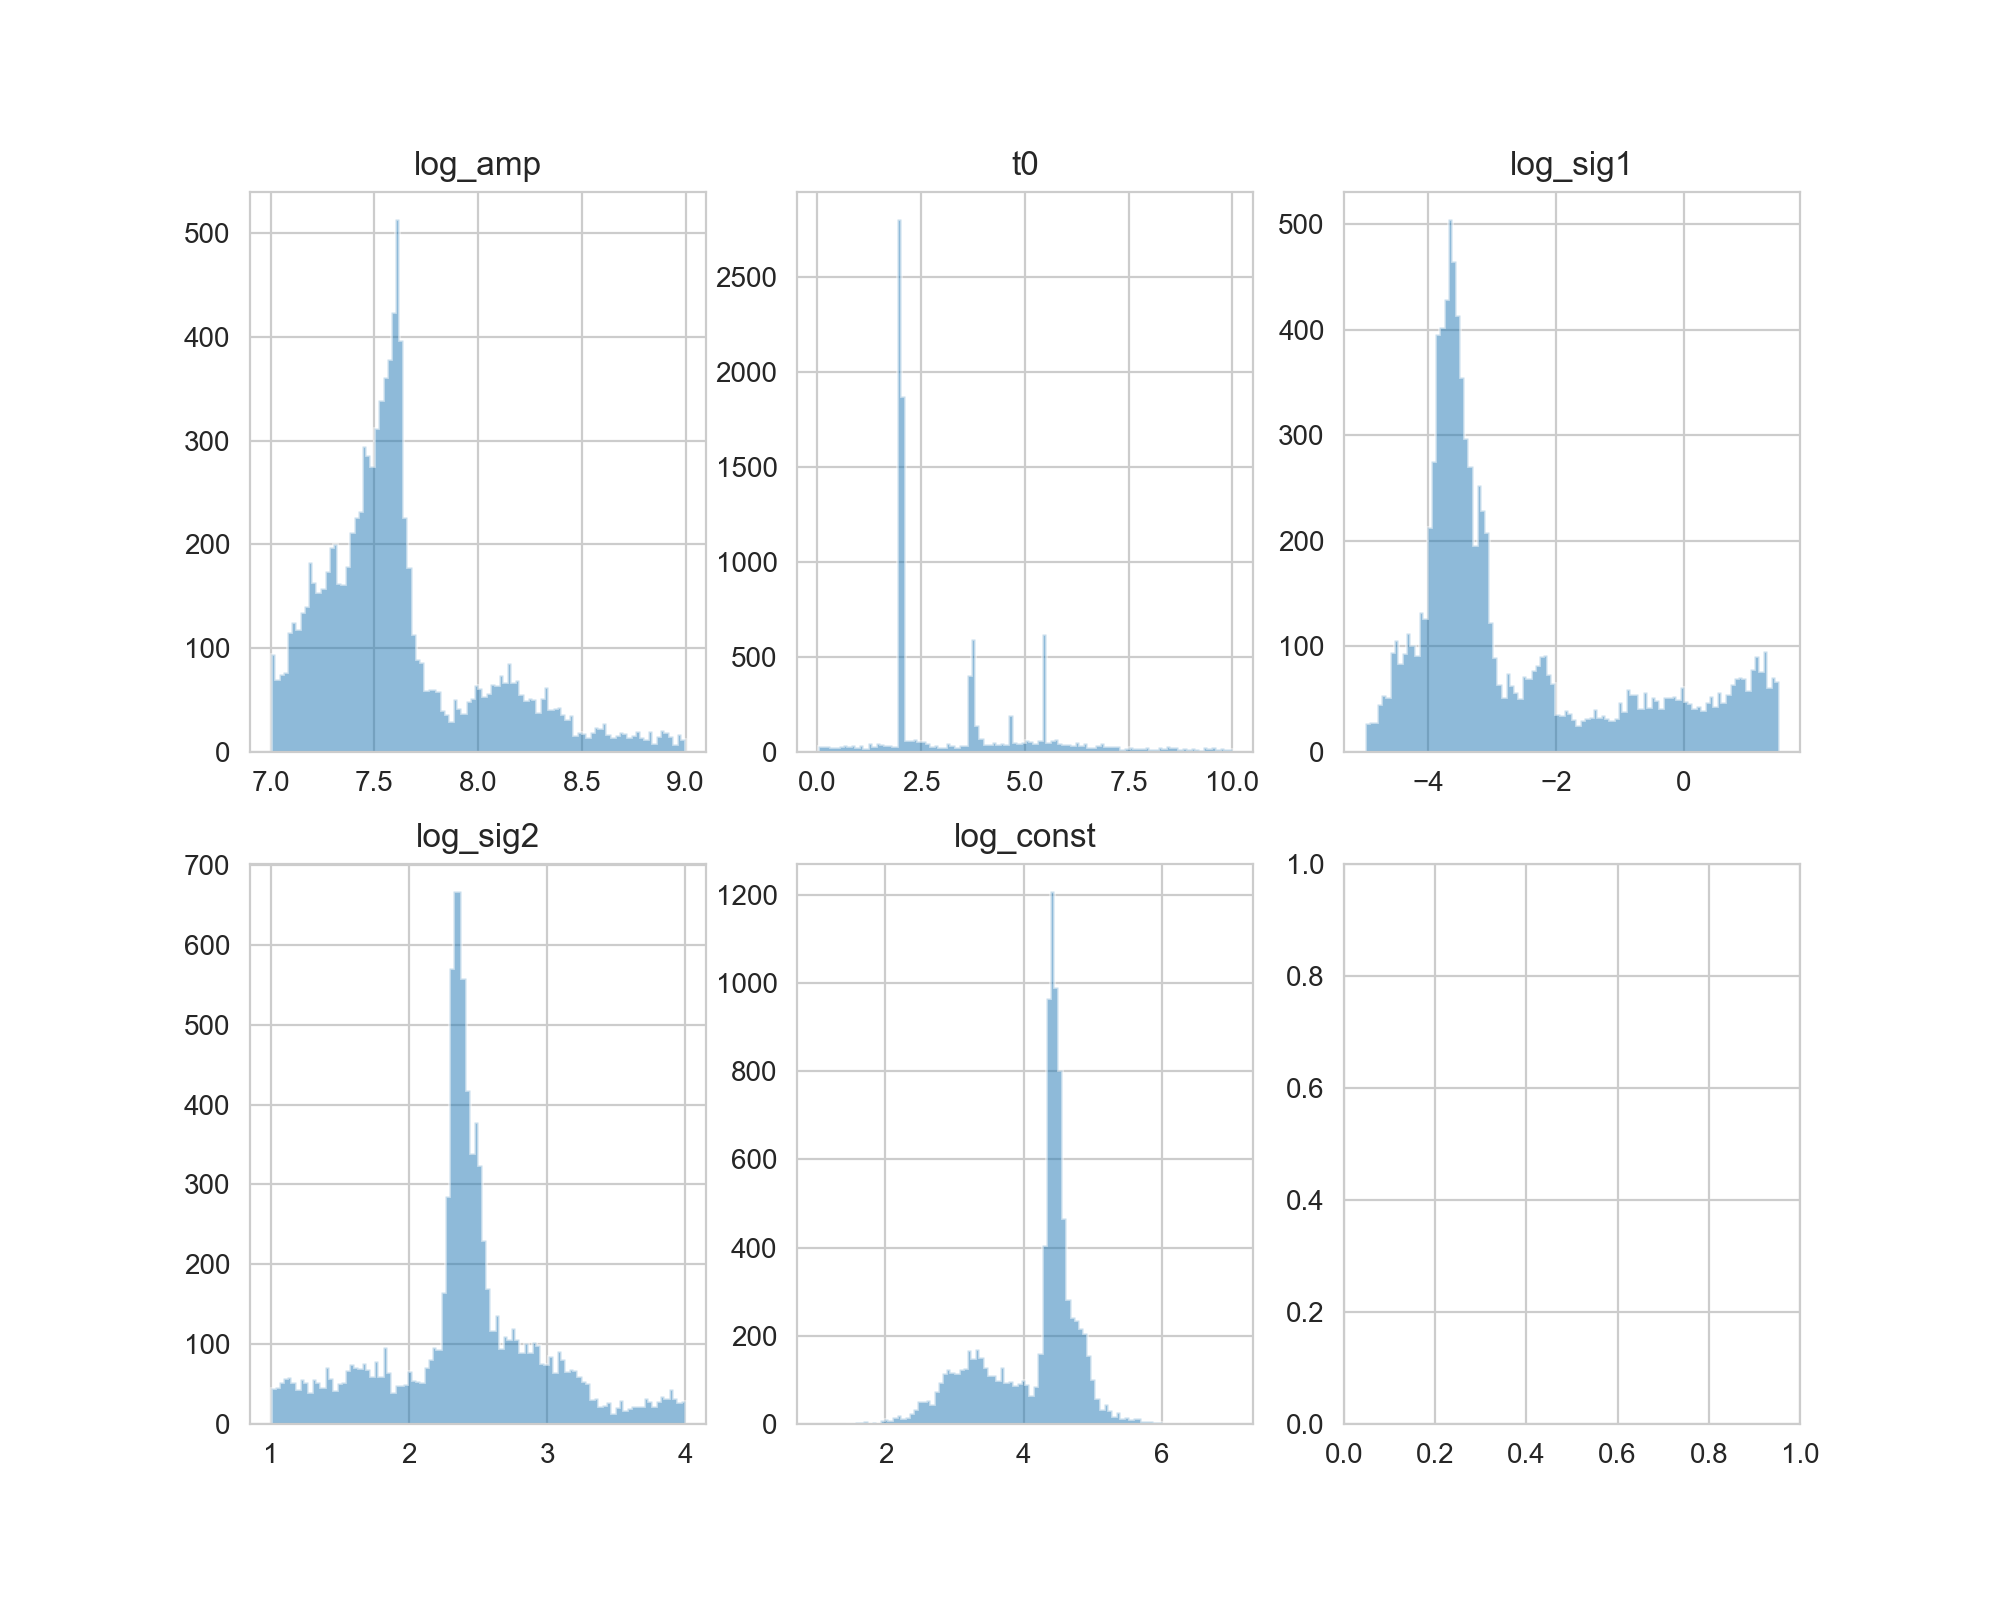

In [195]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples_qpo[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


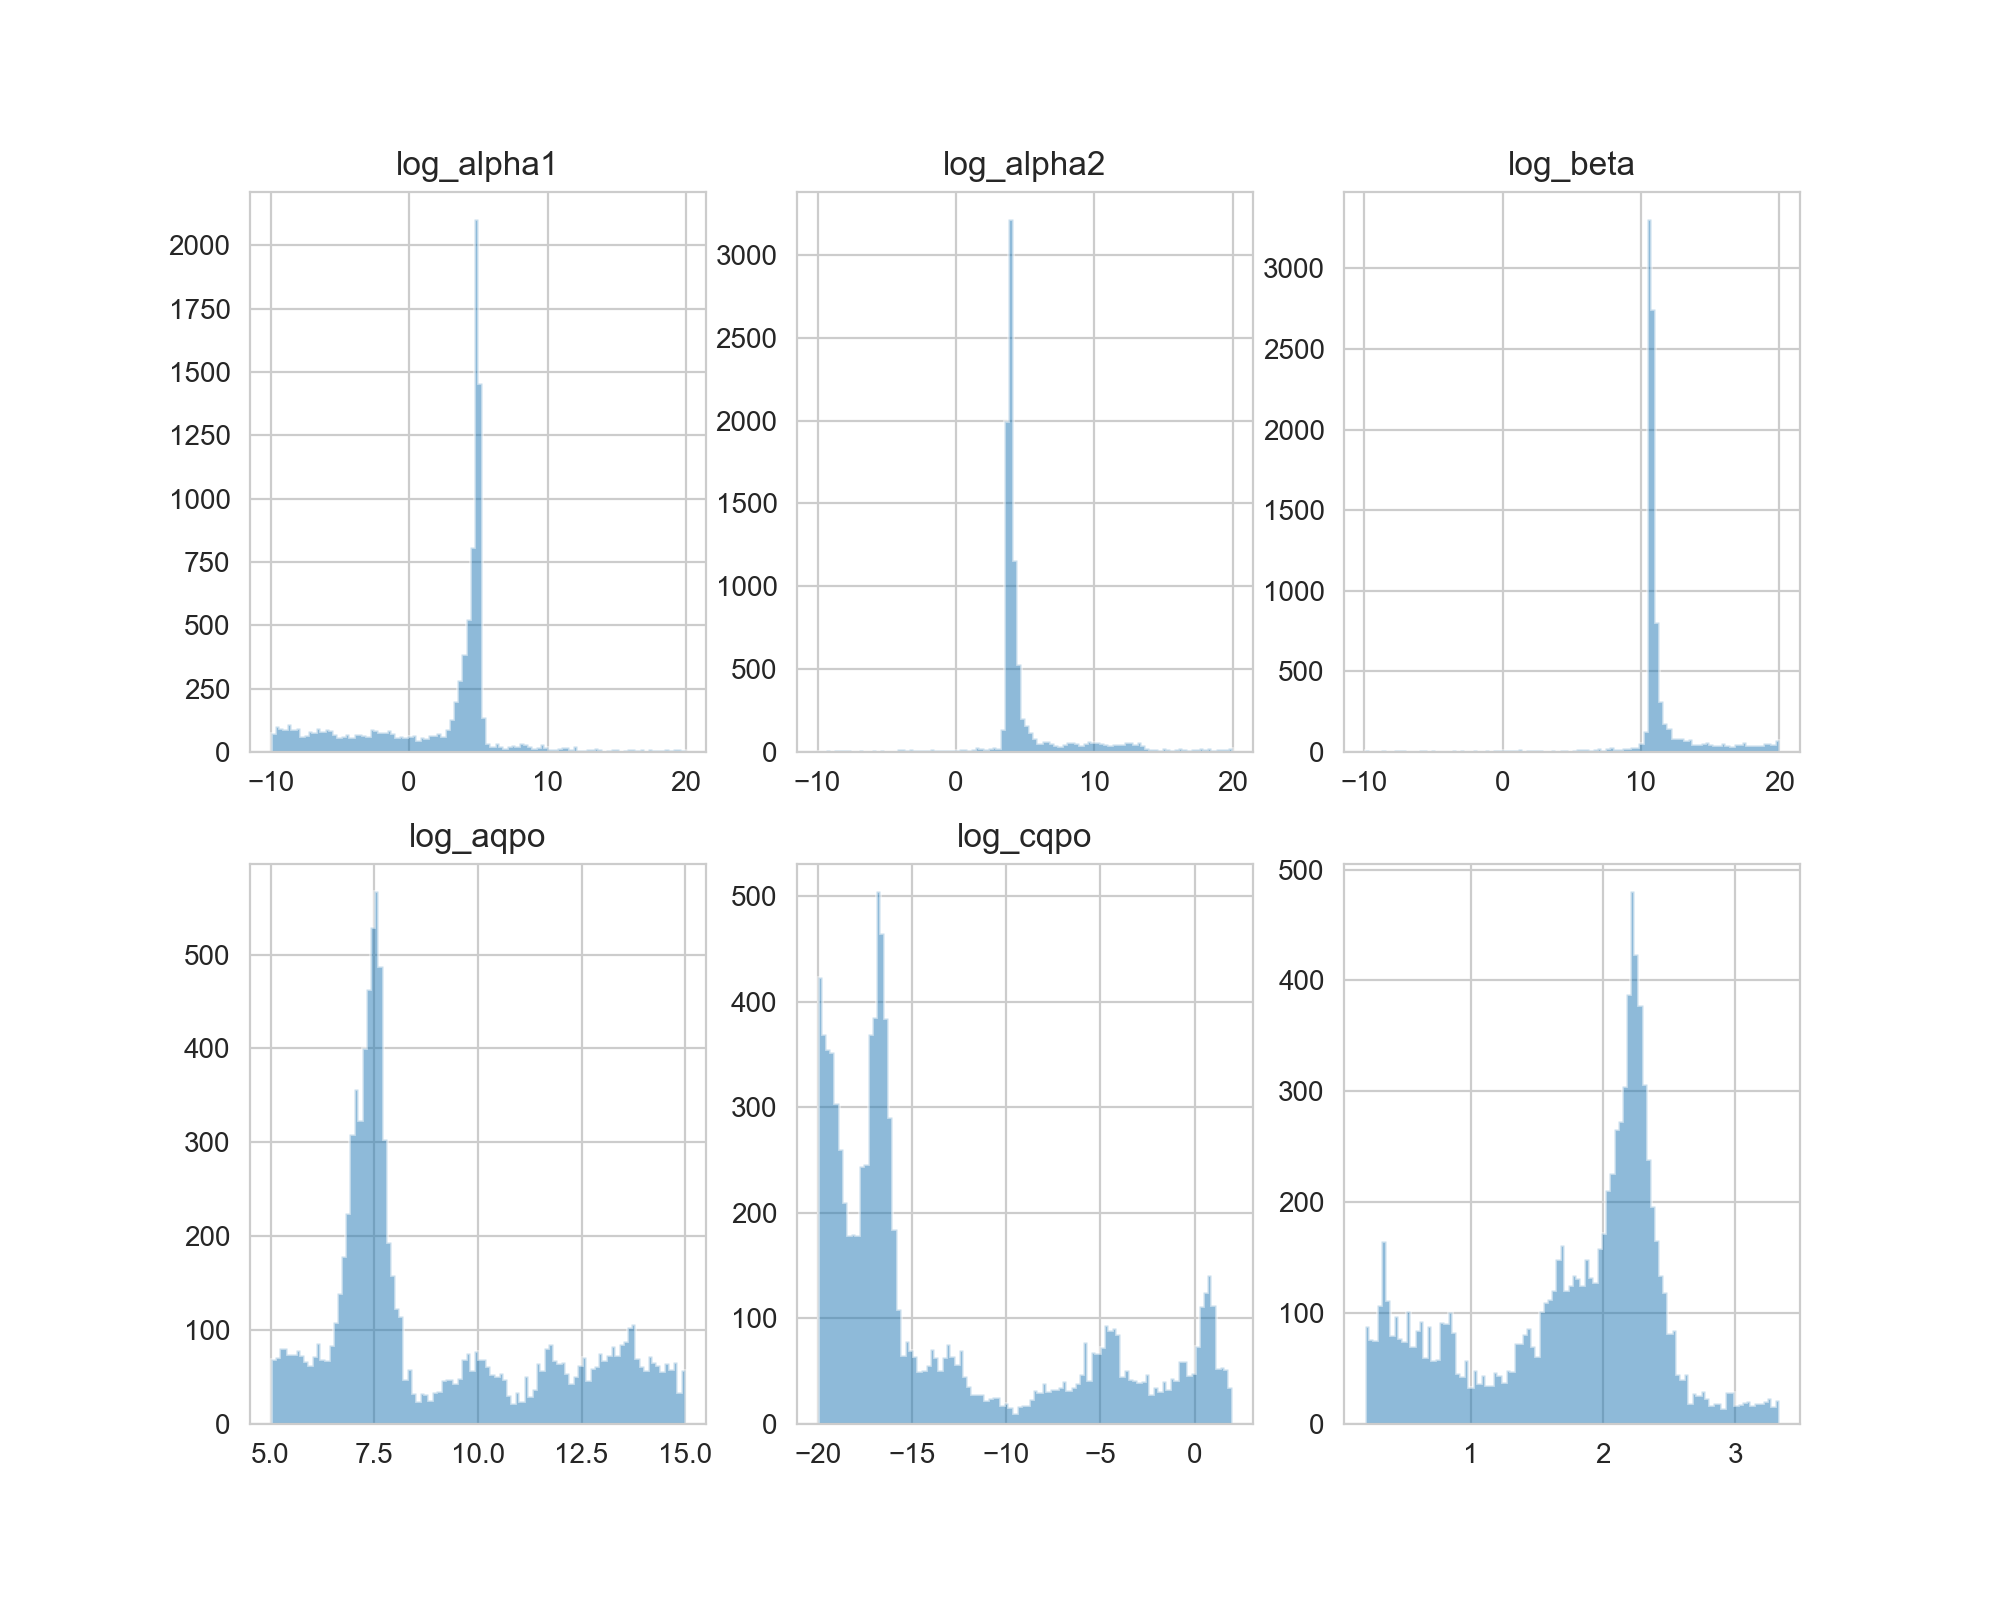

In [196]:
kernel_var_names = ["log_alpha1", "log_alpha2",
                    "log_beta", "log_aqpo", 
                    "log_cqpo", "log_freq"]


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):

    samp = samples_qpo[vn].block_until_ready()  
    if vn == "log_freq":
        axes[i].hist(1./jnp.exp(samp), bins=100, histtype="stepfilled", alpha=0.5)
    else:
        axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
        axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

In [198]:
def lorentzian(freq, amp, f0, fwhm):
    """
    A Lorentzian function (Cauchy distribution)
    
    Parameters
    ----------
    freq : numpy.ndarray
        An array of frequencies for which to 
        compute the Lorentzian
        
    amp : float
        The amplitude of the Lorentzian
        
    f0 : float
        The centroid frequency of the Lorentzian
        
    fwhm : float
        The full-width at half-maximum of the 
        Lorentzian
        
    Returns
    -------
    lor : numpy.ndarray
        The values of the Lorentzian for the 
        given parameters and frequency array
    
    """
    num = amp * fwhm**2.
    denom = fwhm**2. + (freq - f0)**2.0
    
    return num/denom   

<IPython.core.display.Javascript object>


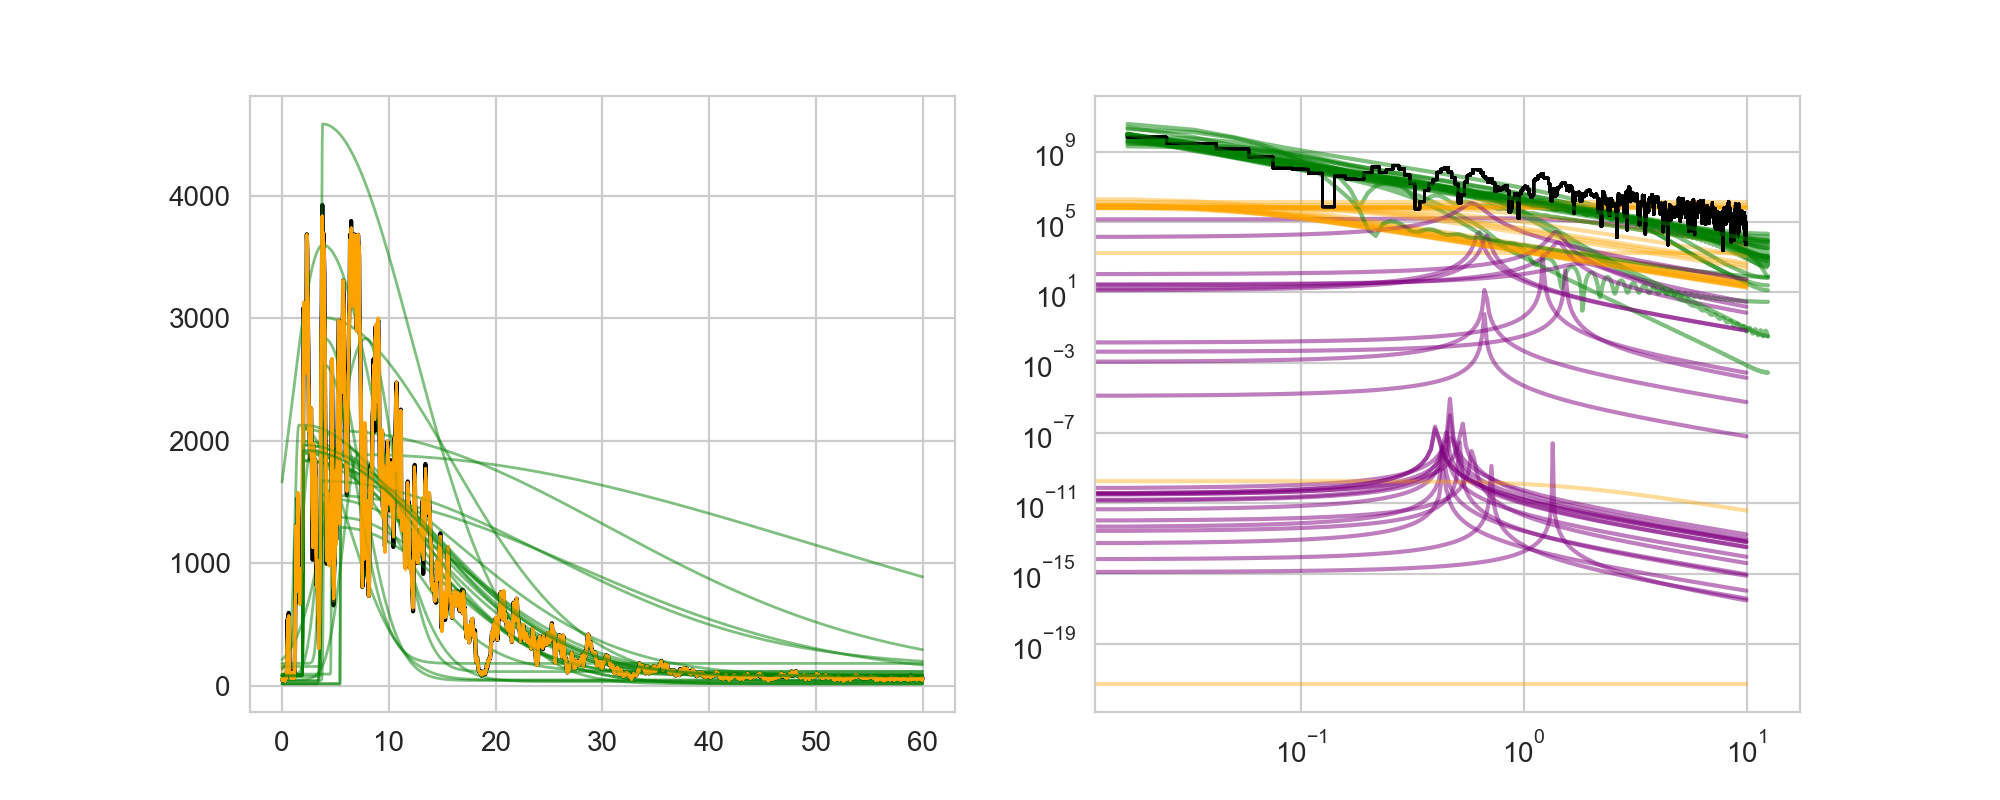

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time[:npoints], lc_bgo.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples_qpo["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, lc_bgo.time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc_bgo.n, d=lc_bgo.dt)
freq = freq[:int(lc_bgo.n/2)]

# calculate periodogram for comparison:
ps_bgo = Powerspectrum(lc_bgo, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples_qpo["log_amp"][idx],
              samples_qpo["t0"][idx],
              samples_qpo["log_sig1"][idx],
              samples_qpo["log_sig2"][idx],
              samples_qpo["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples_qpo["log_alpha1"][idx]),
             jnp.exp(samples_qpo["log_alpha2"][idx])]
    
    beta_post = jnp.exp(samples_qpo["log_beta"][idx])
    
    kernel_carma = CARMA.init(alpha=alpha_post, 
                        beta=beta_post)
    
    
    aqpo_post = jnp.exp(samples_qpo["log_aqpo"][idx])
    cqpo_post = jnp.exp(samples_qpo["log_cqpo"][idx])
    freq_post = jnp.exp(samples_qpo['log_freq'][idx])
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=aqpo_post,
            b=0.0,
            c=cqpo_post,
            d=2 * jnp.pi * freq_post
        )
    
    # add kernels together
    kernel_post = kernel_carma + kernel_qpo
    
    gp = GaussianProcess(kernel_post, lc_bgo.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc_bgo.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    # PSD of the CARMA process
    psd_carma = power_spectrum(freq, alpha_post, ma_coefs=[beta_post])
    psd_lor = lorentzian(freq, aqpo_post, freq_post, cqpo_post)
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps_bgo.freq, ps_bgo.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd_carma, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)
    ax2.loglog(freq, psd_lor, color="purple", alpha=0.5)
